In [ ]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore, chi2
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, learning_curve
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, roc_auc_score, precision_recall_curve,
    auc, classification_report, brier_score_loss,
    balanced_accuracy_score, matthews_corrcoef
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance

# Identifiying the Most Influenctial Factors Impacting Profitibilty of Lufthansa as a whole

In [ ]:
# @title
df = pd.read_excel('/content/lh_group_quarterly.xlsx')
display(df.head())
df.info()
display(df.isnull().sum())
df = df.drop_duplicates()
print(df.duplicated().sum())

covid_dummy period_type  year quart  adjusted_ebit  adjusted_ebit_marge  \
0            0   pre_covid  2012    q1           -397            -0.059979   
1            0   pre_covid  2012    q2            484             0.061343   
2            0   pre_covid  2012    q3            885             0.106473   
3            0   pre_covid  2012    q4            696             0.095160   
4            0   pre_covid  2013    q1           -497            -0.074985   

   adjusted_ebitda  ebit  fuel  fees_charges  operating_lease_charter  \
0               76  -397 -1624         -1200                    -36.0   
1              935   484 -1941         -1332                    -25.0   
2             1342   885 -2002         -1388                    -26.0   
3             1228   696 -1825         -1247                    -26.0   
4               -3  -497 -1660         -1174                    -21.0   

   other_material_cost  staff_cost  total_revenue  
0               -904.0       -1713           6619  
1               -877.0       -1433           7890  
2               -941.0       -1686           8312  
3               -879.0       -1906           7314  
4              -1247.0       -1787           6628

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   covid_dummy              55 non-null     int64  
 1   period_type              55 non-null     object 
 2   year                     55 non-null     int64  
 3   quart                    55 non-null     object 
 4   adjusted_ebit            55 non-null     int64  
 5   adjusted_ebit_marge      55 non-null     float64
 6   adjusted_ebitda          55 non-null     int64  
 7   ebit                     55 non-null     int64  
 8   fuel                     55 non-null     int64  
 9   fees_charges             55 non-null     int64  
 10  operating_lease_charter  55 non-null     float64
 11  other_material_cost      55 non-null     float64
 12  staff_cost               55 non-null     int64  
 13  total_revenue            55 non-null     int64  
dtypes: float64(3), int64(9), obj

covid_dummy                0
period_type                0
year                       0
quart                      0
adjusted_ebit              0
adjusted_ebit_marge        0
adjusted_ebitda            0
ebit                       0
fuel                       0
fees_charges               0
operating_lease_charter    0
other_material_cost        0
staff_cost                 0
total_revenue              0
dtype: int64

0


In [ ]:
# @title
df_no_covid = df[df['covid_dummy'] == 0].copy()
display(df_no_covid.head())
df_no_covid.info()

covid_dummy period_type  year quart  adjusted_ebit  adjusted_ebit_marge  \
0            0   pre_covid  2012    q1           -397            -0.059979   
1            0   pre_covid  2012    q2            484             0.061343   
2            0   pre_covid  2012    q3            885             0.106473   
3            0   pre_covid  2012    q4            696             0.095160   
4            0   pre_covid  2013    q1           -497            -0.074985   

   adjusted_ebitda  ebit  fuel  fees_charges  operating_lease_charter  \
0               76  -397 -1624         -1200                    -36.0   
1              935   484 -1941         -1332                    -25.0   
2             1342   885 -2002         -1388                    -26.0   
3             1228   696 -1825         -1247                    -26.0   
4               -3  -497 -1660         -1174                    -21.0   

   other_material_cost  staff_cost  total_revenue  
0               -904.0       -1713           6619  
1               -877.0       -1433           7890  
2               -941.0       -1686           8312  
3               -879.0       -1906           7314  
4              -1247.0       -1787           6628

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, 0 to 54
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   covid_dummy              47 non-null     int64  
 1   period_type              47 non-null     object 
 2   year                     47 non-null     int64  
 3   quart                    47 non-null     object 
 4   adjusted_ebit            47 non-null     int64  
 5   adjusted_ebit_marge      47 non-null     float64
 6   adjusted_ebitda          47 non-null     int64  
 7   ebit                     47 non-null     int64  
 8   fuel                     47 non-null     int64  
 9   fees_charges             47 non-null     int64  
 10  operating_lease_charter  47 non-null     float64
 11  other_material_cost      47 non-null     float64
 12  staff_cost               47 non-null     int64  
 13  total_revenue            47 non-null     int64  
dtypes: float64(3), int64(9), object(2


=== Correlation Matrix (Numerical Variables) ===


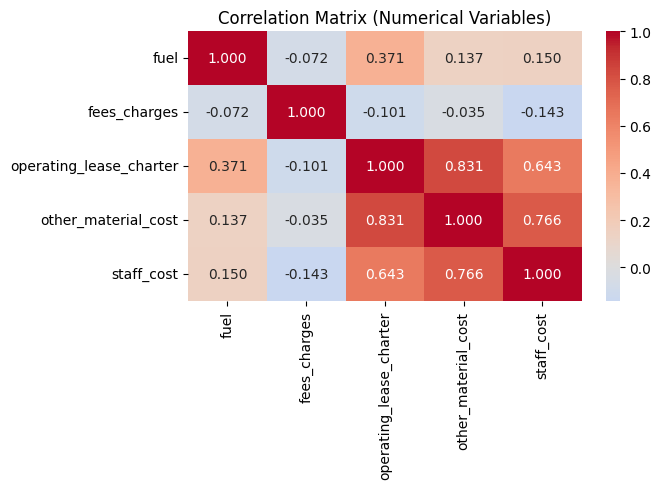

In [ ]:
# @title
linear_numerical_vars = ['fuel','fees_charges','operating_lease_charter','other_material_cost','staff_cost']
linear_dependent_var = 'adjusted_ebitda'

X_lr = df_no_covid[linear_numerical_vars].copy()
y_lr = df_no_covid[linear_dependent_var]

print("\n Correlation Matrix")
plt.figure(figsize=(7,5))
sns.heatmap(X_lr.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title("Correlation")
plt.tight_layout()
plt.show()



PCA Analysis
Explained Variance Ratio: [0.521  0.2021 0.1877 0.0666 0.0226]
Cumulative Variance: [0.521  0.7231 0.9108 0.9774 1.    ]

Loadings Matrix:


PC1    PC2    PC3    PC4    PC5
fuel                     0.235 -0.475  0.808  0.193  0.170
fees_charges            -0.106  0.842  0.518  0.089 -0.065
operating_lease_charter  0.570  0.021  0.106 -0.560 -0.592
other_material_cost      0.571  0.234 -0.132 -0.221  0.744
staff_cost               0.532  0.104 -0.224  0.769 -0.253

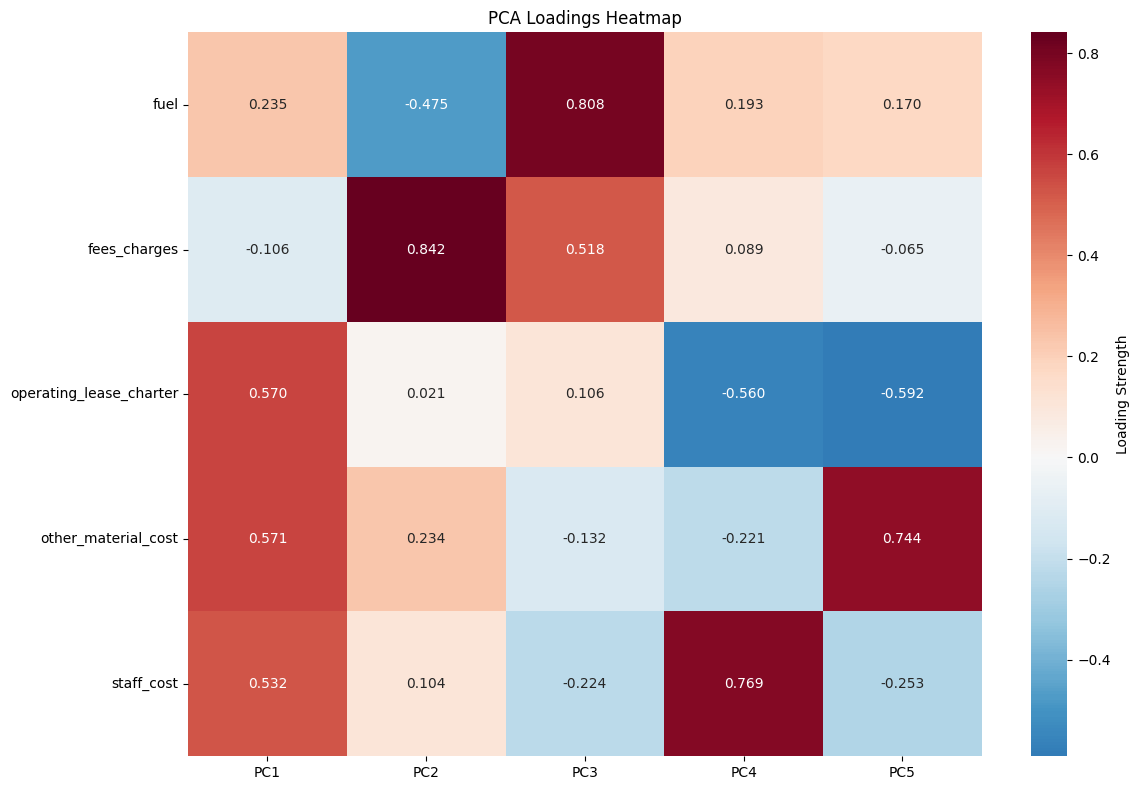

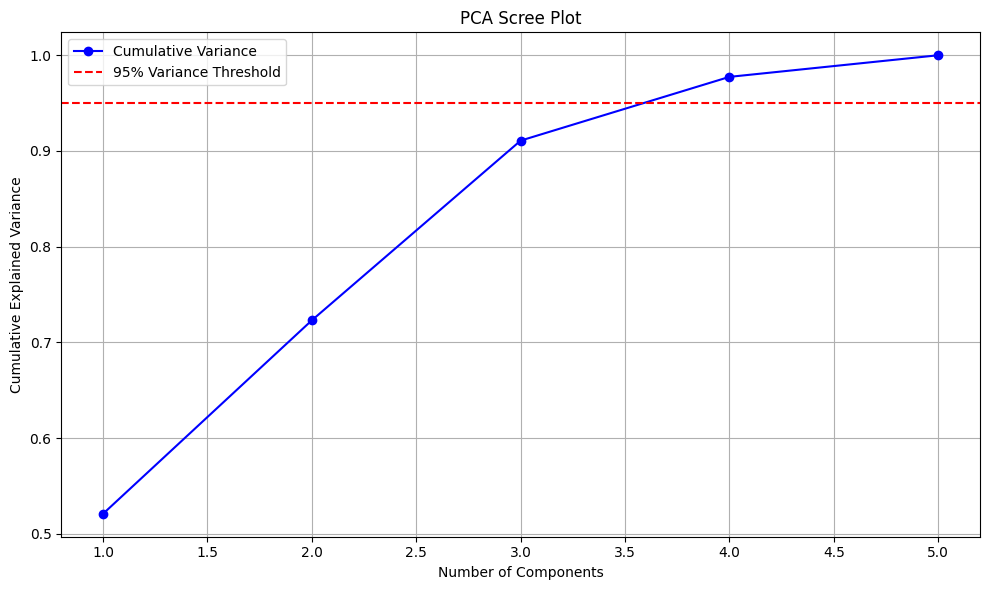


Variance retained with 3 components: 91.1%

Correlation Matrix (Numerical Variables)


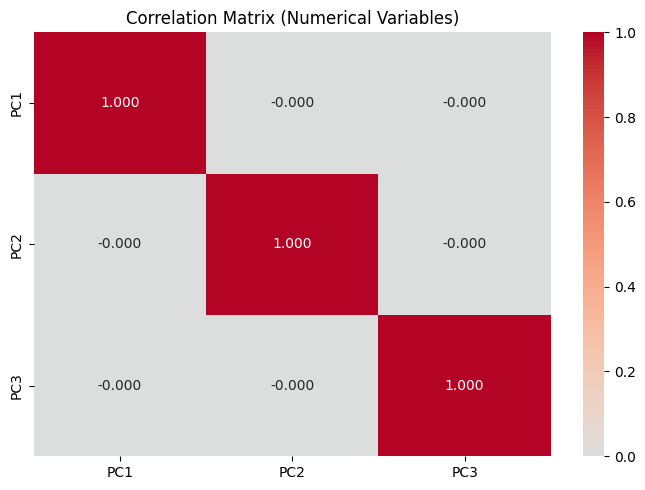


Training and Test set size
Training set size: 37 samples
Test set size: 10 samples

 Variance Inflation Factor (VIF)


Feature     VIF
0   const  1.0425
1     PC1  1.0017
2     PC2  1.0014
3     PC3  1.0014


STATSMODELS OLS REGRESSION
                             OLS Regression Results                            
Dep. Variable:     adjusted_ebit_marge   R-squared:                       0.638
Model:                             OLS   Adj. R-squared:                  0.605
Method:                  Least Squares   F-statistic:                     19.35
Date:                 Sat, 22 Nov 2025   Prob (F-statistic):           2.03e-07
Time:                         23:13:43   Log-Likelihood:                 64.285
No. Observations:                   37   AIC:                            -120.6
Df Residuals:                       33   BIC:                            -114.1
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

Statistic      Value
0                                   R²     0.6376
1                          Adjusted R²     0.6046
2                          F-statistic    19.3503
3                  F-statistic p-value     0.0000
4                                  AIC  -120.5709
5                                  BIC  -114.1273
6                        Durbin-Watson     2.1978
7             Shapiro-Wilk (normality)     0.9430
8                 Shapiro-Wilk p-value     0.0574
9   Breusch-Pagan (heteroscedasticity)     5.0180
10               Breusch-Pagan p-value     0.1705


Advanced Residual Analysis


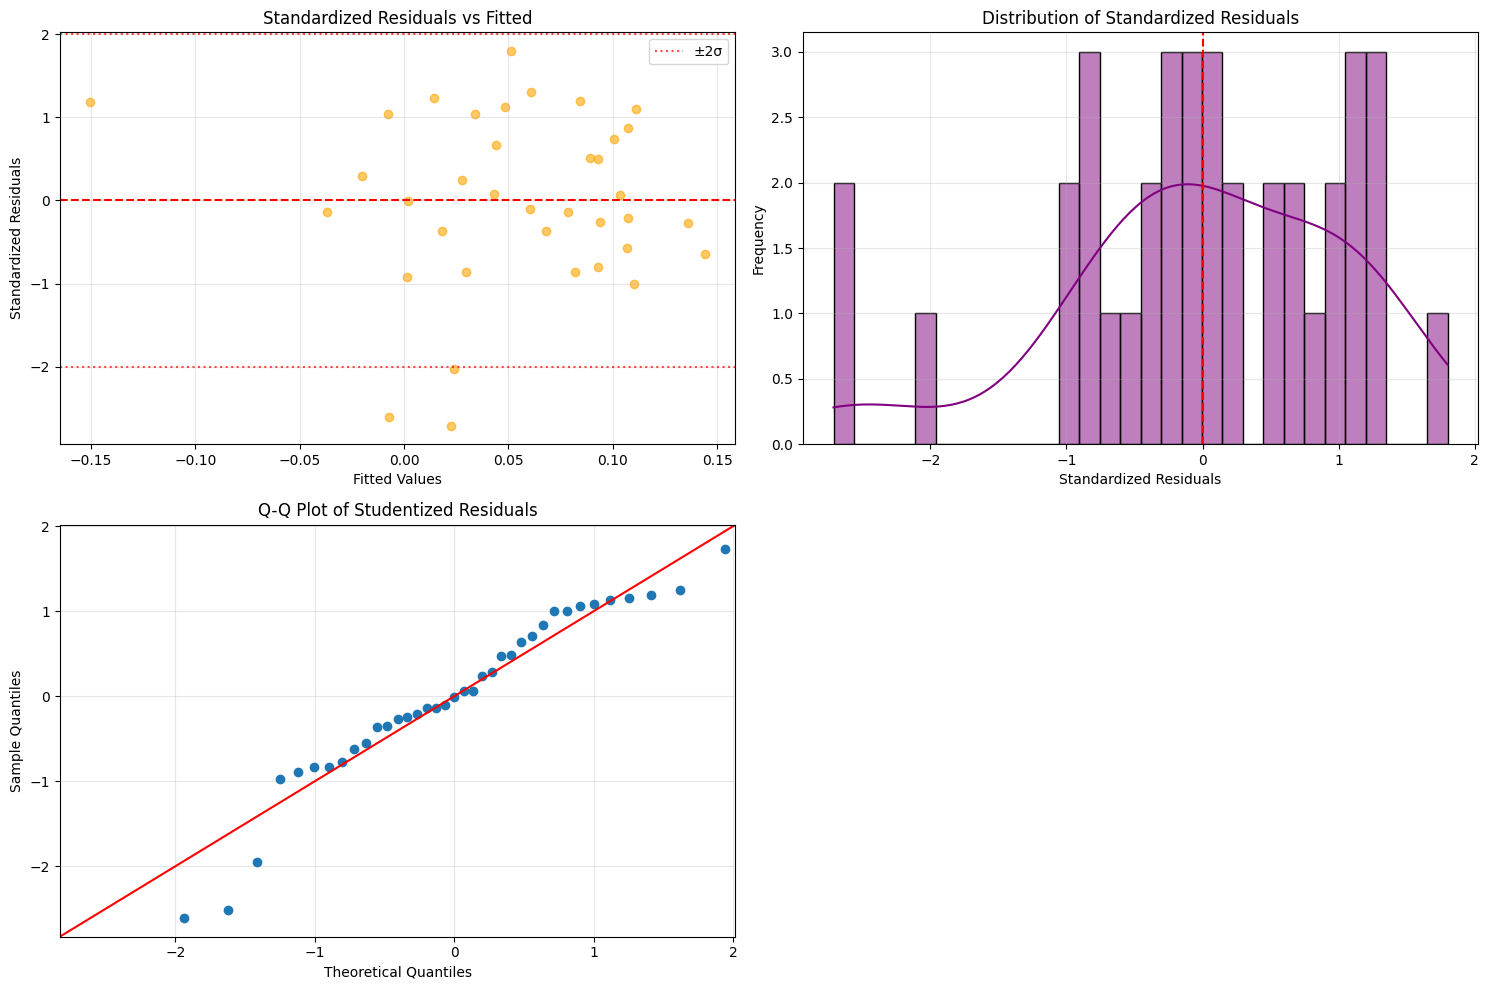


Diagnostic Plots


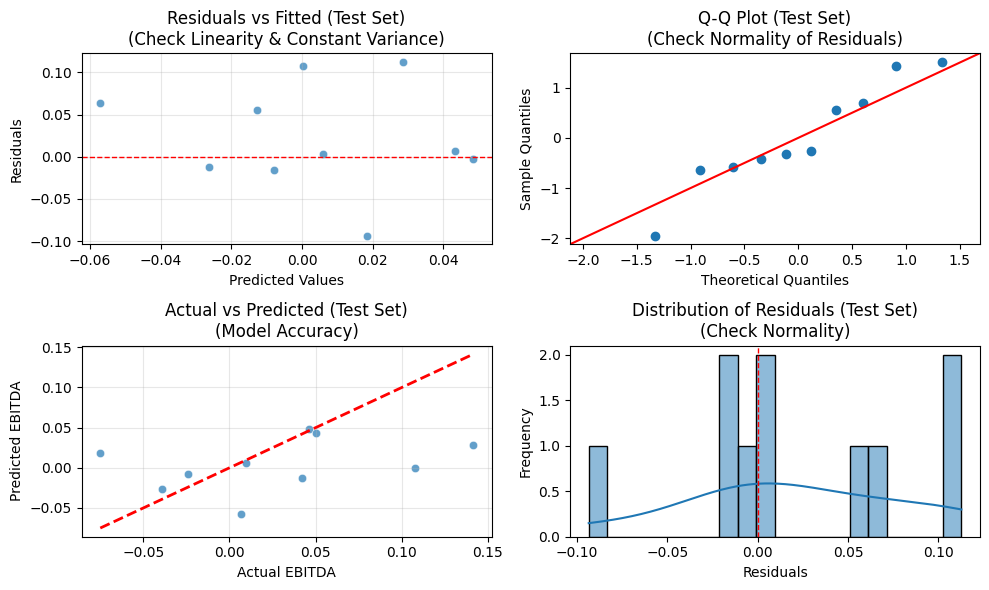


Coefficient Confidence Intervals


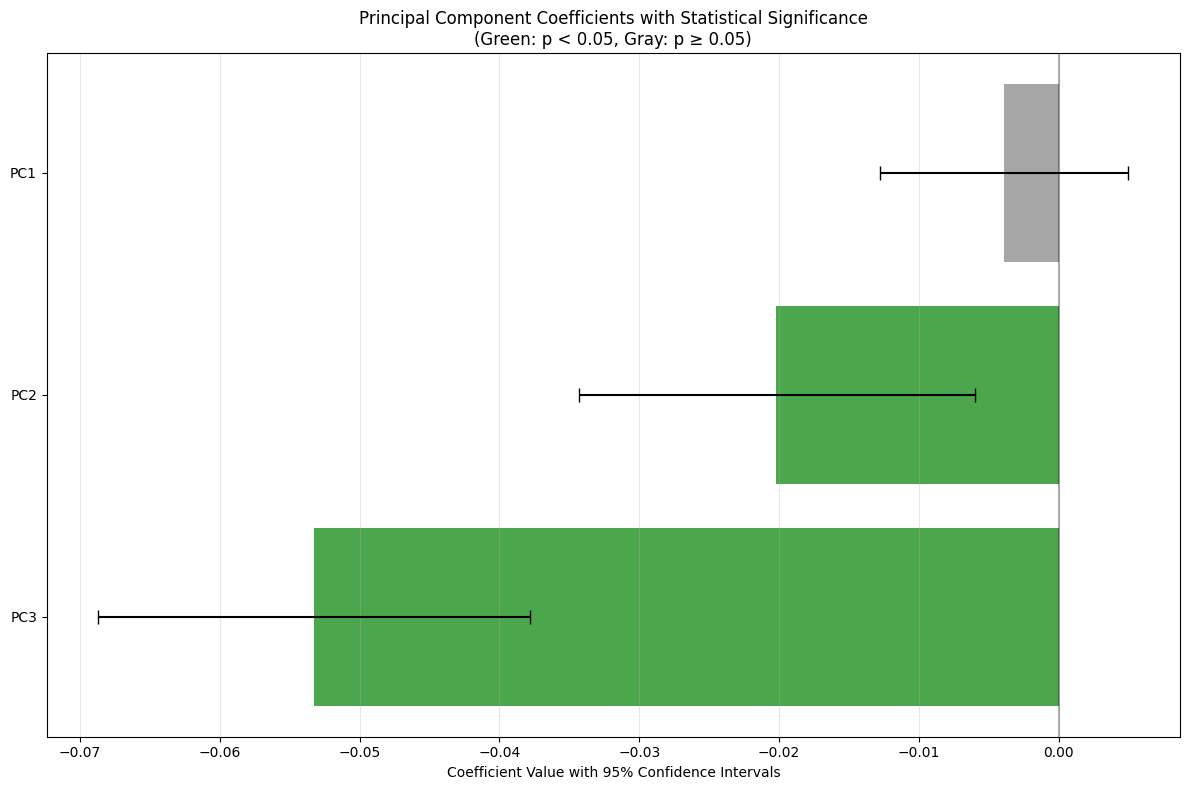

FINAL MODEL SUMMARY


Model  R²_Test  R²_Train  RMSE_Test  MAE_Test  MAPE_Test  \
0  PCA + OLS Regression  -0.0466    0.6376     0.0637    0.0474   152.8941   

        AIC       BIC  N_Features  N_Samples_Train  N_Samples_Test  
0 -120.5709 -114.1273           3               37              10

In [ ]:
# @title
linear_numerical_vars = ['fuel','fees_charges','operating_lease_charter','other_material_cost','staff_cost']
linear_dependent_var = 'adjusted_ebit_marge'

X_lr_original = df_no_covid[linear_numerical_vars].copy()
y_lr = df_no_covid[linear_dependent_var]

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lr_original)

pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\nPCA Analysis")
print("Explained Variance Ratio:", explained_variance.round(4))
print("Cumulative Variance:", cumulative_variance.round(4))

loadings = pd.DataFrame(
    pca_full.components_.T,
    columns=[f'PC{i+1}' for i in range(pca_full.n_components_)],
    index=X_lr_original.columns
)

print("\nLoadings Matrix:")
display(loadings.round(3))

plt.figure(figsize=(12, 8))
sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0, fmt='.3f',
            cbar_kws={'label': 'Loading Strength'})
plt.title('PCA Loadings Heatmap')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

n_components = 3
pca = PCA(n_components=n_components)
X_lr = pd.DataFrame(pca.fit_transform(X_scaled),
                   columns=[f'PC{i+1}' for i in range(n_components)],
                   index=X_lr_original.index)

print(f"\nVariance retained with {n_components} components: {pca.explained_variance_ratio_.sum():.1%}")

print("\nCorrelation Matrix (Numerical Variables)")
plt.figure(figsize=(7,5))
sns.heatmap(X_lr.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title("Correlation Matrix (Numerical Variables)")
plt.tight_layout()
plt.show()

X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(
    X_lr, y_lr, test_size=0.2, random_state=42
)
print("\nTraining and Test set size")
print(f"Training set size: {len(X_lr_train)} samples")
print(f"Test set size: {len(X_lr_test)} samples")

X_lr_train_vif = sm.add_constant(X_lr_train)
vif_data = pd.DataFrame({
    "Feature": X_lr_train_vif.columns,
    "VIF": [variance_inflation_factor(X_lr_train_vif.values, i)
            for i in range(X_lr_train_vif.shape[1])]
})

print("\n Variance Inflation Factor (VIF)")
display(vif_data.round(4))

print("\nSTATSMODELS OLS REGRESSION")

X_lr_train_sm = sm.add_constant(X_lr_train)
X_lr_test_sm = sm.add_constant(X_lr_test)

sm_lin_reg_model = sm.OLS(y_lr_train, X_lr_train_sm)
sm_lin_reg_results = sm_lin_reg_model.fit()

print(sm_lin_reg_results.summary())

y_lr_pred = sm_lin_reg_results.predict(X_lr_test_sm)

mse = mean_squared_error(y_lr_test, y_lr_pred)
rmse = np.sqrt(mse)
r2_test = r2_score(y_lr_test, y_lr_pred)
mae = mean_absolute_error(y_lr_test, y_lr_pred)

valid_mape_idx = y_lr_test != 0
if np.sum(valid_mape_idx) > 0:
    mape = np.mean(np.abs((y_lr_test[valid_mape_idx] - y_lr_pred[valid_mape_idx]) / y_lr_test[valid_mape_idx])) * 100
else:
    mape = np.nan

n = sm_lin_reg_results.nobs

residuals = y_lr_train - sm_lin_reg_results.predict(X_lr_train_sm)
shapiro_stat, shapiro_p = stats.shapiro(residuals)

bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals, X_lr_train_sm)

from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)

gof_advanced_df = pd.DataFrame({
    "Statistic": [
        "R²",
        "Adjusted R²",
        "F-statistic",
        "F-statistic p-value",
        "AIC",
        "BIC",
        "Durbin-Watson",
        "Shapiro-Wilk (normality)",
        "Shapiro-Wilk p-value",
        "Breusch-Pagan (heteroscedasticity)",
        "Breusch-Pagan p-value"
    ],
    "Value": [
        f"{sm_lin_reg_results.rsquared:.4f}",
        f"{sm_lin_reg_results.rsquared_adj:.4f}",
        f"{sm_lin_reg_results.fvalue:.4f}",
        f"{sm_lin_reg_results.f_pvalue:.4f}",
        f"{sm_lin_reg_results.aic:.4f}",
        f"{sm_lin_reg_results.bic:.4f}",
        f"{dw_stat:.4f}",
        f"{shapiro_stat:.4f}",
        f"{shapiro_p:.4f}",
        f"{bp_stat:.4f}",
        f"{bp_pvalue:.4f}"
    ]
})

print("\nGoodness-of-Fit")
display(gof_advanced_df)

print("\nAdvanced Residual Analysis")

residuals = y_lr_train - sm_lin_reg_results.predict(X_lr_train_sm)
leverage = sm_lin_reg_results.get_influence().hat_matrix_diag

resid_std = residuals / (sm_lin_reg_results.resid.std() * np.sqrt(1 - leverage))

ols_influence = OLSInfluence(sm_lin_reg_results)
resid_student = ols_influence.resid_studentized

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].scatter(sm_lin_reg_results.fittedvalues, resid_std, alpha=0.6, color='orange')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].axhline(y=2, color='red', linestyle=':', alpha=0.7, label='±2σ')
axes[0, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.7)
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Standardized Residuals')
axes[0, 0].set_title('Standardized Residuals vs Fitted')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

sns.histplot(resid_std, bins=30, kde=True, ax=axes[0, 1], color='purple')
axes[0, 1].axvline(x=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Standardized Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Standardized Residuals')
axes[0, 1].grid(True, alpha=0.3)

sm.qqplot(resid_student, line='45', fit=True, ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Studentized Residuals')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_visible(False)

plt.tight_layout()
plt.show()

print("\nDiagnostic Plots")

residuals_lin = y_lr_test - y_lr_pred

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_lr_pred, y=residuals_lin, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (Test Set)\n(Check Linearity & Constant Variance)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
sm.qqplot(residuals_lin, line='45', fit=True, ax=plt.gca())
plt.title('Q-Q Plot (Test Set)\n(Check Normality of Residuals)')

plt.subplot(2, 2, 3)
sns.scatterplot(x=y_lr_test, y=y_lr_pred, alpha=0.7)
plt.plot([y_lr_test.min(), y_lr_test.max()], [y_lr_test.min(), y_lr_test.max()],
         'red', linestyle='--', linewidth=2)
plt.xlabel('Actual EBITDA')
plt.ylabel('Predicted EBITDA')
plt.title('Actual vs Predicted (Test Set)\n(Model Accuracy)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
sns.histplot(residuals_lin, kde=True, bins=20)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Test Set)\n(Check Normality)')

plt.tight_layout()
plt.show()

print("\nCoefficient Confidence Intervals")

conf_int = sm_lin_reg_results.conf_int()
conf_int.columns = ['CI_Lower', 'CI_Upper']

coef_summary = pd.DataFrame({
    'Feature': sm_lin_reg_results.params.index,
    'Coefficient': sm_lin_reg_results.params.values,
    'Std_Error': sm_lin_reg_results.bse.values,
    't_Value': sm_lin_reg_results.tvalues.values,
    'p_Value': sm_lin_reg_results.pvalues.values,
    'CI_Lower': conf_int['CI_Lower'],
    'CI_Upper': conf_int['CI_Upper'],
    'Significant': sm_lin_reg_results.pvalues.values < 0.05
}).round(4)

significant_coefs = coef_summary[coef_summary['Feature'] != 'const'].sort_values('Coefficient')

plt.figure(figsize=(12, 8))
y_pos = np.arange(len(significant_coefs))
colors = ['green' if sig else 'gray' for sig in significant_coefs['Significant']]

plt.barh(y_pos, significant_coefs['Coefficient'],
         xerr=[significant_coefs['Coefficient'] - significant_coefs['CI_Lower'],
               significant_coefs['CI_Upper'] - significant_coefs['Coefficient']],
         color=colors, alpha=0.7, capsize=5)

plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.yticks(y_pos, significant_coefs['Feature'])
plt.xlabel('Coefficient Value with 95% Confidence Intervals')
plt.title('Principal Component Coefficients with Statistical Significance\n(Green: p < 0.05, Gray: p ≥ 0.05)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("FINAL MODEL SUMMARY")

summary_data = {
    'Model': ['PCA + OLS Regression'],
    'R²_Test': [r2_test],
    'R²_Train': [sm_lin_reg_results.rsquared],
    'RMSE_Test': [rmse],
    'MAE_Test': [mae],
    'MAPE_Test': [mape if not np.isnan(mape) else np.nan],
    'AIC': [sm_lin_reg_results.aic],
    'BIC': [sm_lin_reg_results.bic],
    'N_Features': [X_lr_train.shape[1]],
    'N_Samples_Train': [len(X_lr_train)],
    'N_Samples_Test': [len(X_lr_test)]
}

summary_df = pd.DataFrame(summary_data).round(4)
display(summary_df)


*   **PC 1**
p = 0.374

1.   Other Material Cost -> 0.571
2.   Operating Lease Charter -> 0.570
3.   Staff Cost -> 0.532

This segment mainly is influened by *General operation costs * and has 116X marignal impact on the Ajusted EBITDA Margin. These operational cost are relevant but have a moderate impact on the Ajusted EBITDA Margin as it only explains 17% of the total cost driven variation in profitbilty.

**Although PC1 caputures variance, since its statistically insignifant, it is not valid to draw predictions for Adjusted EBIT margins**

*   **PCA 2**
p = 0.007

1.   Fee Charges -> 0.842

This segment is primarly driven by the fee charges and has 144x marginal impact on the Adjusted EBITDA. The fee charges have a moderate impact on the Adjusted EBITDA Margin as it explains 21% of the total cost driven variation in profitbilty.


*   **PCA 3**
p < 0.001

1.   Fuel -> 0.808
2.   Fee Charge -> 0.518

The primary driving variable for this PC is the fuel cost with fee charge having a secondary contribution. It alone is has 423x marginal impact on the the Adjusted EBITDA and explains 62%  of the total cost driven variation in profitibilty, makint it the most critical element.



This shows that the profibilty is heavily tied and sensitive to fuel dependent operations. The PC anlysis also reveals fuel linked fee structure, with fuel intensive operations driving up the fee. Fuel cost and fee are intrinsically linked without represting a direct correlation.

Cost Optimisation Focus
- Fuel efficiency and hedging
- Route design optimisation for duration minimization
- Reducing operational complexities tied to fuel intensive activities
- Negotiating more efficient fee structures tied to fuel usage
- Aircraft type selection and Fleet optimisation
- Review of fee structures with airports and service providers

#Identifying the Most Influential Factors driving profitability of Lufthansa sectors

In [ ]:
# @title
df_segment = pd.read_excel('/content/business_segmant.xlsx')
display(df_segment.head())
df_segment.info()

covid_dummy period_type  year          segment  adjusted_ebit  \
0            0   pre_covid  2012         catering          153.0   
1            0   pre_covid  2012    consolidation            0.0   
2            0   pre_covid  2012         logistic          140.0   
3            0   pre_covid  2012              mro          401.0   
4            0   pre_covid  2012  network_airline         1379.0   

   adjusted_ebit_marge  adjusted_ebitda    ebit   fuel  material_cost  \
0             0.061127            218.0   142.0      0          -1124   
1             0.000000              0.0     0.0      0           3040   
2             0.052083            198.0   139.0   -516          -1953   
3             0.099925            502.0   395.0      0          -1966   
4             0.194140           4210.0  1096.0 -13740         -31590   

   lease_charter  staff_cost  total_revenue  
0            0.0        -914           2503  
1            0.0           8          -3237  
2            0.0        -357           2688  
3            0.0       -1227           4013  
4         -231.0       -7404          47198

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   covid_dummy          92 non-null     int64  
 1   period_type          92 non-null     object 
 2   year                 92 non-null     int64  
 3   segment              92 non-null     object 
 4   adjusted_ebit        92 non-null     float64
 5   adjusted_ebit_marge  92 non-null     float64
 6   adjusted_ebitda      92 non-null     float64
 7   ebit                 92 non-null     float64
 8   fuel                 92 non-null     int64  
 9   material_cost        92 non-null     int64  
 10  lease_charter        92 non-null     float64
 11  staff_cost           92 non-null     int64  
 12  total_revenue        92 non-null     int64  
dtypes: float64(5), int64(6), object(2)
memory usage: 9.5+ KB


In [ ]:
# @title
print("Segments:")
for i, seg in enumerate(df_segment['segment'].unique(), 1):
    print(f"  {i}. {seg}")

Segments:
  1. catering
  2. consolidation
  3. logistic
  4. mro
  5. network_airline
  6. other
  7. eurowings


## Catering

SEGMENT: CATERING
Number of observations: 10
Years covered: 2012 - 2023

=== Correlation Matrix ===


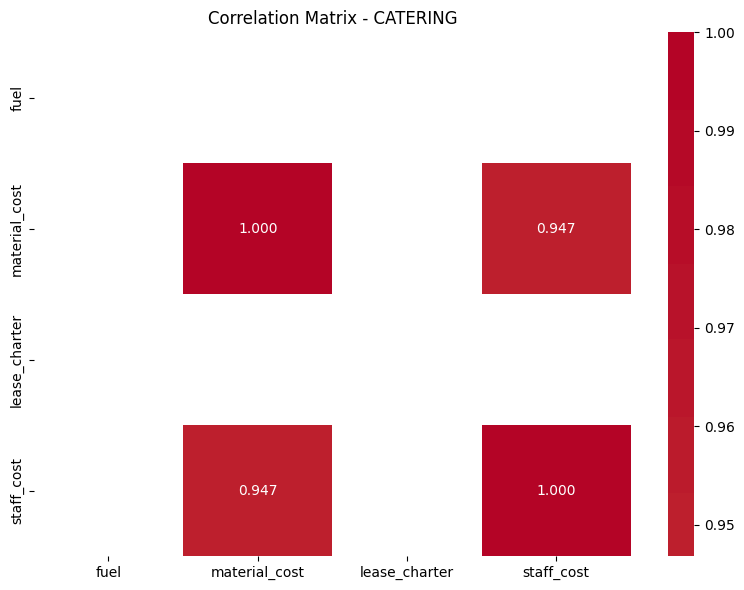


=== PCA Analysis ===
Explained Variance Ratio: [0.9734 0.0266 0.     0.    ]
Cumulative Variance: [0.9734 1.     1.     1.    ]

Loadings Matrix:


PC1    PC2  PC3  PC4
fuel          -0.000 -0.000  0.0  1.0
material_cost  0.707  0.707  0.0  0.0
lease_charter  0.000  0.000  1.0  0.0
staff_cost     0.707 -0.707  0.0  0.0

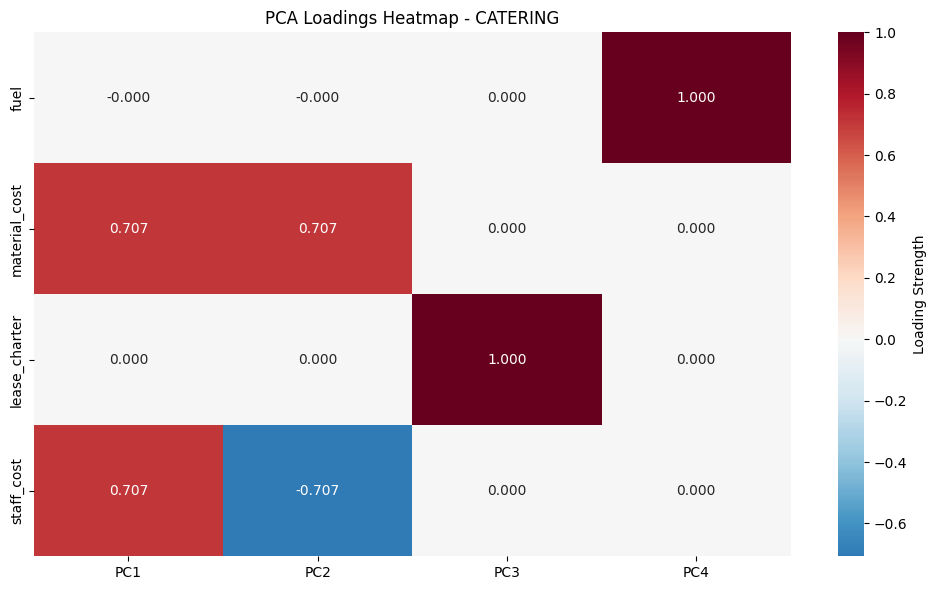

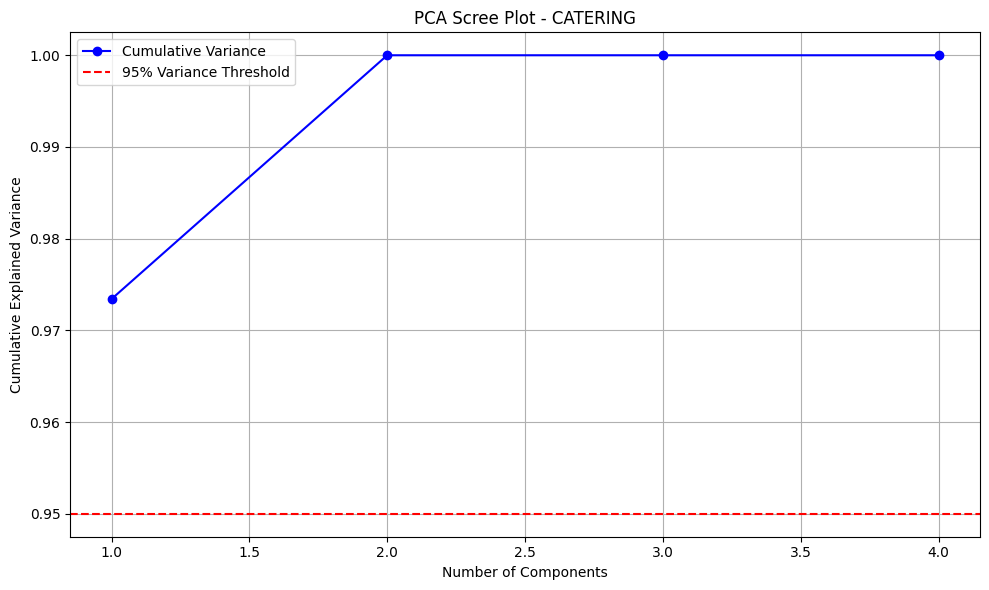


Variance retained with 1 components: 97.3%

=== Correlation Matrix (Principal Components) ===


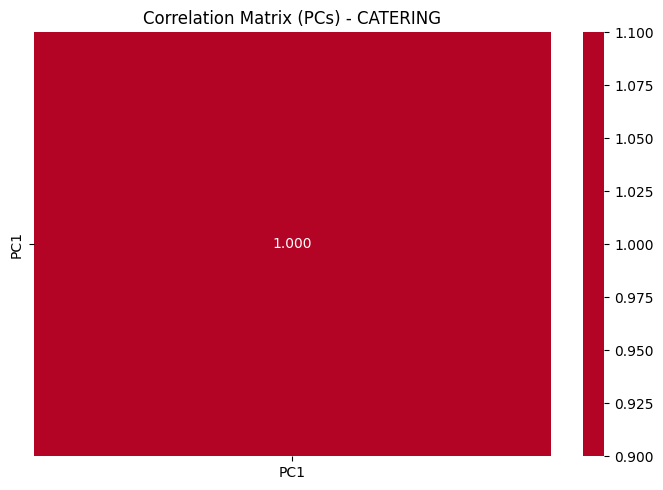


Training set: 8 samples
Test set: 2 samples

=== Variance Inflation Factor (VIF) ===


Feature     VIF
0   const  1.0764
1     PC1  1.0000


=== STATSMODELS OLS REGRESSION ===
                             OLS Regression Results                            
Dep. Variable:     adjusted_ebit_marge   R-squared:                       0.036
Model:                             OLS   Adj. R-squared:                 -0.125
Method:                  Least Squares   F-statistic:                    0.2230
Date:                 Sat, 22 Nov 2025   Prob (F-statistic):              0.653
Time:                         23:43:48   Log-Likelihood:                 24.889
No. Observations:                    8   AIC:                            -45.78
Df Residuals:                        6   BIC:                            -45.62
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

Statistic     Value
0                                   R²    0.0358
1                          Adjusted R²   -0.1249
2                          F-statistic    0.2230
3                  F-statistic p-value    0.6535
4                                  AIC  -45.7780
5                                  BIC  -45.6191
6                        Durbin-Watson    2.1550
7             Shapiro-Wilk (normality)    0.8850
8                 Shapiro-Wilk p-value    0.2102
9   Breusch-Pagan (heteroscedasticity)    1.2808
10               Breusch-Pagan p-value    0.2577


=== Advanced Residual Analysis ===


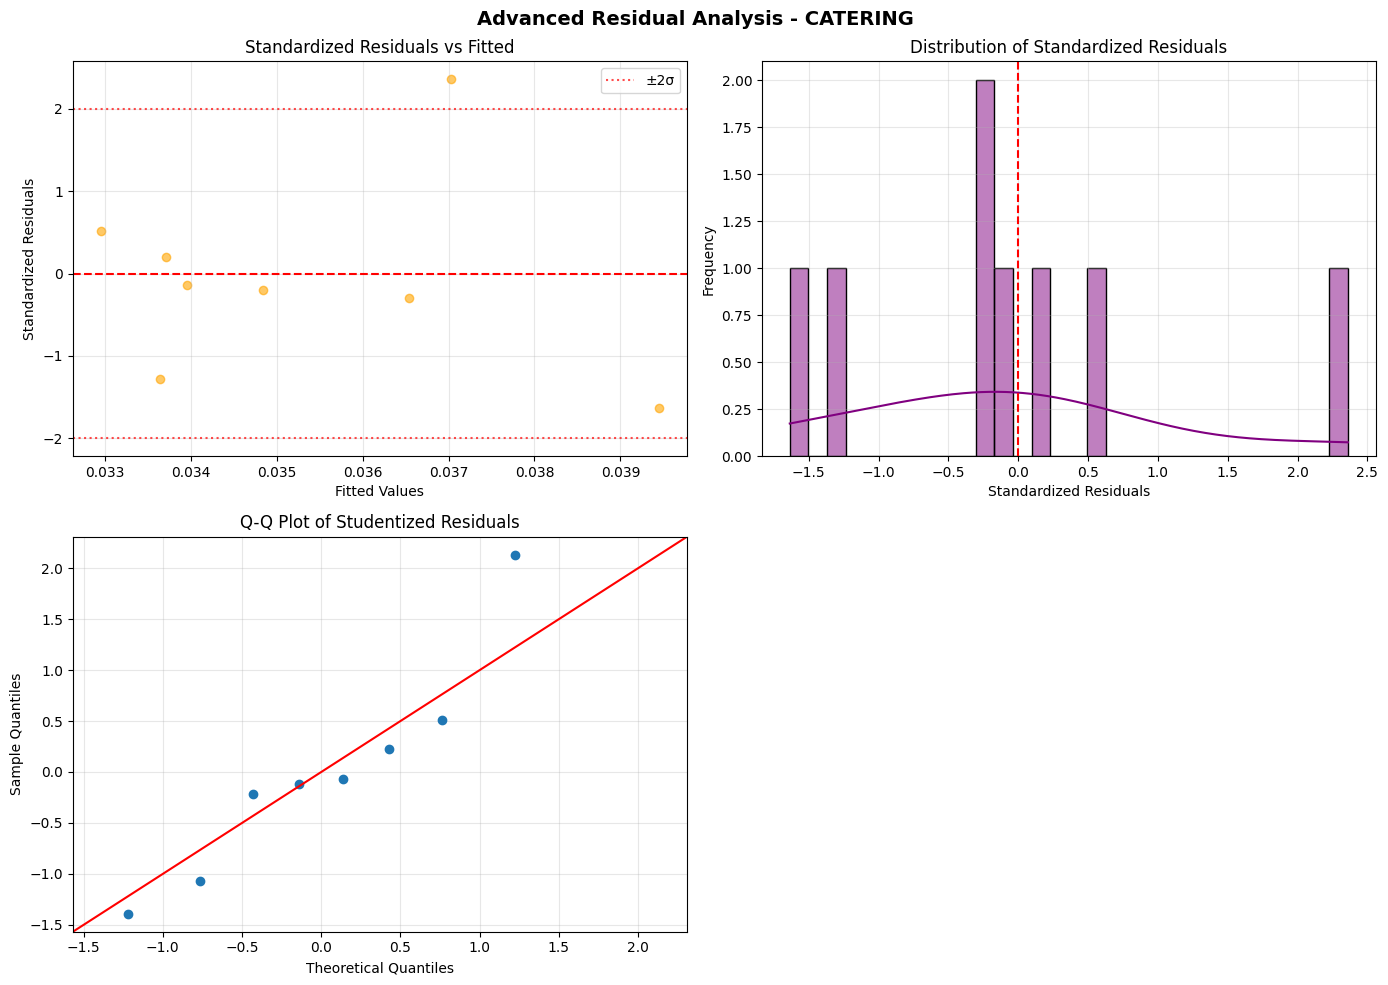


=== Diagnostic Plots (Test Set) ===


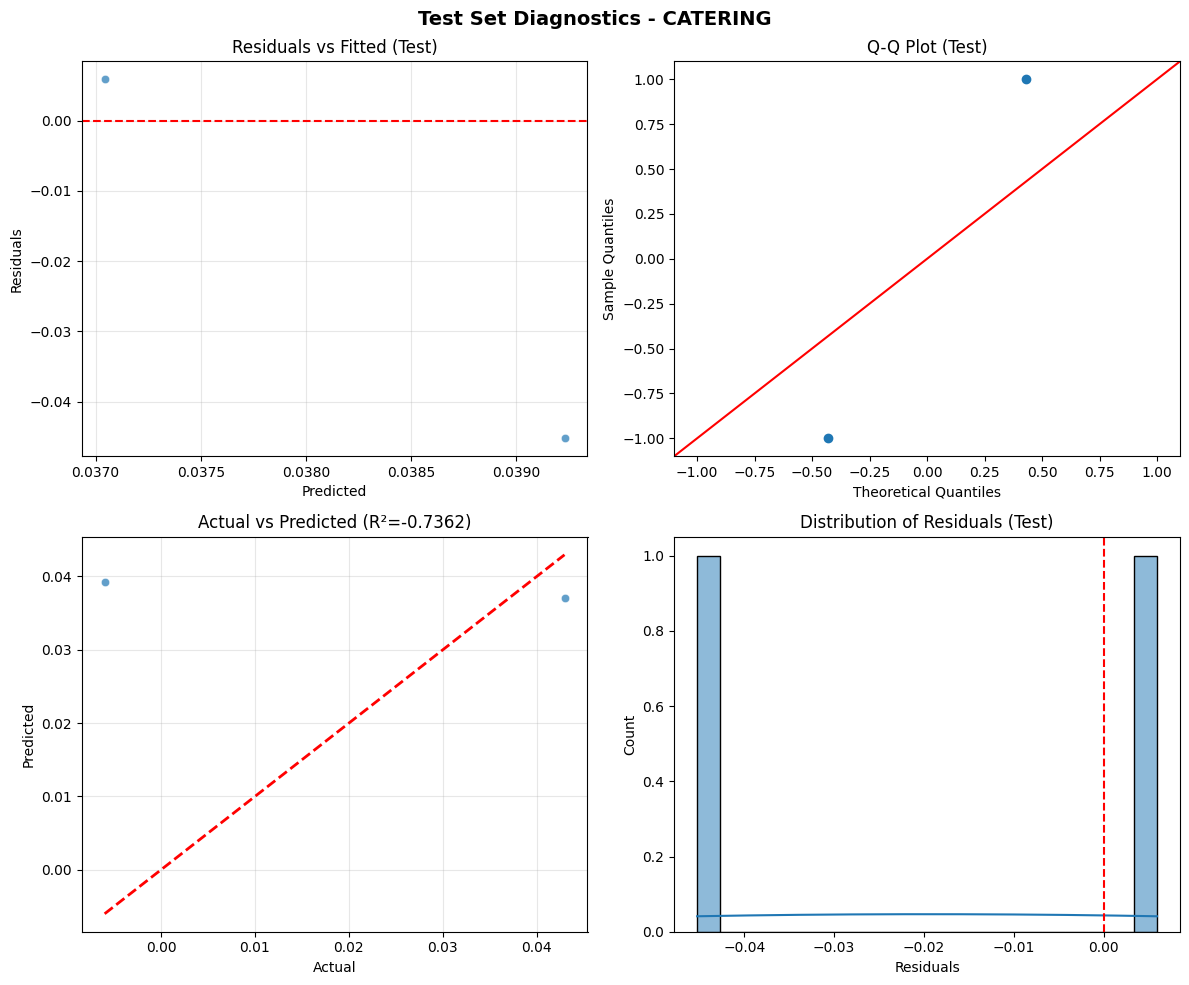


=== Coefficient Confidence Intervals ===


Feature  Coefficient  Std_Error  t_Value  p_Value  CI_Lower  CI_Upper  \
const   const       0.0358     0.0046   7.8493   0.0002    0.0247    0.0470   
PC1       PC1       0.0016     0.0034   0.4722   0.6535   -0.0067    0.0099   

       Significant  
const         True  
PC1          False

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


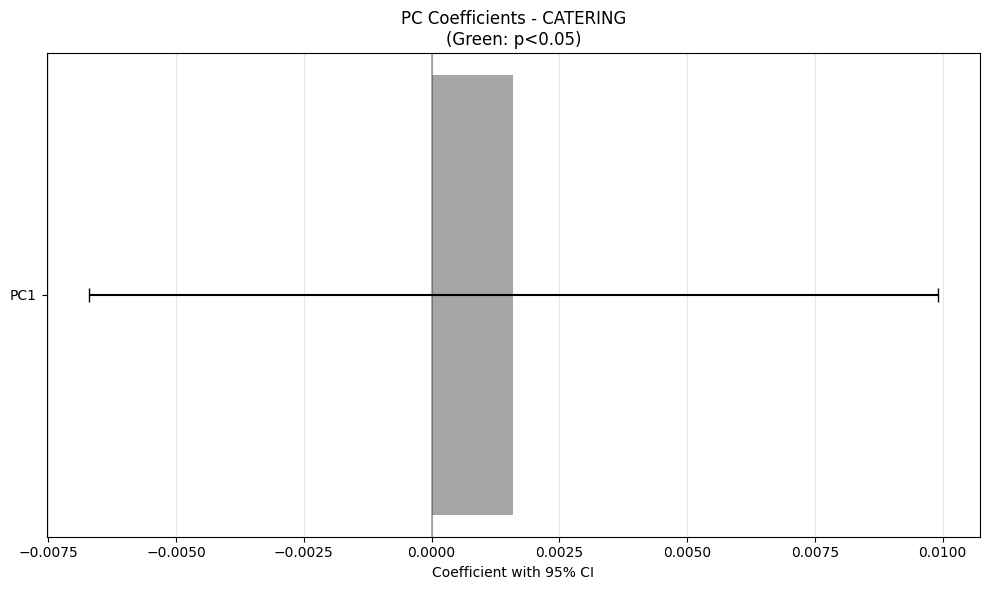


=== FINAL MODEL SUMMARY - CATERING ===


Model  R²_Test  R²_Train    RMSE     MAE      MAPE     AIC      BIC  \
0  PCA + OLS  -0.7362    0.0358  0.0323  0.0256  383.8135 -45.778 -45.6191   

   N_Components  N_Train  N_Test  
0             1        8       2

In [ ]:
# @title
segment = 'catering'
linear_numerical_vars = ['fuel', 'material_cost', 'lease_charter', 'staff_cost']
linear_dependent_var = 'adjusted_ebit_marge'
segment_col = 'segment'

df_segment_filtered = df_segment[df_segment['period_type'] != 'covid_shock'].copy()
df_seg = df_segment_filtered[df_segment_filtered[segment_col] == segment].copy()


print(f"SEGMENT: {segment.upper()}")

X_lr_original = df_seg[linear_numerical_vars].copy()
y_lr = df_seg[linear_dependent_var]

print(f"\n Correlation Matrix")
plt.figure(figsize=(8, 6))
sns.heatmap(X_lr_original.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title(f"Correlation Matrix - {segment.upper()}")
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lr_original)

pca_full = PCA()
pca_full.fit_transform(X_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n PCA Analysis")
print("Explained Variance Ratio:", explained_variance.round(4))
print("Cumulative Variance:", cumulative_variance.round(4))

loadings_full = pd.DataFrame(
    pca_full.components_.T,
    columns=[f'PC{i+1}' for i in range(pca_full.n_components_)],
    index=X_lr_original.columns
)
print(f"\nLoadings Matrix:")
display(loadings_full.round(3))

plt.figure(figsize=(10, 6))
sns.heatmap(loadings_full, annot=True, cmap='RdBu_r', center=0, fmt='.3f',
            cbar_kws={'label': 'Loading Strength'})
plt.title(f'PCA Loadings Heatmap - {segment.upper()}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title(f'PCA Scree Plot - {segment.upper()}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

n_components = min(3, np.argmax(cumulative_variance >= 0.95) + 1)
if cumulative_variance[n_components-1] < 0.95 and n_components < len(linear_numerical_vars):
    n_components = min(3, len(linear_numerical_vars))

pca = PCA(n_components=n_components)
X_lr = pd.DataFrame(
    pca.fit_transform(X_scaled),
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X_lr_original.index
)

print(f"\n Correlation Matrix ")
plt.figure(figsize=(7, 5))
sns.heatmap(X_lr.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title(f"Correlation Matrix - {segment.upper()}")
plt.tight_layout()
plt.show()

test_size = max(0.2, 2/len(X_lr))
X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=test_size, random_state=42)
print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

X_train_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame({
    "Feature": X_train_vif.columns,
    "VIF": [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
})
print(f"\n Variance Inflation Factor (VIF)")
display(vif_data.round(4))

print(f"\n STATSMODELS")
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_sm)
results = model.fit()
print(results.summary())

y_pred = results.predict(X_test_sm)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
valid_mape_idx = y_test != 0
mape = np.mean(np.abs((y_test[valid_mape_idx] - y_pred[valid_mape_idx]) / y_test[valid_mape_idx])) * 100 if np.sum(valid_mape_idx) > 0 else np.nan

residuals_train = y_train - results.predict(X_train_sm)
shapiro_stat, shapiro_p = stats.shapiro(residuals_train) if len(residuals_train) >= 3 else (np.nan, np.nan)
bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals_train, X_train_sm)
dw_stat = durbin_watson(residuals_train)

gof_df = pd.DataFrame({
    "Statistic": ["R²", "Adjusted R²", "F-statistic", "F-statistic p-value", "AIC", "BIC",
                  "Durbin-Watson", "Shapiro-Wilk (normality)", "Shapiro-Wilk p-value",
                  "Breusch-Pagan (heteroscedasticity)", "Breusch-Pagan p-value"],
    "Value": [f"{results.rsquared:.4f}", f"{results.rsquared_adj:.4f}", f"{results.fvalue:.4f}",
              f"{results.f_pvalue:.4f}", f"{results.aic:.4f}", f"{results.bic:.4f}",
              f"{dw_stat:.4f}", f"{shapiro_stat:.4f}", f"{shapiro_p:.4f}",
              f"{bp_stat:.4f}", f"{bp_pvalue:.4f}"]
})
print(f"\n Goodness-of-Fit")
display(gof_df)

print(f"\n Advanced Residual Analysis ")
leverage = results.get_influence().hat_matrix_diag
resid_std = residuals_train / (results.resid.std() * np.sqrt(1 - leverage))
resid_student = OLSInfluence(results).resid_studentized

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Residual Analysis - {segment.upper()}', fontsize=14, fontweight='bold')

axes[0, 0].scatter(results.fittedvalues, resid_std, alpha=0.6, color='orange')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].axhline(y=2, color='red', linestyle=':', alpha=0.7, label='±2σ')
axes[0, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.7)
axes[0, 0].set_xlabel('Fitted Values'); axes[0, 0].set_ylabel('Standardized Residuals')
axes[0, 0].set_title('Standardized Residuals vs Fitted'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

sns.histplot(resid_std, bins=30, kde=True, ax=axes[0, 1], color='purple')
axes[0, 1].axvline(x=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Standardized Residuals'); axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Standardized Residuals'); axes[0, 1].grid(True, alpha=0.3)

sm.qqplot(resid_student, line='45', fit=True, ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Studentized Residuals'); axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_visible(False)
plt.tight_layout(); plt.show()

print(f"\n Diagnostic Plots for Test Set ")
residuals_test = y_test - y_pred

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'Test Set Diagnostics - {segment.upper()}', fontsize=14, fontweight='bold')

sns.scatterplot(x=y_pred, y=residuals_test, alpha=0.7, ax=axes[0, 0])
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Predicted'); axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted (Test)'); axes[0, 0].grid(True, alpha=0.3)

sm.qqplot(residuals_test, line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Test)')

sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, ax=axes[1, 0])
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Actual'); axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title(f'Actual vs Predicted (R²={r2_test:.4f})'); axes[1, 0].grid(True, alpha=0.3)

sns.histplot(residuals_test, kde=True, bins=20, ax=axes[1, 1])
axes[1, 1].axvline(x=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Residuals'); axes[1, 1].set_title('Distribution of Residuals (Test)')
plt.tight_layout(); plt.show()

print(f"\n Coefficient Confidence Intervals ")
conf_int = results.conf_int()
conf_int.columns = ['CI_Lower', 'CI_Upper']

coef_summary = pd.DataFrame({
    'Feature': results.params.index, 'Coefficient': results.params.values,
    'Std_Error': results.bse.values, 't_Value': results.tvalues.values,
    'p_Value': results.pvalues.values, 'CI_Lower': conf_int['CI_Lower'],
    'CI_Upper': conf_int['CI_Upper'], 'Significant': results.pvalues.values < 0.05
}).round(4)
display(coef_summary)

sig_coefs = coef_summary[coef_summary['Feature'] != 'const'].sort_values('Coefficient')
plt.figure(figsize=(10, 6))
colors = ['green' if sig else 'gray' for sig in sig_coefs['Significant']]
plt.barh(range(len(sig_coefs)), sig_coefs['Coefficient'],
         xerr=[sig_coefs['Coefficient'] - sig_coefs['CI_Lower'],
               sig_coefs['CI_Upper'] - sig_coefs['Coefficient']], color=colors, alpha=0.7, capsize=5)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.yticks(range(len(sig_coefs)), sig_coefs['Feature'])
plt.xlabel('Coefficient with 95% CI'); plt.title(f'PC Coefficients - {segment.upper()}\n(Green: p<0.05)')
plt.grid(axis='x', alpha=0.3); plt.tight_layout(); plt.show()

print(f"\n MODEL SUMMARY - {segment.upper()}")
summary = pd.DataFrame({
    'Model': ['PCA + OLS'], 'R²_Test': [r2_test], 'R²_Train': [results.rsquared],
    'RMSE': [rmse], 'MAE': [mae], 'MAPE': [mape], 'AIC': [results.aic], 'BIC': [results.bic],
    'N_Components': [n_components], 'N_Train': [len(X_train)], 'N_Test': [len(X_test)]
}).round(4)
display(summary)

Since PC1 is not statistically significant, it cannot be used to make valid predictions about Adjusted EBIT margins

##Consolidation

SEGMENT: CONSOLIDATION
Number of observations: 12
Years covered: 2012 - 2025

=== Correlation Matrix ===


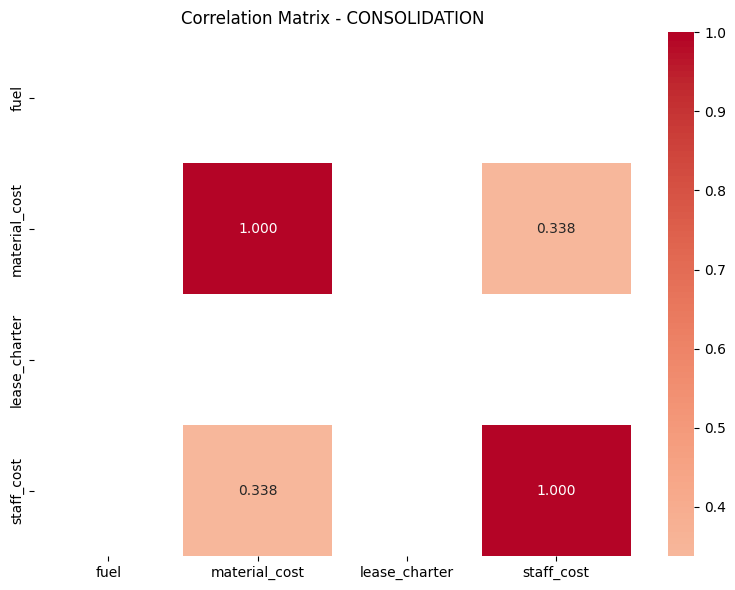


=== PCA Analysis ===
Explained Variance Ratio: [0.6688 0.3312 0.     0.    ]
Cumulative Variance: [0.6688 1.     1.     1.    ]

Loadings Matrix:


PC1    PC2  PC3  PC4
fuel           0.000  0.000  0.0  1.0
material_cost  0.707  0.707  0.0  0.0
lease_charter  0.000 -0.000  1.0  0.0
staff_cost     0.707 -0.707  0.0  0.0

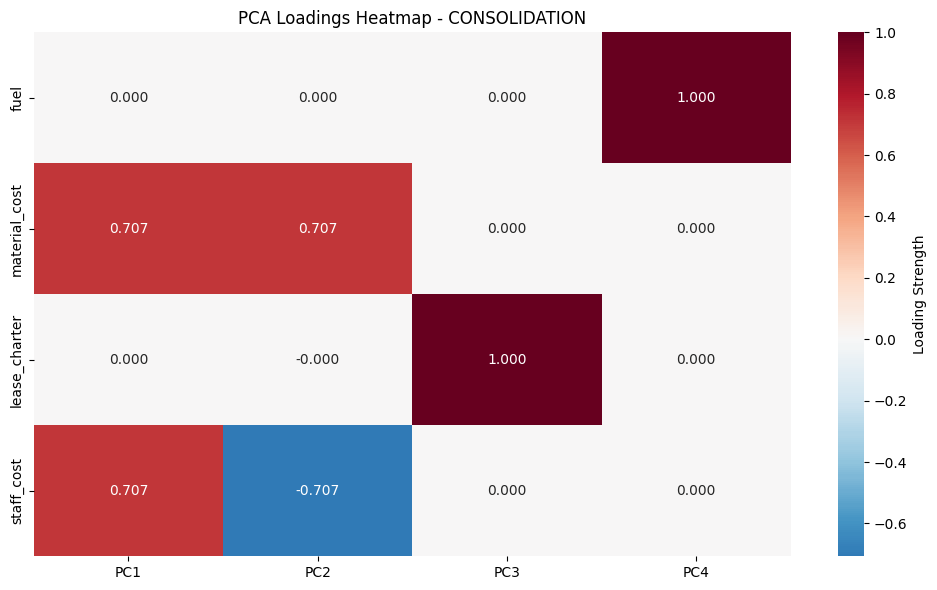

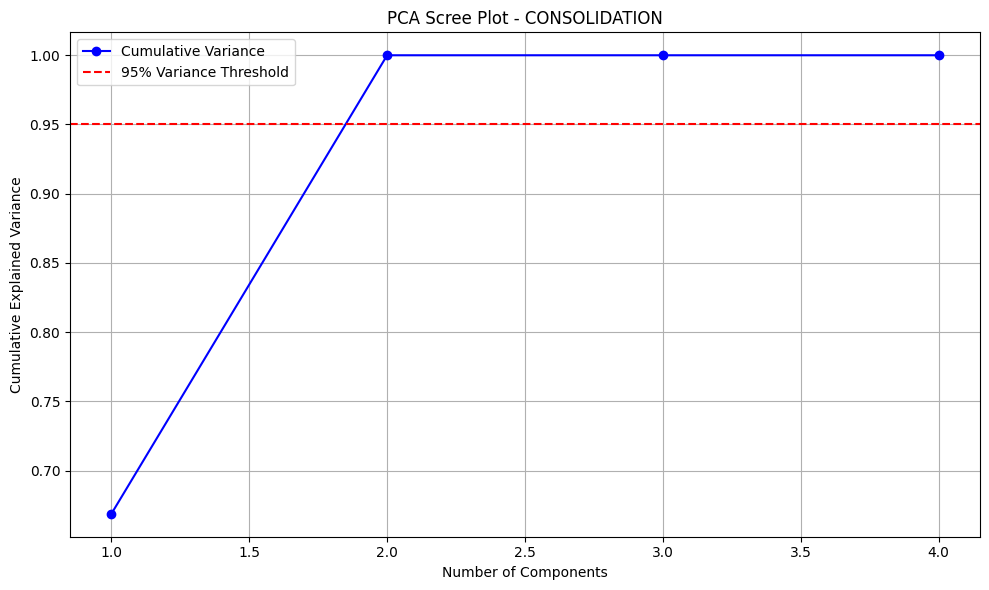


Variance retained with 2 components: 100.0%

=== Correlation Matrix (Principal Components) ===


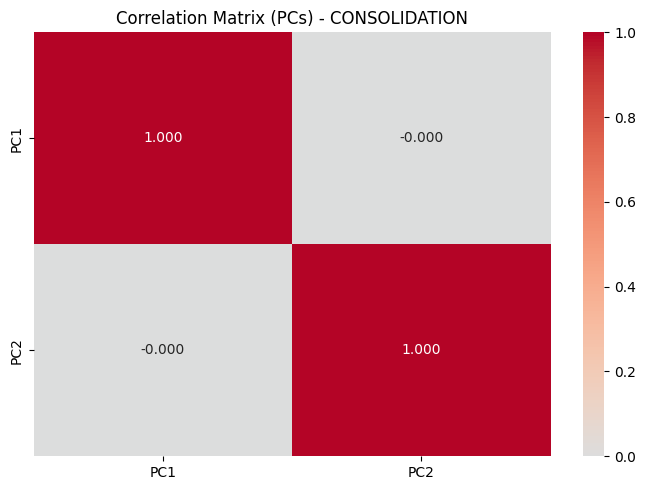


Training set: 9 samples
Test set: 3 samples

=== Variance Inflation Factor (VIF) ===


Feature         VIF
0   const   5818.6533
1     PC1  18124.8844
2     PC2  18124.8844


=== STATSMODELS OLS REGRESSION ===
                             OLS Regression Results                            
Dep. Variable:     adjusted_ebit_marge   R-squared:                       0.872
Model:                             OLS   Adj. R-squared:                  0.830
Method:                  Least Squares   F-statistic:                     20.48
Date:                 Sat, 22 Nov 2025   Prob (F-statistic):            0.00209
Time:                         23:45:27   Log-Likelihood:                 42.465
No. Observations:                    9   AIC:                            -78.93
Df Residuals:                        6   BIC:                            -78.34
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

Statistic     Value
0                                   R²    0.8722
1                          Adjusted R²    0.8297
2                          F-statistic   20.4828
3                  F-statistic p-value    0.0021
4                                  AIC  -78.9299
5                                  BIC  -78.3382
6                        Durbin-Watson    2.4260
7             Shapiro-Wilk (normality)    0.9524
8                 Shapiro-Wilk p-value    0.7164
9   Breusch-Pagan (heteroscedasticity)    2.4925
10               Breusch-Pagan p-value    0.2876


=== Advanced Residual Analysis ===


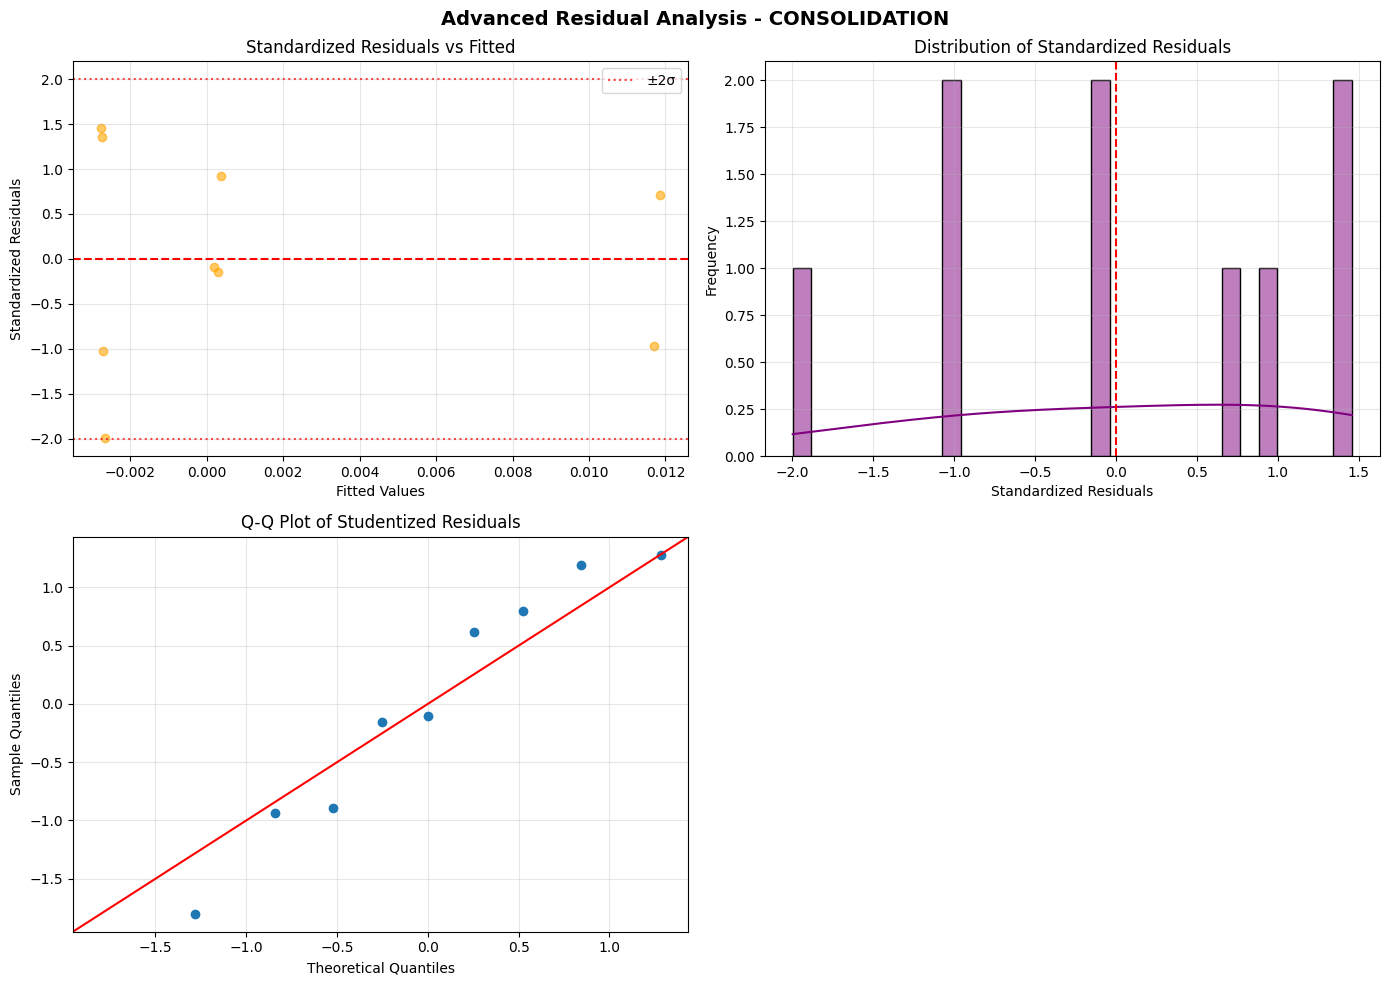


=== Diagnostic Plots (Test Set) ===


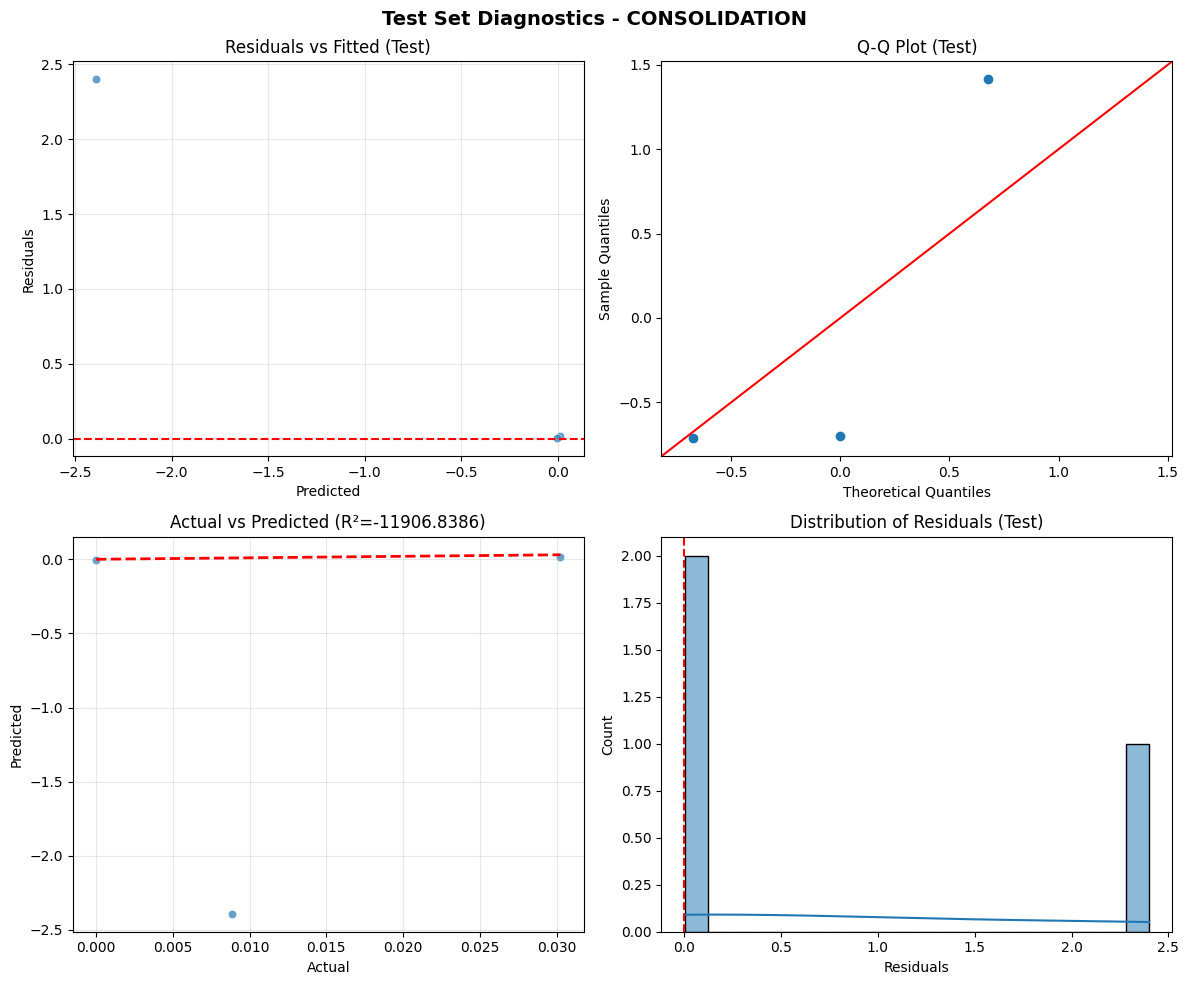


=== Coefficient Confidence Intervals ===


Feature  Coefficient  Std_Error  t_Value  p_Value  CI_Lower  CI_Upper  \
const   const      -0.1971     0.0673  -2.9292   0.0263   -0.3618   -0.0325   
PC1       PC1      -0.4677     0.1575  -2.9690   0.0250   -0.8532   -0.0822   
PC2       PC2       0.4679     0.1599   2.9268   0.0264    0.0767    0.8591   

       Significant  
const         True  
PC1           True  
PC2           True

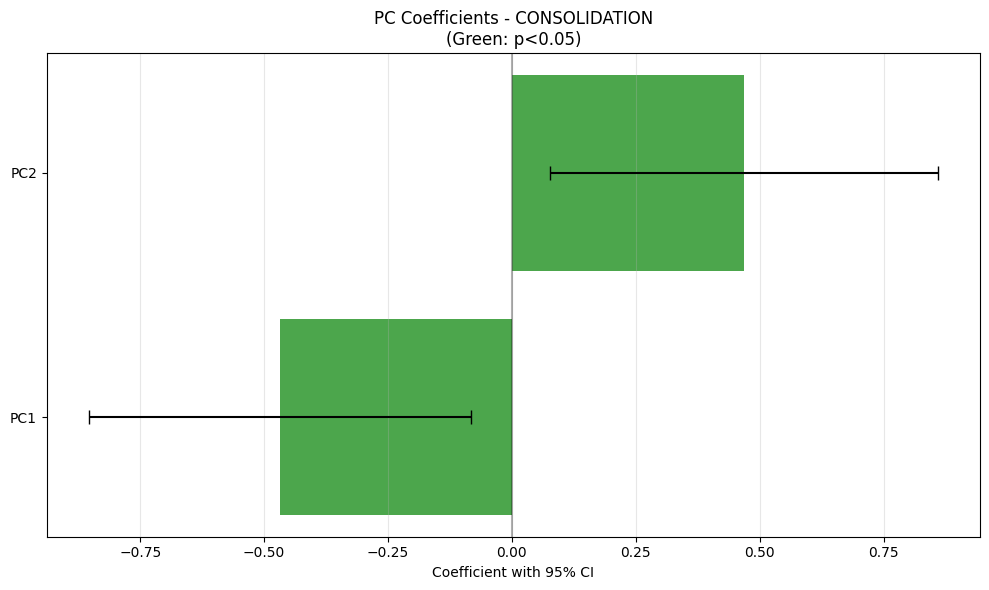


=== FINAL MODEL SUMMARY - CONSOLIDATION ===


Model     R²_Test  R²_Train    RMSE    MAE        MAPE      AIC  \
0  PCA + OLS -11906.8386    0.8722  1.3856  0.806  13539.0464 -78.9299   

       BIC  N_Components  N_Train  N_Test  
0 -78.3382             2        9       3

In [ ]:
# @title
segment = 'consolidation'
linear_numerical_vars = ['fuel', 'material_cost', 'lease_charter', 'staff_cost']
linear_dependent_var = 'adjusted_ebit_marge'
segment_col = 'segment'

df_segment_filtered = df_segment[df_segment['period_type'] != 'covid_shock'].copy()
df_seg = df_segment_filtered[df_segment_filtered[segment_col] == segment].copy()


print(f"SEGMENT: {segment.upper()}")

X_lr_original = df_seg[linear_numerical_vars].copy()
y_lr = df_seg[linear_dependent_var]

print(f"\n Correlation Matrix")
plt.figure(figsize=(8, 6))
sns.heatmap(X_lr_original.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title(f"Correlation Matrix - {segment.upper()}")
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lr_original)

pca_full = PCA()
pca_full.fit_transform(X_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n PCA Analysis")
print("Explained Variance Ratio:", explained_variance.round(4))
print("Cumulative Variance:", cumulative_variance.round(4))

loadings_full = pd.DataFrame(
    pca_full.components_.T,
    columns=[f'PC{i+1}' for i in range(pca_full.n_components_)],
    index=X_lr_original.columns
)
print(f"\nLoadings Matrix:")
display(loadings_full.round(3))

plt.figure(figsize=(10, 6))
sns.heatmap(loadings_full, annot=True, cmap='RdBu_r', center=0, fmt='.3f',
            cbar_kws={'label': 'Loading Strength'})
plt.title(f'PCA Loadings Heatmap - {segment.upper()}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title(f'PCA Scree Plot - {segment.upper()}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

n_components = min(3, np.argmax(cumulative_variance >= 0.95) + 1)
if cumulative_variance[n_components-1] < 0.95 and n_components < len(linear_numerical_vars):
    n_components = min(3, len(linear_numerical_vars))

pca = PCA(n_components=n_components)
X_lr = pd.DataFrame(
    pca.fit_transform(X_scaled),
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X_lr_original.index
)

print(f"\n Correlation Matrix ")
plt.figure(figsize=(7, 5))
sns.heatmap(X_lr.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title(f"Correlation Matrix - {segment.upper()}")
plt.tight_layout()
plt.show()

test_size = max(0.2, 2/len(X_lr))
X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=test_size, random_state=42)
print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

X_train_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame({
    "Feature": X_train_vif.columns,
    "VIF": [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
})
print(f"\n Variance Inflation Factor (VIF)")
display(vif_data.round(4))

print(f"\n STATSMODELS")
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_sm)
results = model.fit()
print(results.summary())

y_pred = results.predict(X_test_sm)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
valid_mape_idx = y_test != 0
mape = np.mean(np.abs((y_test[valid_mape_idx] - y_pred[valid_mape_idx]) / y_test[valid_mape_idx])) * 100 if np.sum(valid_mape_idx) > 0 else np.nan

residuals_train = y_train - results.predict(X_train_sm)
shapiro_stat, shapiro_p = stats.shapiro(residuals_train) if len(residuals_train) >= 3 else (np.nan, np.nan)
bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals_train, X_train_sm)
dw_stat = durbin_watson(residuals_train)

gof_df = pd.DataFrame({
    "Statistic": ["R²", "Adjusted R²", "F-statistic", "F-statistic p-value", "AIC", "BIC",
                  "Durbin-Watson", "Shapiro-Wilk (normality)", "Shapiro-Wilk p-value",
                  "Breusch-Pagan (heteroscedasticity)", "Breusch-Pagan p-value"],
    "Value": [f"{results.rsquared:.4f}", f"{results.rsquared_adj:.4f}", f"{results.fvalue:.4f}",
              f"{results.f_pvalue:.4f}", f"{results.aic:.4f}", f"{results.bic:.4f}",
              f"{dw_stat:.4f}", f"{shapiro_stat:.4f}", f"{shapiro_p:.4f}",
              f"{bp_stat:.4f}", f"{bp_pvalue:.4f}"]
})
print(f"\n Goodness-of-Fit")
display(gof_df)

print(f"\n Advanced Residual Analysis ")
leverage = results.get_influence().hat_matrix_diag
resid_std = residuals_train / (results.resid.std() * np.sqrt(1 - leverage))
resid_student = OLSInfluence(results).resid_studentized

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Residual Analysis - {segment.upper()}', fontsize=14, fontweight='bold')

axes[0, 0].scatter(results.fittedvalues, resid_std, alpha=0.6, color='orange')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].axhline(y=2, color='red', linestyle=':', alpha=0.7, label='±2σ')
axes[0, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.7)
axes[0, 0].set_xlabel('Fitted Values'); axes[0, 0].set_ylabel('Standardized Residuals')
axes[0, 0].set_title('Standardized Residuals vs Fitted'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

sns.histplot(resid_std, bins=30, kde=True, ax=axes[0, 1], color='purple')
axes[0, 1].axvline(x=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Standardized Residuals'); axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Standardized Residuals'); axes[0, 1].grid(True, alpha=0.3)

sm.qqplot(resid_student, line='45', fit=True, ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Studentized Residuals'); axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_visible(False)
plt.tight_layout(); plt.show()

print(f"\n Diagnostic Plots for Test Set ")
residuals_test = y_test - y_pred

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'Test Set Diagnostics - {segment.upper()}', fontsize=14, fontweight='bold')

sns.scatterplot(x=y_pred, y=residuals_test, alpha=0.7, ax=axes[0, 0])
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Predicted'); axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted (Test)'); axes[0, 0].grid(True, alpha=0.3)

sm.qqplot(residuals_test, line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Test)')

sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, ax=axes[1, 0])
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Actual'); axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title(f'Actual vs Predicted (R²={r2_test:.4f})'); axes[1, 0].grid(True, alpha=0.3)

sns.histplot(residuals_test, kde=True, bins=20, ax=axes[1, 1])
axes[1, 1].axvline(x=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Residuals'); axes[1, 1].set_title('Distribution of Residuals (Test)')
plt.tight_layout(); plt.show()

print(f"\n Coefficient Confidence Intervals ")
conf_int = results.conf_int()
conf_int.columns = ['CI_Lower', 'CI_Upper']

coef_summary = pd.DataFrame({
    'Feature': results.params.index, 'Coefficient': results.params.values,
    'Std_Error': results.bse.values, 't_Value': results.tvalues.values,
    'p_Value': results.pvalues.values, 'CI_Lower': conf_int['CI_Lower'],
    'CI_Upper': conf_int['CI_Upper'], 'Significant': results.pvalues.values < 0.05
}).round(4)
display(coef_summary)

sig_coefs = coef_summary[coef_summary['Feature'] != 'const'].sort_values('Coefficient')
plt.figure(figsize=(10, 6))
colors = ['green' if sig else 'gray' for sig in sig_coefs['Significant']]
plt.barh(range(len(sig_coefs)), sig_coefs['Coefficient'],
         xerr=[sig_coefs['Coefficient'] - sig_coefs['CI_Lower'],
               sig_coefs['CI_Upper'] - sig_coefs['Coefficient']], color=colors, alpha=0.7, capsize=5)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.yticks(range(len(sig_coefs)), sig_coefs['Feature'])
plt.xlabel('Coefficient with 95% CI'); plt.title(f'PC Coefficients - {segment.upper()}\n(Green: p<0.05)')
plt.grid(axis='x', alpha=0.3); plt.tight_layout(); plt.show()

print(f"\n MODEL SUMMARY - {segment.upper()}")
summary = pd.DataFrame({
    'Model': ['PCA + OLS'], 'R²_Test': [r2_test], 'R²_Train': [results.rsquared],
    'RMSE': [rmse], 'MAE': [mae], 'MAPE': [mape], 'AIC': [results.aic], 'BIC': [results.bic],
    'N_Components': [n_components], 'N_Train': [len(X_train)], 'N_Test': [len(X_test)]
}).round(4)
display(summary)

**PC1**

p = 0.025

1.   Material Cost → 0.707
2.   Staff Cost → 0.707


PC1 is influenced by core operational costs; the material and staff expenses, which represent the general cost of running day-to-day operations.

PC1 alone captures 66.9% of the total variance explaining most of the cost-driven fluctuations in Adjusted EBITDA Margin for this segment.

It has a coefficient of -0.468 for the regression, implying that an increasing operational costs reduce profit margins.

**PC2**

p = 0.026 statistically significant

1.   Material Cost → 0.707
2.   Staff Cost → -0.707


Like PC1, PC2 is also influenced by core operational costs; the material and staff expenses, which represent the general cost of running day-to-day operations.

PC2 explains the remaining 33.1% of the total cost-driven fluctuations in Adjusted EBITDA Margin for this segment.

It has a coefficient of + 0.468 for the regression, implying that margins increase for scenarios where material and staff cost balance each other.

PC2 captures the relative movement between material and staff cost i.e. when one increases while the other decreases.

The primary drivers for the Consolidation segment’s profitability are material and staff cost. The balance or misalignment between these two cost drivers has a noticible impact.

Cost Optimisation Focus
- Material and Procurement Efficiency
- Workforce Cost Optimisation
- Evaluate staff roles contributing to material costs rise
- Audit staff-to-material cost relationships
- Re-evaluate staffing needs and retain only essential roles

##Logistic

SEGMENT: LOGISTIC
Number of observations: 12
Years covered: 2012 - 2025

=== Correlation Matrix ===


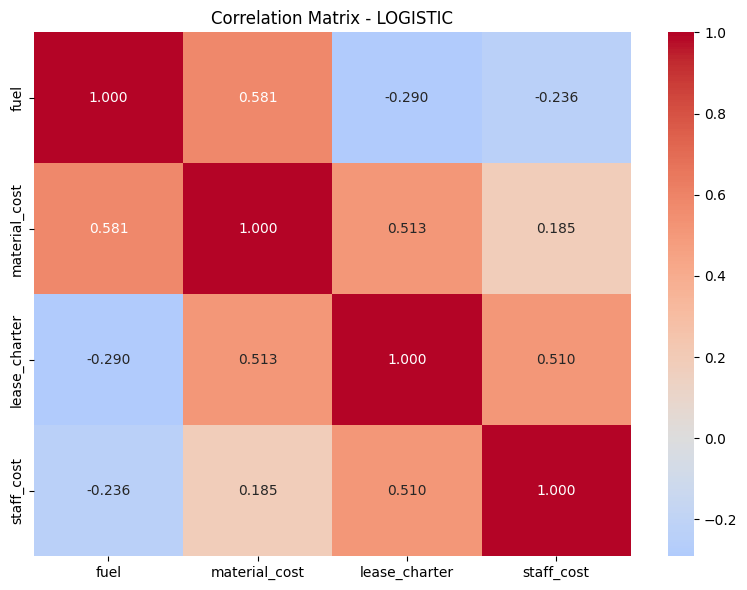


=== PCA Analysis ===
Explained Variance Ratio: [0.4554 0.3911 0.1369 0.0167]
Cumulative Variance: [0.4554 0.8464 0.9833 1.    ]

Loadings Matrix:


PC1    PC2    PC3    PC4
fuel          -0.020  0.768  0.317 -0.555
material_cost  0.521  0.544 -0.172  0.635
lease_charter  0.665 -0.167 -0.493 -0.536
staff_cost     0.535 -0.294  0.791  0.027

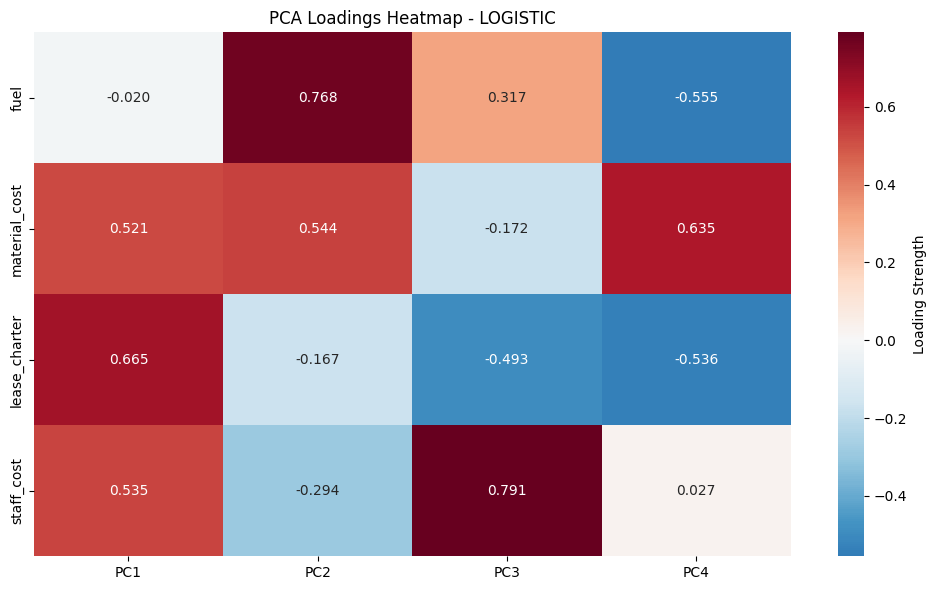

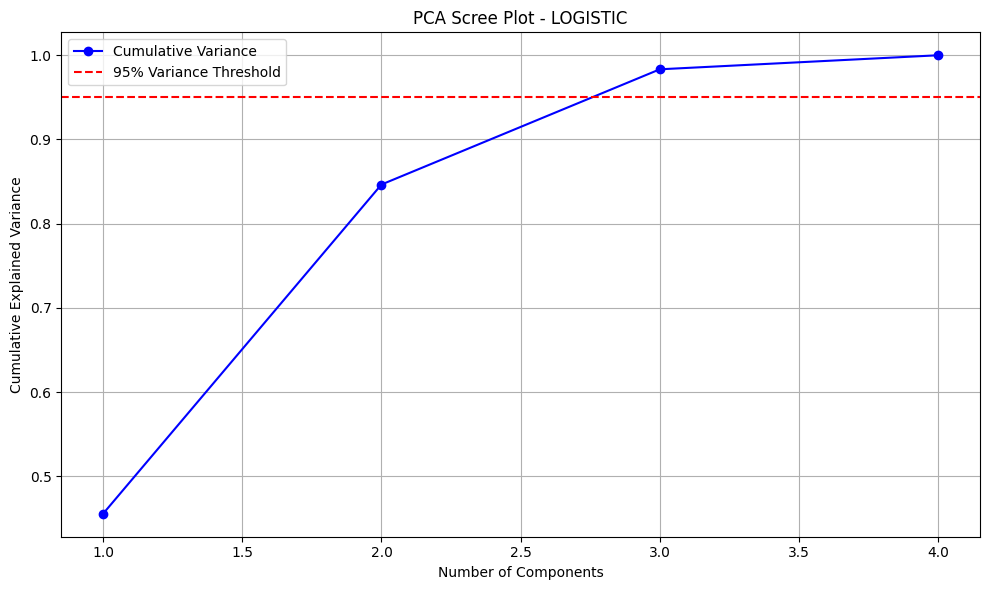


Variance retained with 3 components: 98.3%

=== Correlation Matrix (Principal Components) ===


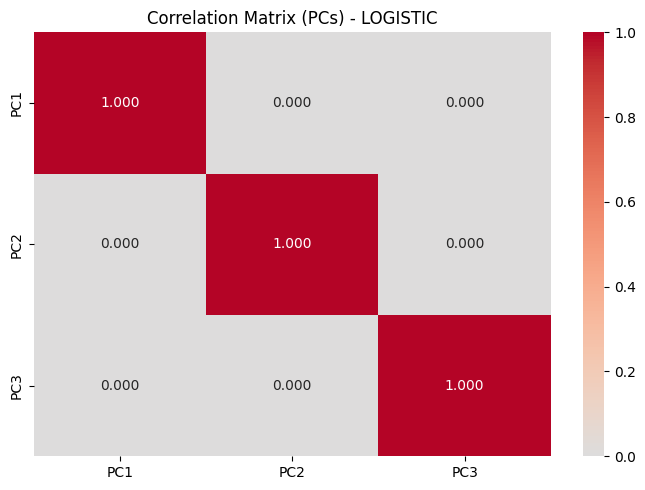


Training set: 9 samples
Test set: 3 samples

=== Variance Inflation Factor (VIF) ===


Feature     VIF
0   const  1.1015
1     PC1  1.0311
2     PC2  1.0368
3     PC3  1.0081


=== STATSMODELS OLS REGRESSION ===
                             OLS Regression Results                            
Dep. Variable:     adjusted_ebit_marge   R-squared:                       0.798
Model:                             OLS   Adj. R-squared:                  0.676
Method:                  Least Squares   F-statistic:                     6.571
Date:                 Sat, 22 Nov 2025   Prob (F-statistic):             0.0347
Time:                         23:46:16   Log-Likelihood:                 14.985
No. Observations:                    9   AIC:                            -21.97
Df Residuals:                        5   BIC:                            -21.18
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

Statistic     Value
0                                   R²    0.7977
1                          Adjusted R²    0.6763
2                          F-statistic    6.5714
3                  F-statistic p-value    0.0347
4                                  AIC  -21.9690
5                                  BIC  -21.1801
6                        Durbin-Watson    2.3543
7             Shapiro-Wilk (normality)    0.8559
8                 Shapiro-Wilk p-value    0.0864
9   Breusch-Pagan (heteroscedasticity)    0.7564
10               Breusch-Pagan p-value    0.8599


=== Advanced Residual Analysis ===


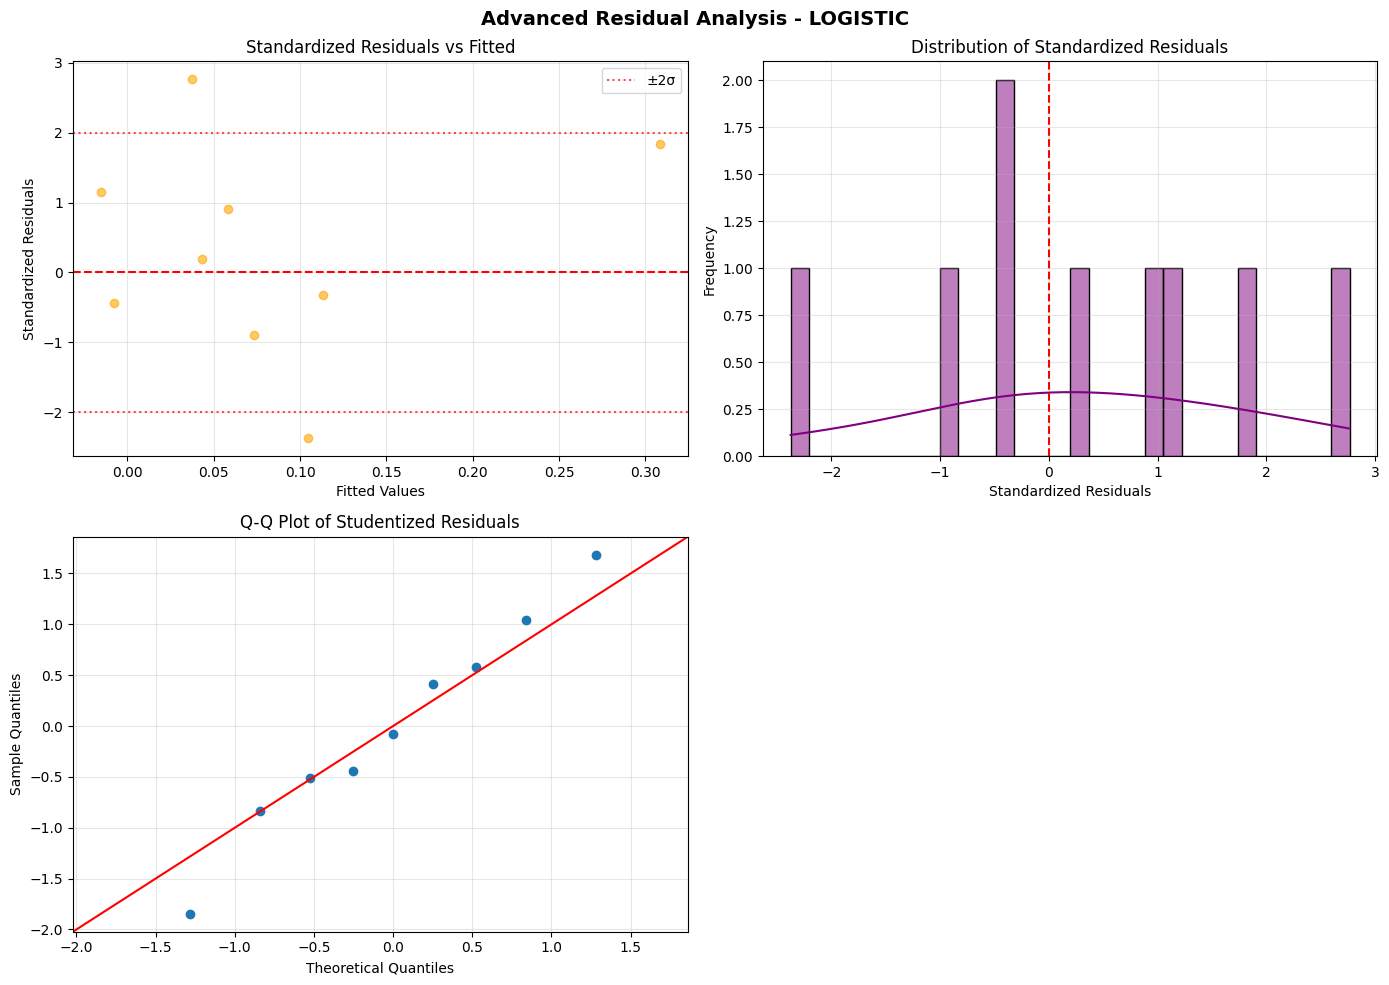


=== Diagnostic Plots (Test Set) ===


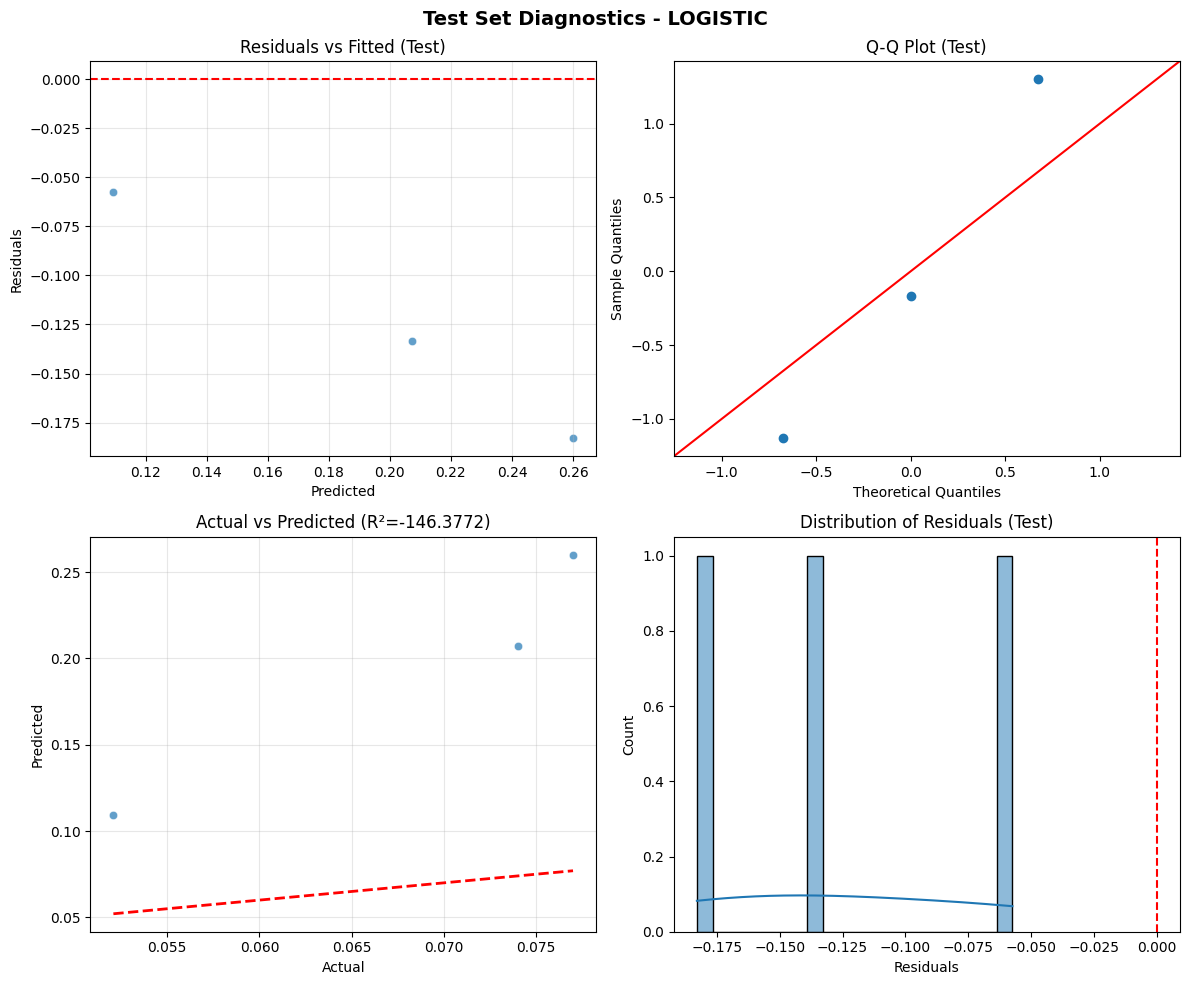


=== Coefficient Confidence Intervals ===


Feature  Coefficient  Std_Error  t_Value  p_Value  CI_Lower  CI_Upper  \
const   const       0.1077     0.0215   5.0103   0.0041    0.0524    0.1629   
PC1       PC1      -0.0610     0.0187  -3.2675   0.0223   -0.1089   -0.0130   
PC2       PC2      -0.0416     0.0175  -2.3738   0.0636   -0.0866    0.0034   
PC3       PC3       0.0124     0.0243   0.5086   0.6327   -0.0501    0.0749   

       Significant  
const         True  
PC1           True  
PC2          False  
PC3          False

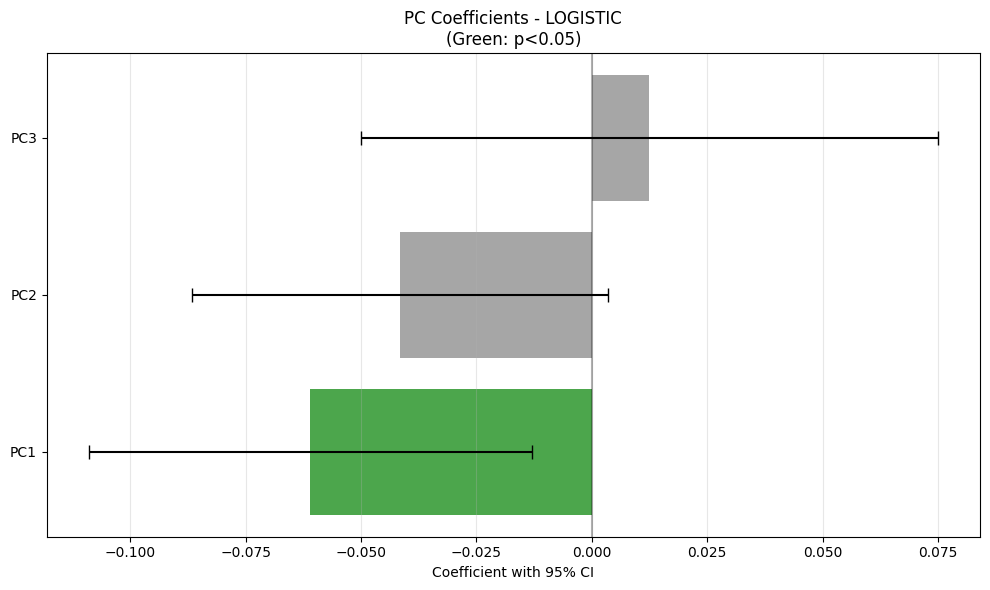


=== FINAL MODEL SUMMARY - LOGISTIC ===


Model   R²_Test  R²_Train    RMSE     MAE      MAPE     AIC      BIC  \
0  PCA + OLS -146.3772    0.7977  0.1348  0.1245  175.9705 -21.969 -21.1801   

   N_Components  N_Train  N_Test  
0             3        9       3

In [ ]:
# @title
segment = 'logistic'
linear_numerical_vars = ['fuel', 'material_cost', 'lease_charter', 'staff_cost']
linear_dependent_var = 'adjusted_ebit_marge'
segment_col = 'segment'

df_segment_filtered = df_segment[df_segment['period_type'] != 'covid_shock'].copy()
df_seg = df_segment_filtered[df_segment_filtered[segment_col] == segment].copy()


print(f"SEGMENT: {segment.upper()}")

X_lr_original = df_seg[linear_numerical_vars].copy()
y_lr = df_seg[linear_dependent_var]

print(f"\n Correlation Matrix")
plt.figure(figsize=(8, 6))
sns.heatmap(X_lr_original.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title(f"Correlation Matrix - {segment.upper()}")
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lr_original)

pca_full = PCA()
pca_full.fit_transform(X_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n PCA Analysis")
print("Explained Variance Ratio:", explained_variance.round(4))
print("Cumulative Variance:", cumulative_variance.round(4))

loadings_full = pd.DataFrame(
    pca_full.components_.T,
    columns=[f'PC{i+1}' for i in range(pca_full.n_components_)],
    index=X_lr_original.columns
)
print(f"\nLoadings Matrix:")
display(loadings_full.round(3))

plt.figure(figsize=(10, 6))
sns.heatmap(loadings_full, annot=True, cmap='RdBu_r', center=0, fmt='.3f',
            cbar_kws={'label': 'Loading Strength'})
plt.title(f'PCA Loadings Heatmap - {segment.upper()}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title(f'PCA Scree Plot - {segment.upper()}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

n_components = min(3, np.argmax(cumulative_variance >= 0.95) + 1)
if cumulative_variance[n_components-1] < 0.95 and n_components < len(linear_numerical_vars):
    n_components = min(3, len(linear_numerical_vars))

pca = PCA(n_components=n_components)
X_lr = pd.DataFrame(
    pca.fit_transform(X_scaled),
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X_lr_original.index
)

print(f"\n Correlation Matrix ")
plt.figure(figsize=(7, 5))
sns.heatmap(X_lr.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title(f"Correlation Matrix - {segment.upper()}")
plt.tight_layout()
plt.show()

test_size = max(0.2, 2/len(X_lr))
X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=test_size, random_state=42)
print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

X_train_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame({
    "Feature": X_train_vif.columns,
    "VIF": [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
})
print(f"\n Variance Inflation Factor (VIF)")
display(vif_data.round(4))

print(f"\n STATSMODELS")
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_sm)
results = model.fit()
print(results.summary())

y_pred = results.predict(X_test_sm)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
valid_mape_idx = y_test != 0
mape = np.mean(np.abs((y_test[valid_mape_idx] - y_pred[valid_mape_idx]) / y_test[valid_mape_idx])) * 100 if np.sum(valid_mape_idx) > 0 else np.nan

residuals_train = y_train - results.predict(X_train_sm)
shapiro_stat, shapiro_p = stats.shapiro(residuals_train) if len(residuals_train) >= 3 else (np.nan, np.nan)
bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals_train, X_train_sm)
dw_stat = durbin_watson(residuals_train)

gof_df = pd.DataFrame({
    "Statistic": ["R²", "Adjusted R²", "F-statistic", "F-statistic p-value", "AIC", "BIC",
                  "Durbin-Watson", "Shapiro-Wilk (normality)", "Shapiro-Wilk p-value",
                  "Breusch-Pagan (heteroscedasticity)", "Breusch-Pagan p-value"],
    "Value": [f"{results.rsquared:.4f}", f"{results.rsquared_adj:.4f}", f"{results.fvalue:.4f}",
              f"{results.f_pvalue:.4f}", f"{results.aic:.4f}", f"{results.bic:.4f}",
              f"{dw_stat:.4f}", f"{shapiro_stat:.4f}", f"{shapiro_p:.4f}",
              f"{bp_stat:.4f}", f"{bp_pvalue:.4f}"]
})
print(f"\n Goodness-of-Fit")
display(gof_df)

print(f"\n Advanced Residual Analysis ")
leverage = results.get_influence().hat_matrix_diag
resid_std = residuals_train / (results.resid.std() * np.sqrt(1 - leverage))
resid_student = OLSInfluence(results).resid_studentized

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Residual Analysis - {segment.upper()}', fontsize=14, fontweight='bold')

axes[0, 0].scatter(results.fittedvalues, resid_std, alpha=0.6, color='orange')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].axhline(y=2, color='red', linestyle=':', alpha=0.7, label='±2σ')
axes[0, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.7)
axes[0, 0].set_xlabel('Fitted Values'); axes[0, 0].set_ylabel('Standardized Residuals')
axes[0, 0].set_title('Standardized Residuals vs Fitted'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

sns.histplot(resid_std, bins=30, kde=True, ax=axes[0, 1], color='purple')
axes[0, 1].axvline(x=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Standardized Residuals'); axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Standardized Residuals'); axes[0, 1].grid(True, alpha=0.3)

sm.qqplot(resid_student, line='45', fit=True, ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Studentized Residuals'); axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_visible(False)
plt.tight_layout(); plt.show()

print(f"\n Diagnostic Plots for Test Set ")
residuals_test = y_test - y_pred

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'Test Set Diagnostics - {segment.upper()}', fontsize=14, fontweight='bold')

sns.scatterplot(x=y_pred, y=residuals_test, alpha=0.7, ax=axes[0, 0])
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Predicted'); axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted (Test)'); axes[0, 0].grid(True, alpha=0.3)

sm.qqplot(residuals_test, line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Test)')

sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, ax=axes[1, 0])
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Actual'); axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title(f'Actual vs Predicted (R²={r2_test:.4f})'); axes[1, 0].grid(True, alpha=0.3)

sns.histplot(residuals_test, kde=True, bins=20, ax=axes[1, 1])
axes[1, 1].axvline(x=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Residuals'); axes[1, 1].set_title('Distribution of Residuals (Test)')
plt.tight_layout(); plt.show()

print(f"\n Coefficient Confidence Intervals ")
conf_int = results.conf_int()
conf_int.columns = ['CI_Lower', 'CI_Upper']

coef_summary = pd.DataFrame({
    'Feature': results.params.index, 'Coefficient': results.params.values,
    'Std_Error': results.bse.values, 't_Value': results.tvalues.values,
    'p_Value': results.pvalues.values, 'CI_Lower': conf_int['CI_Lower'],
    'CI_Upper': conf_int['CI_Upper'], 'Significant': results.pvalues.values < 0.05
}).round(4)
display(coef_summary)

sig_coefs = coef_summary[coef_summary['Feature'] != 'const'].sort_values('Coefficient')
plt.figure(figsize=(10, 6))
colors = ['green' if sig else 'gray' for sig in sig_coefs['Significant']]
plt.barh(range(len(sig_coefs)), sig_coefs['Coefficient'],
         xerr=[sig_coefs['Coefficient'] - sig_coefs['CI_Lower'],
               sig_coefs['CI_Upper'] - sig_coefs['Coefficient']], color=colors, alpha=0.7, capsize=5)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.yticks(range(len(sig_coefs)), sig_coefs['Feature'])
plt.xlabel('Coefficient with 95% CI'); plt.title(f'PC Coefficients - {segment.upper()}\n(Green: p<0.05)')
plt.grid(axis='x', alpha=0.3); plt.tight_layout(); plt.show()

print(f"\n MODEL SUMMARY - {segment.upper()}")
summary = pd.DataFrame({
    'Model': ['PCA + OLS'], 'R²_Test': [r2_test], 'R²_Train': [results.rsquared],
    'RMSE': [rmse], 'MAE': [mae], 'MAPE': [mape], 'AIC': [results.aic], 'BIC': [results.bic],
    'N_Components': [n_components], 'N_Train': [len(X_train)], 'N_Test': [len(X_test)]
}).round(4)
display(summary)

**PC1**

p = 0.022

1. Lease Charter → 0.665
2. Staff Cost → 0.535
3. Material Cost → 0.521

PC1 captures 45.5% of the total variance, making it the single strongest driver of cost-related changes in Adjusted EBITDA Margin for the Logistics segment.

This component represents a broad operational cost block: lease-charter expenses, staff cost, and material procurement.
The regression coefficient of -0.061 indicates that increases in these operational costs directly reduce profit margins.


**PC2**

p = 0.064

ey Loadings

1. Fuel → 0.768
2. Material Cost → 0.544
3. **Staff Cost → -0.294

Although PC2 explains 39.1% of the variance and captures the fuel-driven operational behaviour of the logistic segment, since its statistically insignifant, it is not valid to draw predictions for Adjusted EBIT margins.

**PC3**

p = 0.633


1. Staff Cost → 0.791
2. Fuel → 0.317
3. Lease Charter → -0.493

 PC3 is statistically insignifant and is not valid to draw predictions for Adjusted EBIT margins.


Logistics profitability is primarily driven by lease charter, workforce cost, and material procurement represnted by PC1.


Cost Optimisation Focus

- Operational Cost Efficiency
- Optimise staff deployment
- Lease-charter capacity pooling, renegotiation and dynamic contracting.
- Evaluate material procurement efficiency
- Identify low-value and redundant purchases.



##MRO

SEGMENT: MRO
Number of observations: 12
Years covered: 2012 - 2025

=== Correlation Matrix ===


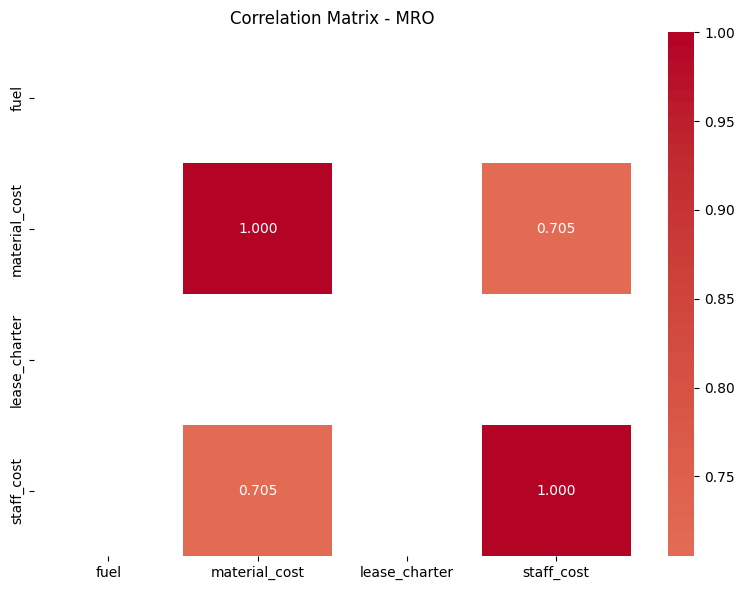


=== PCA Analysis ===
Explained Variance Ratio: [0.8525 0.1475 0.     0.    ]
Cumulative Variance: [0.8525 1.     1.     1.    ]

Loadings Matrix:


PC1    PC2  PC3  PC4
fuel          -0.000  0.000 -0.0  1.0
material_cost  0.707  0.707 -0.0  0.0
lease_charter  0.000  0.000  1.0  0.0
staff_cost     0.707 -0.707 -0.0  0.0

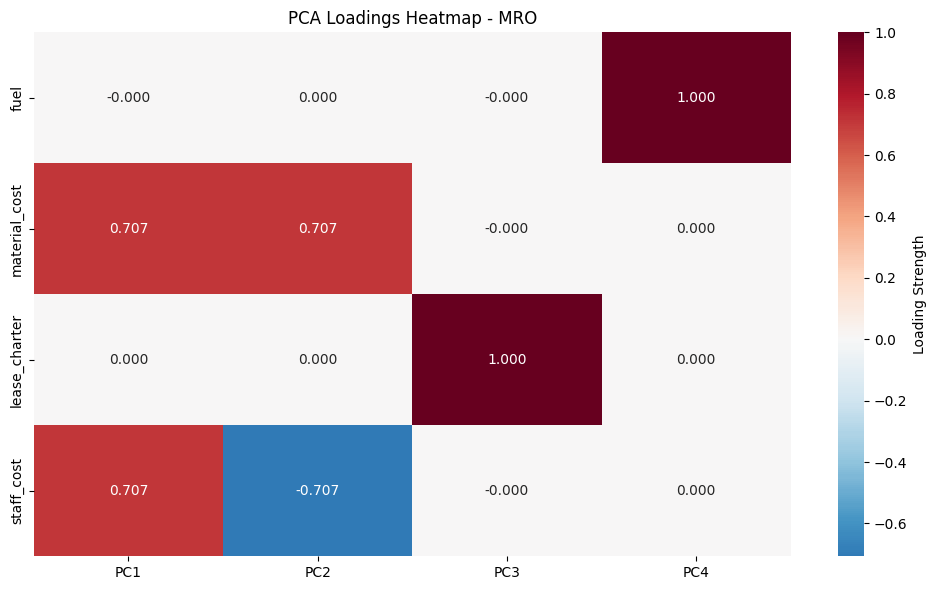

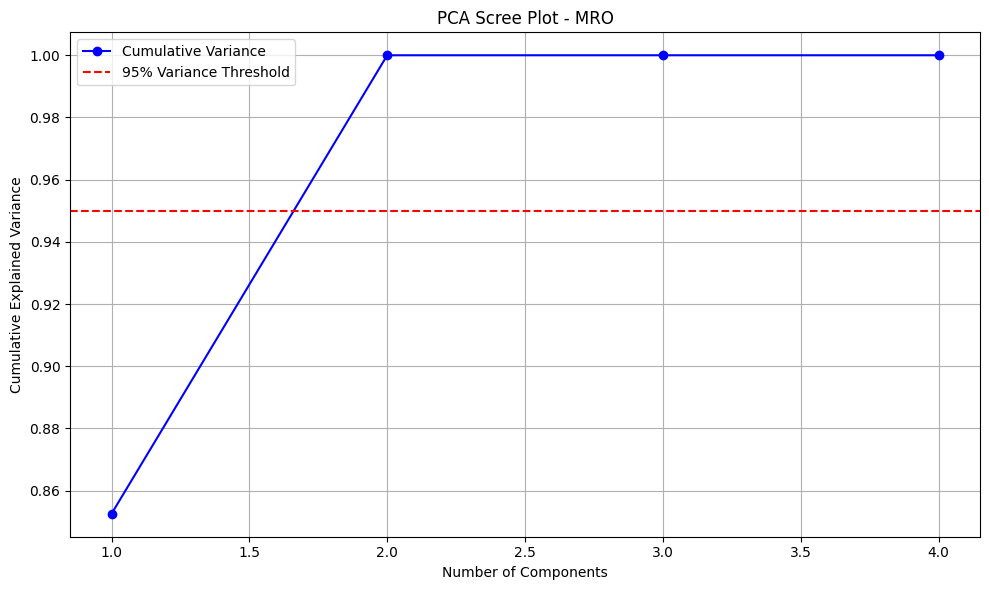


Variance retained with 2 components: 100.0%

=== Correlation Matrix (Principal Components) ===


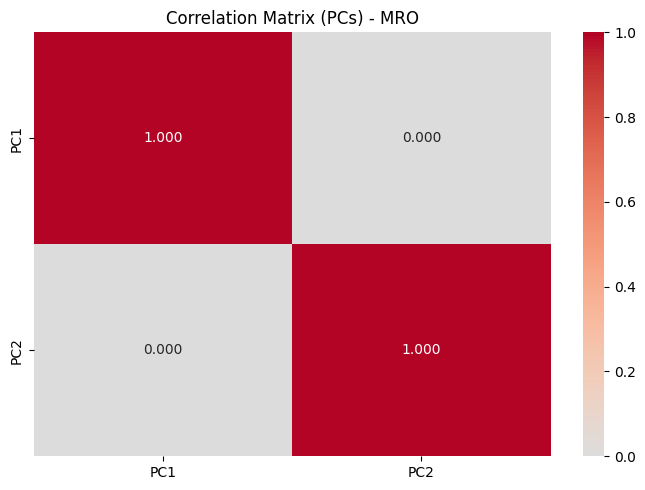


Training set: 9 samples
Test set: 3 samples

=== Variance Inflation Factor (VIF) ===


Feature     VIF
0   const  1.0374
1     PC1  1.0631
2     PC2  1.0631


=== STATSMODELS OLS REGRESSION ===
                             OLS Regression Results                            
Dep. Variable:     adjusted_ebit_marge   R-squared:                       0.588
Model:                             OLS   Adj. R-squared:                  0.451
Method:                  Least Squares   F-statistic:                     4.284
Date:                 Sat, 22 Nov 2025   Prob (F-statistic):             0.0699
Time:                         23:48:19   Log-Likelihood:                 29.622
No. Observations:                    9   AIC:                            -53.24
Df Residuals:                        6   BIC:                            -52.65
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

Statistic     Value
0                                   R²    0.5882
1                          Adjusted R²    0.4509
2                          F-statistic    4.2845
3                  F-statistic p-value    0.0699
4                                  AIC  -53.2435
5                                  BIC  -52.6518
6                        Durbin-Watson    2.2742
7             Shapiro-Wilk (normality)    0.9394
8                 Shapiro-Wilk p-value    0.5757
9   Breusch-Pagan (heteroscedasticity)    4.4431
10               Breusch-Pagan p-value    0.1084


=== Advanced Residual Analysis ===


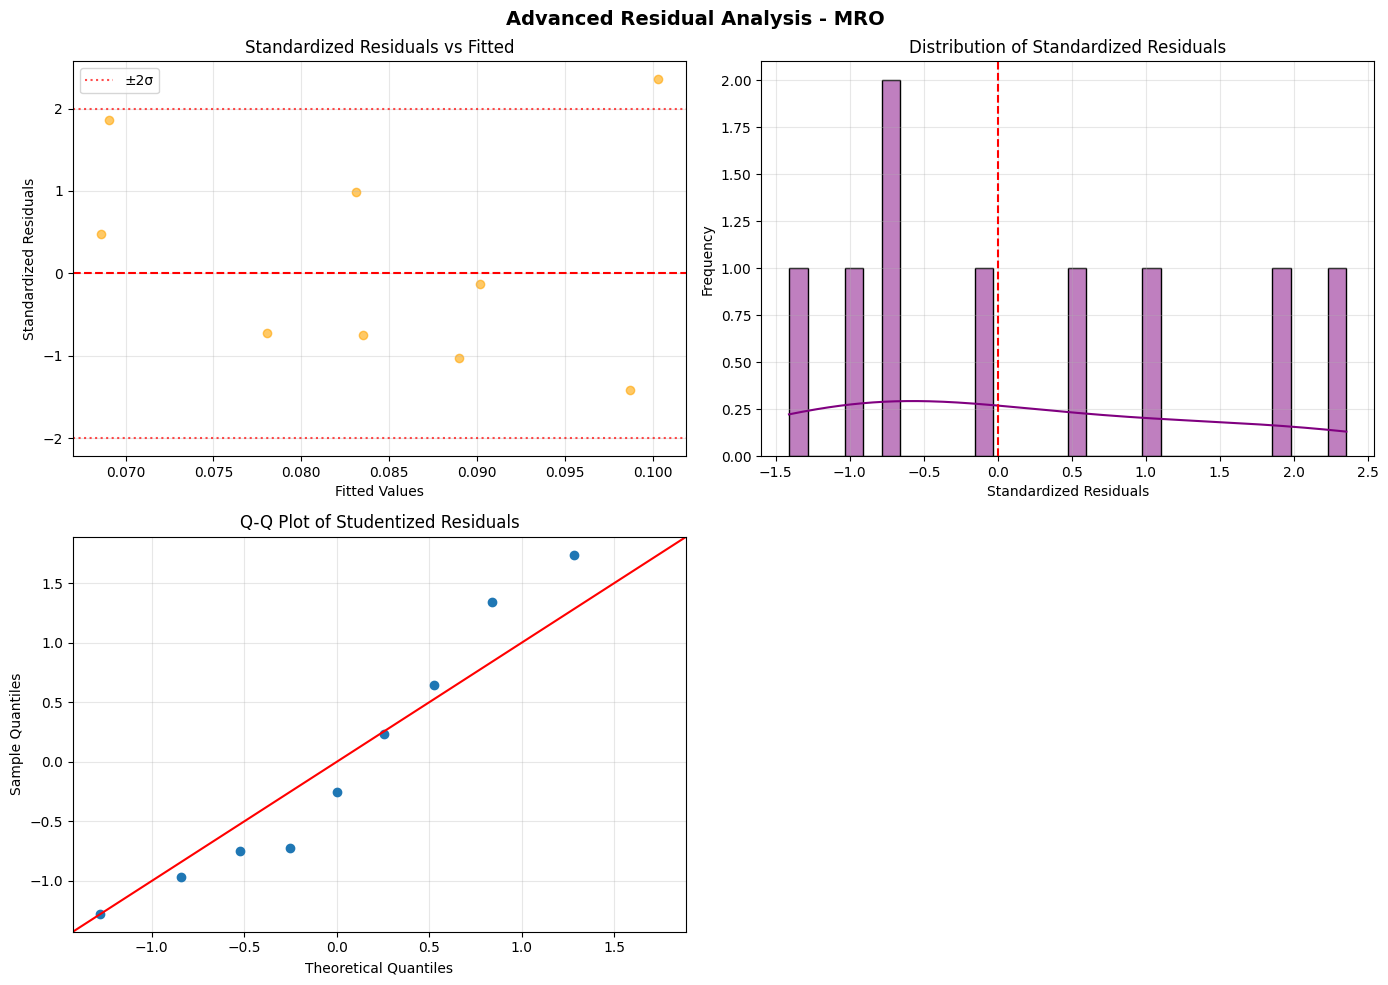


=== Diagnostic Plots (Test Set) ===


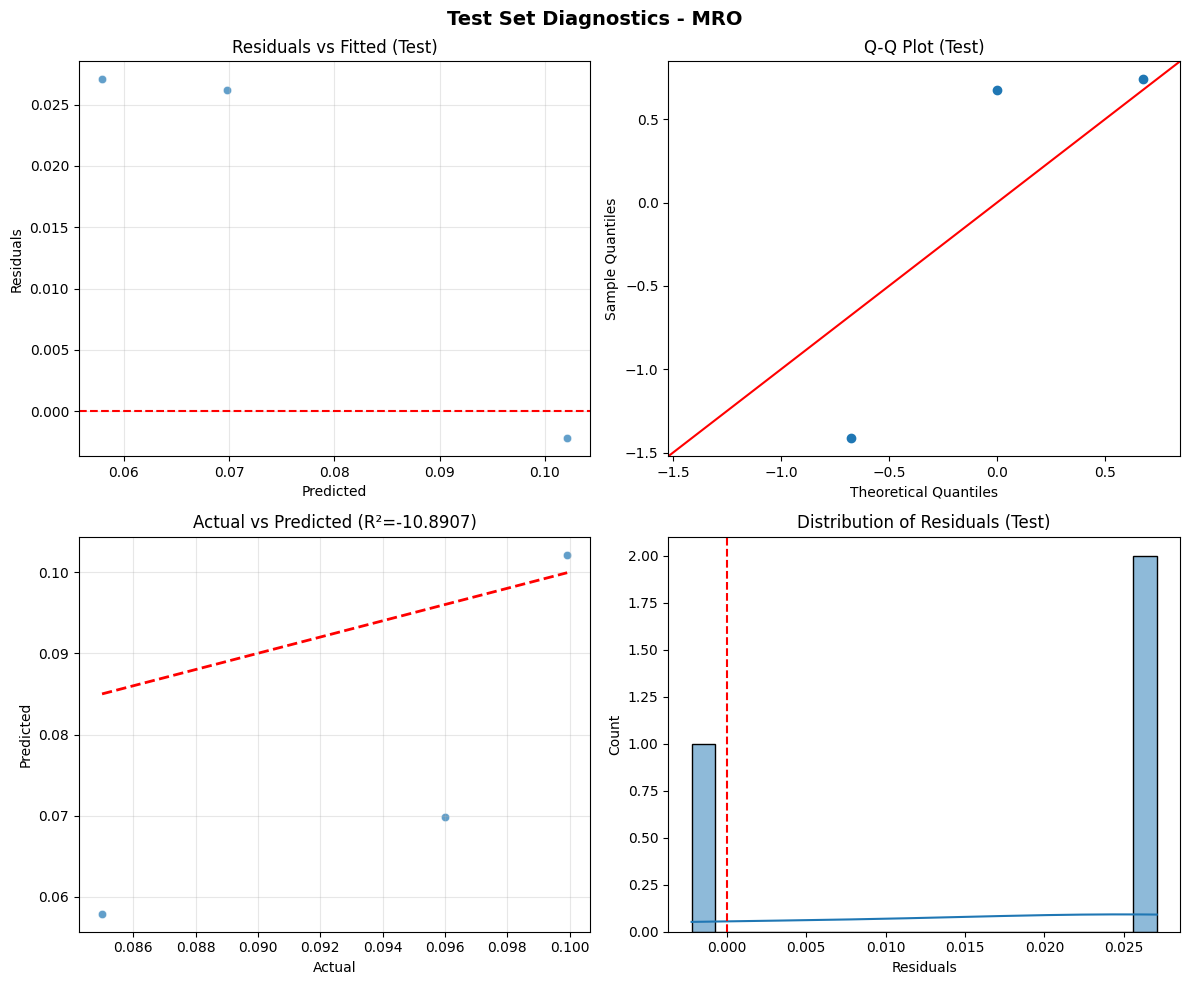


=== Coefficient Confidence Intervals ===


Feature  Coefficient  Std_Error  t_Value  p_Value  CI_Lower  CI_Upper  \
const   const       0.0825     0.0037  22.0491   0.0000    0.0734    0.0917   
PC1       PC1       0.0096     0.0034   2.8022   0.0311    0.0012    0.0179   
PC2       PC2       0.0100     0.0067   1.5039   0.1833   -0.0063    0.0263   

       Significant  
const         True  
PC1           True  
PC2          False

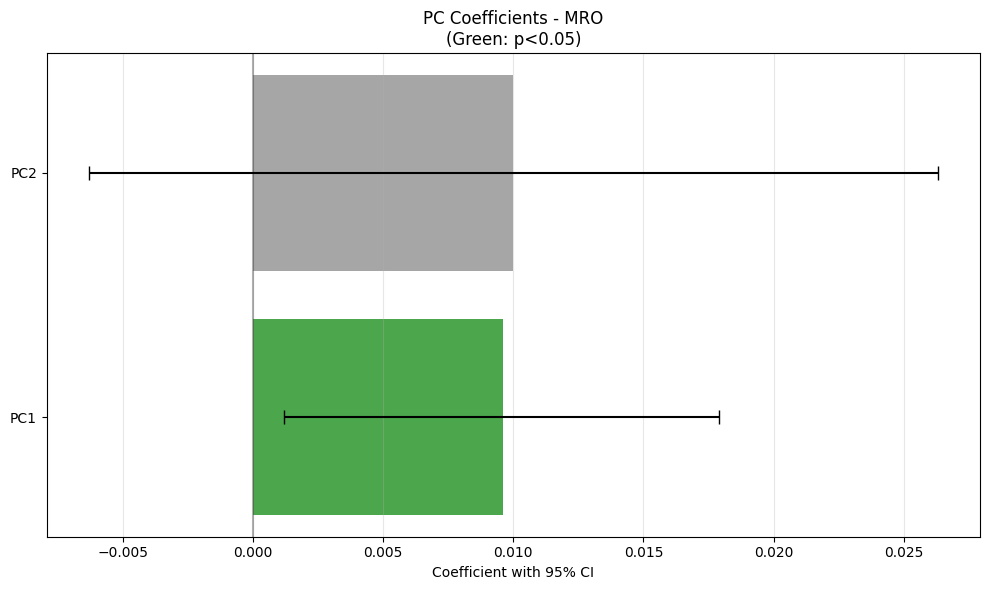


=== FINAL MODEL SUMMARY - MRO ===


Model  R²_Test  R²_Train    RMSE     MAE     MAPE      AIC      BIC  \
0  PCA + OLS -10.8907    0.5882  0.0218  0.0185  20.4456 -53.2435 -52.6518   

   N_Components  N_Train  N_Test  
0             2        9       3

In [ ]:
# @title
segment = 'mro'
linear_numerical_vars = ['fuel', 'material_cost', 'lease_charter', 'staff_cost']
linear_dependent_var = 'adjusted_ebit_marge'
segment_col = 'segment'

df_segment_filtered = df_segment[df_segment['period_type'] != 'covid_shock'].copy()
df_seg = df_segment_filtered[df_segment_filtered[segment_col] == segment].copy()


print(f"SEGMENT: {segment.upper()}")

X_lr_original = df_seg[linear_numerical_vars].copy()
y_lr = df_seg[linear_dependent_var]

print(f"\n Correlation Matrix")
plt.figure(figsize=(8, 6))
sns.heatmap(X_lr_original.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title(f"Correlation Matrix - {segment.upper()}")
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lr_original)

pca_full = PCA()
pca_full.fit_transform(X_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n PCA Analysis")
print("Explained Variance Ratio:", explained_variance.round(4))
print("Cumulative Variance:", cumulative_variance.round(4))

loadings_full = pd.DataFrame(
    pca_full.components_.T,
    columns=[f'PC{i+1}' for i in range(pca_full.n_components_)],
    index=X_lr_original.columns
)
print(f"\nLoadings Matrix:")
display(loadings_full.round(3))

plt.figure(figsize=(10, 6))
sns.heatmap(loadings_full, annot=True, cmap='RdBu_r', center=0, fmt='.3f',
            cbar_kws={'label': 'Loading Strength'})
plt.title(f'PCA Loadings Heatmap - {segment.upper()}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title(f'PCA Scree Plot - {segment.upper()}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

n_components = min(3, np.argmax(cumulative_variance >= 0.95) + 1)
if cumulative_variance[n_components-1] < 0.95 and n_components < len(linear_numerical_vars):
    n_components = min(3, len(linear_numerical_vars))

pca = PCA(n_components=n_components)
X_lr = pd.DataFrame(
    pca.fit_transform(X_scaled),
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X_lr_original.index
)

print(f"\n Correlation Matrix ")
plt.figure(figsize=(7, 5))
sns.heatmap(X_lr.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title(f"Correlation Matrix - {segment.upper()}")
plt.tight_layout()
plt.show()

test_size = max(0.2, 2/len(X_lr))
X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=test_size, random_state=42)
print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

X_train_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame({
    "Feature": X_train_vif.columns,
    "VIF": [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
})
print(f"\n Variance Inflation Factor (VIF)")
display(vif_data.round(4))

print(f"\n STATSMODELS")
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_sm)
results = model.fit()
print(results.summary())

y_pred = results.predict(X_test_sm)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
valid_mape_idx = y_test != 0
mape = np.mean(np.abs((y_test[valid_mape_idx] - y_pred[valid_mape_idx]) / y_test[valid_mape_idx])) * 100 if np.sum(valid_mape_idx) > 0 else np.nan

residuals_train = y_train - results.predict(X_train_sm)
shapiro_stat, shapiro_p = stats.shapiro(residuals_train) if len(residuals_train) >= 3 else (np.nan, np.nan)
bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals_train, X_train_sm)
dw_stat = durbin_watson(residuals_train)

gof_df = pd.DataFrame({
    "Statistic": ["R²", "Adjusted R²", "F-statistic", "F-statistic p-value", "AIC", "BIC",
                  "Durbin-Watson", "Shapiro-Wilk (normality)", "Shapiro-Wilk p-value",
                  "Breusch-Pagan (heteroscedasticity)", "Breusch-Pagan p-value"],
    "Value": [f"{results.rsquared:.4f}", f"{results.rsquared_adj:.4f}", f"{results.fvalue:.4f}",
              f"{results.f_pvalue:.4f}", f"{results.aic:.4f}", f"{results.bic:.4f}",
              f"{dw_stat:.4f}", f"{shapiro_stat:.4f}", f"{shapiro_p:.4f}",
              f"{bp_stat:.4f}", f"{bp_pvalue:.4f}"]
})
print(f"\n Goodness-of-Fit")
display(gof_df)

print(f"\n Advanced Residual Analysis ")
leverage = results.get_influence().hat_matrix_diag
resid_std = residuals_train / (results.resid.std() * np.sqrt(1 - leverage))
resid_student = OLSInfluence(results).resid_studentized

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Residual Analysis - {segment.upper()}', fontsize=14, fontweight='bold')

axes[0, 0].scatter(results.fittedvalues, resid_std, alpha=0.6, color='orange')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].axhline(y=2, color='red', linestyle=':', alpha=0.7, label='±2σ')
axes[0, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.7)
axes[0, 0].set_xlabel('Fitted Values'); axes[0, 0].set_ylabel('Standardized Residuals')
axes[0, 0].set_title('Standardized Residuals vs Fitted'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

sns.histplot(resid_std, bins=30, kde=True, ax=axes[0, 1], color='purple')
axes[0, 1].axvline(x=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Standardized Residuals'); axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Standardized Residuals'); axes[0, 1].grid(True, alpha=0.3)

sm.qqplot(resid_student, line='45', fit=True, ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Studentized Residuals'); axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_visible(False)
plt.tight_layout(); plt.show()

print(f"\n Diagnostic Plots for Test Set ")
residuals_test = y_test - y_pred

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'Test Set Diagnostics - {segment.upper()}', fontsize=14, fontweight='bold')

sns.scatterplot(x=y_pred, y=residuals_test, alpha=0.7, ax=axes[0, 0])
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Predicted'); axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted (Test)'); axes[0, 0].grid(True, alpha=0.3)

sm.qqplot(residuals_test, line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Test)')

sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, ax=axes[1, 0])
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Actual'); axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title(f'Actual vs Predicted (R²={r2_test:.4f})'); axes[1, 0].grid(True, alpha=0.3)

sns.histplot(residuals_test, kde=True, bins=20, ax=axes[1, 1])
axes[1, 1].axvline(x=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Residuals'); axes[1, 1].set_title('Distribution of Residuals (Test)')
plt.tight_layout(); plt.show()

print(f"\n Coefficient Confidence Intervals ")
conf_int = results.conf_int()
conf_int.columns = ['CI_Lower', 'CI_Upper']

coef_summary = pd.DataFrame({
    'Feature': results.params.index, 'Coefficient': results.params.values,
    'Std_Error': results.bse.values, 't_Value': results.tvalues.values,
    'p_Value': results.pvalues.values, 'CI_Lower': conf_int['CI_Lower'],
    'CI_Upper': conf_int['CI_Upper'], 'Significant': results.pvalues.values < 0.05
}).round(4)
display(coef_summary)

sig_coefs = coef_summary[coef_summary['Feature'] != 'const'].sort_values('Coefficient')
plt.figure(figsize=(10, 6))
colors = ['green' if sig else 'gray' for sig in sig_coefs['Significant']]
plt.barh(range(len(sig_coefs)), sig_coefs['Coefficient'],
         xerr=[sig_coefs['Coefficient'] - sig_coefs['CI_Lower'],
               sig_coefs['CI_Upper'] - sig_coefs['Coefficient']], color=colors, alpha=0.7, capsize=5)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.yticks(range(len(sig_coefs)), sig_coefs['Feature'])
plt.xlabel('Coefficient with 95% CI'); plt.title(f'PC Coefficients - {segment.upper()}\n(Green: p<0.05)')
plt.grid(axis='x', alpha=0.3); plt.tight_layout(); plt.show()

print(f"\n MODEL SUMMARY - {segment.upper()}")
summary = pd.DataFrame({
    'Model': ['PCA + OLS'], 'R²_Test': [r2_test], 'R²_Train': [results.rsquared],
    'RMSE': [rmse], 'MAE': [mae], 'MAPE': [mape], 'AIC': [results.aic], 'BIC': [results.bic],
    'N_Components': [n_components], 'N_Train': [len(X_train)], 'N_Test': [len(X_test)]
}).round(4)
display(summary)

**PC1**

p = 0.031

1.   Material Cost → 0.707
2.   Staff Cost → 0.707

PC1 captures 85.3% of the total cost-driven variance being the dominant component for the MRO segment. It represents the core operational cost block, where both material cost and staff cost move together.

Since PC1 is statistically significant and has a coefficient of +0.0096, higher investment in material procurement and staff-related activities is associated with slightly higher Adjusted EBIT margins. This aligns with the nature of MRO: quality labour and timely access to materials directly improve turnaround times, service reliability, and therefore margins.

**PC2**

p = 0.183

Material Cost → 0.707

Staff Cost → -0.707

PC2 explains the remaining 14.8% of the variance but is not statistically significant so it cannot be used to make valid predictions about Adjusted EBIT margins.


MRO profitability is driven by material procurement and staff capability/availability. This can be understood by MRO's operations:

- An aircraft cannot be serviced without skilled labour.
- Maintenance cannot be done without reliable access to parts.


Cost Optimisation Focus

- Improve material procurement strategy
- Strengthen workforce planning
- Audit staff-to-material cost relationships
- Re-evaluate role criticality in high-material-cost environments
- Remove low-value or non-essential staffing layers
- Reduce waste from rework and inefficient maintenance processes

##Network Airline

SEGMENT: NETWORK_AIRLINE
Number of observations: 12
Years covered: 2012 - 2025

=== Correlation Matrix ===


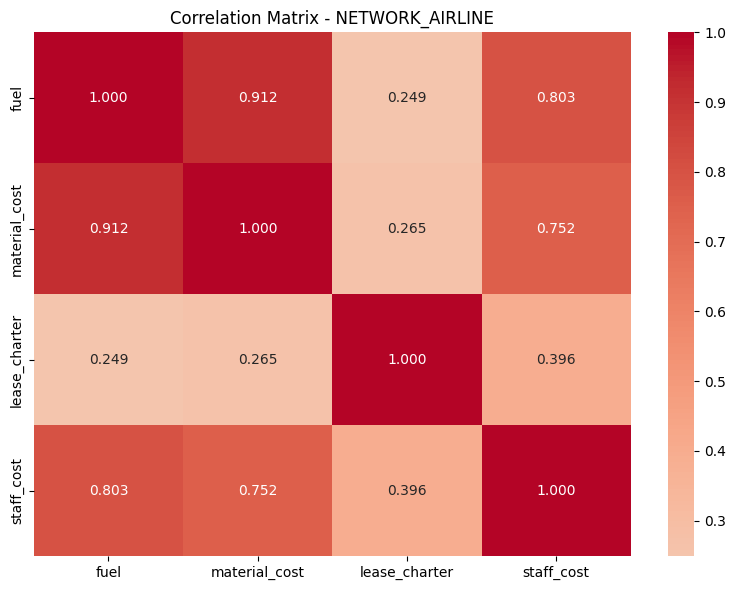


=== PCA Analysis ===
Explained Variance Ratio: [0.6998 0.2182 0.0617 0.0203]
Cumulative Variance: [0.6998 0.918  0.9797 1.    ]

Loadings Matrix:


PC1    PC2    PC3    PC4
fuel           0.563 -0.249 -0.215  0.758
material_cost  0.555 -0.230 -0.494 -0.628
lease_charter  0.280  0.941 -0.186  0.048
staff_cost     0.545  0.009  0.821 -0.169

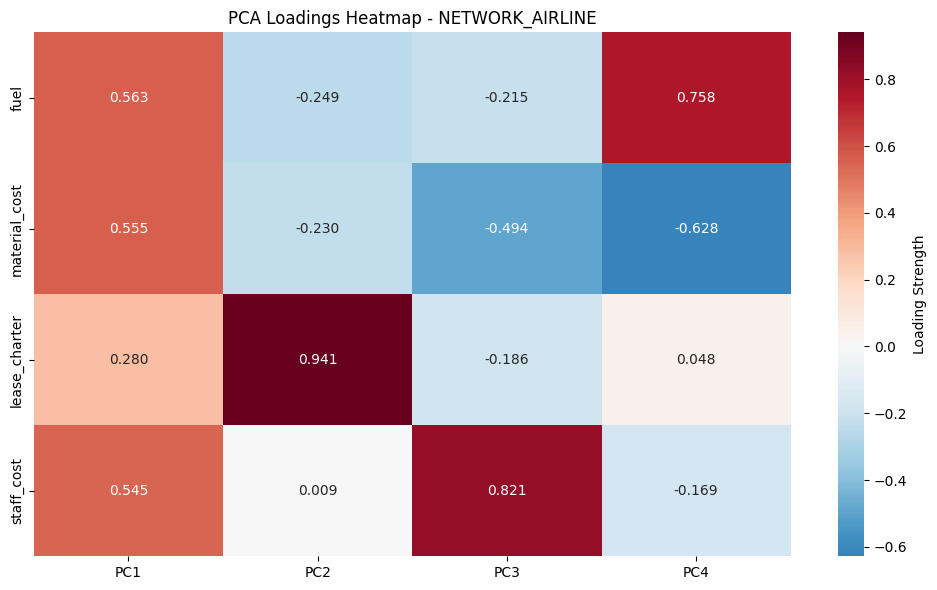

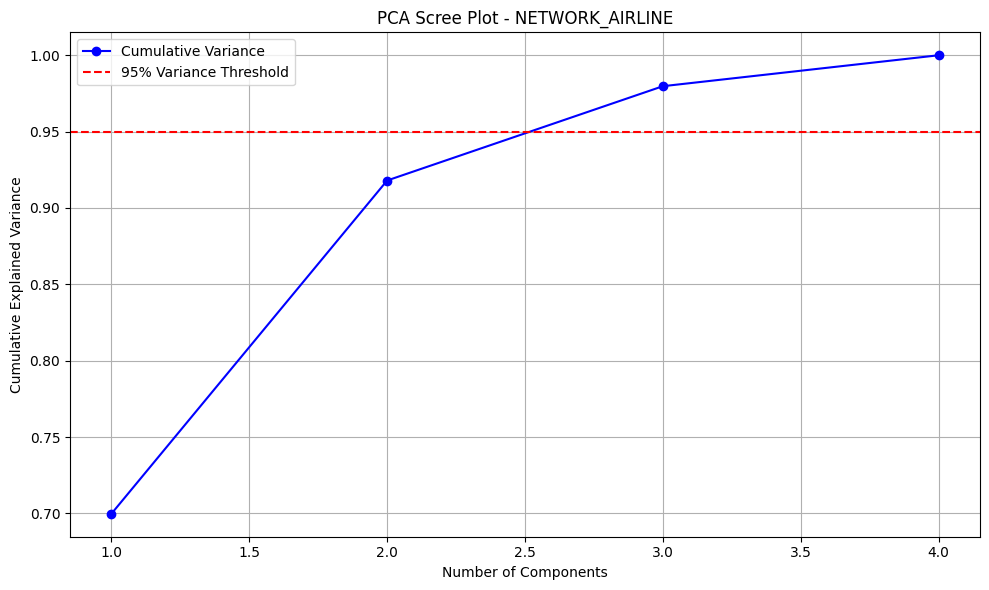


Variance retained with 3 components: 98.0%

=== Correlation Matrix (Principal Components) ===


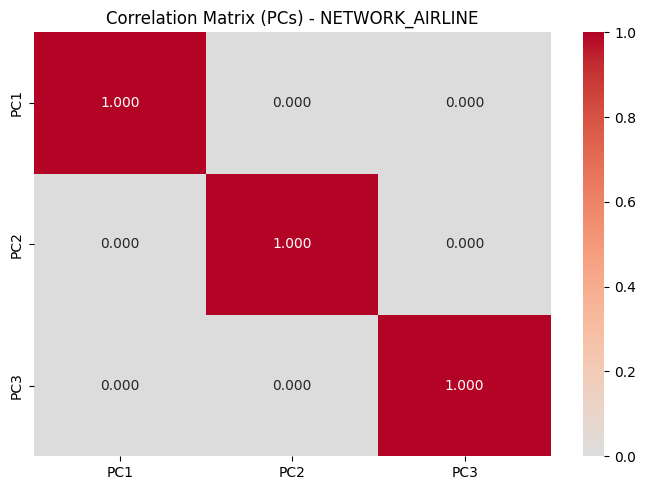


Training set: 9 samples
Test set: 3 samples

=== Variance Inflation Factor (VIF) ===


Feature     VIF
0   const  1.1506
1     PC1  1.0616
2     PC2  1.0937
3     PC3  1.0431


=== STATSMODELS OLS REGRESSION ===
                             OLS Regression Results                            
Dep. Variable:     adjusted_ebit_marge   R-squared:                       0.091
Model:                             OLS   Adj. R-squared:                 -0.454
Method:                  Least Squares   F-statistic:                    0.1673
Date:                 Sat, 22 Nov 2025   Prob (F-statistic):              0.914
Time:                         23:48:47   Log-Likelihood:                 8.2308
No. Observations:                    9   AIC:                            -8.462
Df Residuals:                        5   BIC:                            -7.673
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

Statistic    Value
0                                   R²   0.0912
1                          Adjusted R²  -0.4541
2                          F-statistic   0.1673
3                  F-statistic p-value   0.9140
4                                  AIC  -8.4616
5                                  BIC  -7.6728
6                        Durbin-Watson   2.7172
7             Shapiro-Wilk (normality)   0.9588
8                 Shapiro-Wilk p-value   0.7860
9   Breusch-Pagan (heteroscedasticity)   1.6439
10               Breusch-Pagan p-value   0.6495


=== Advanced Residual Analysis ===


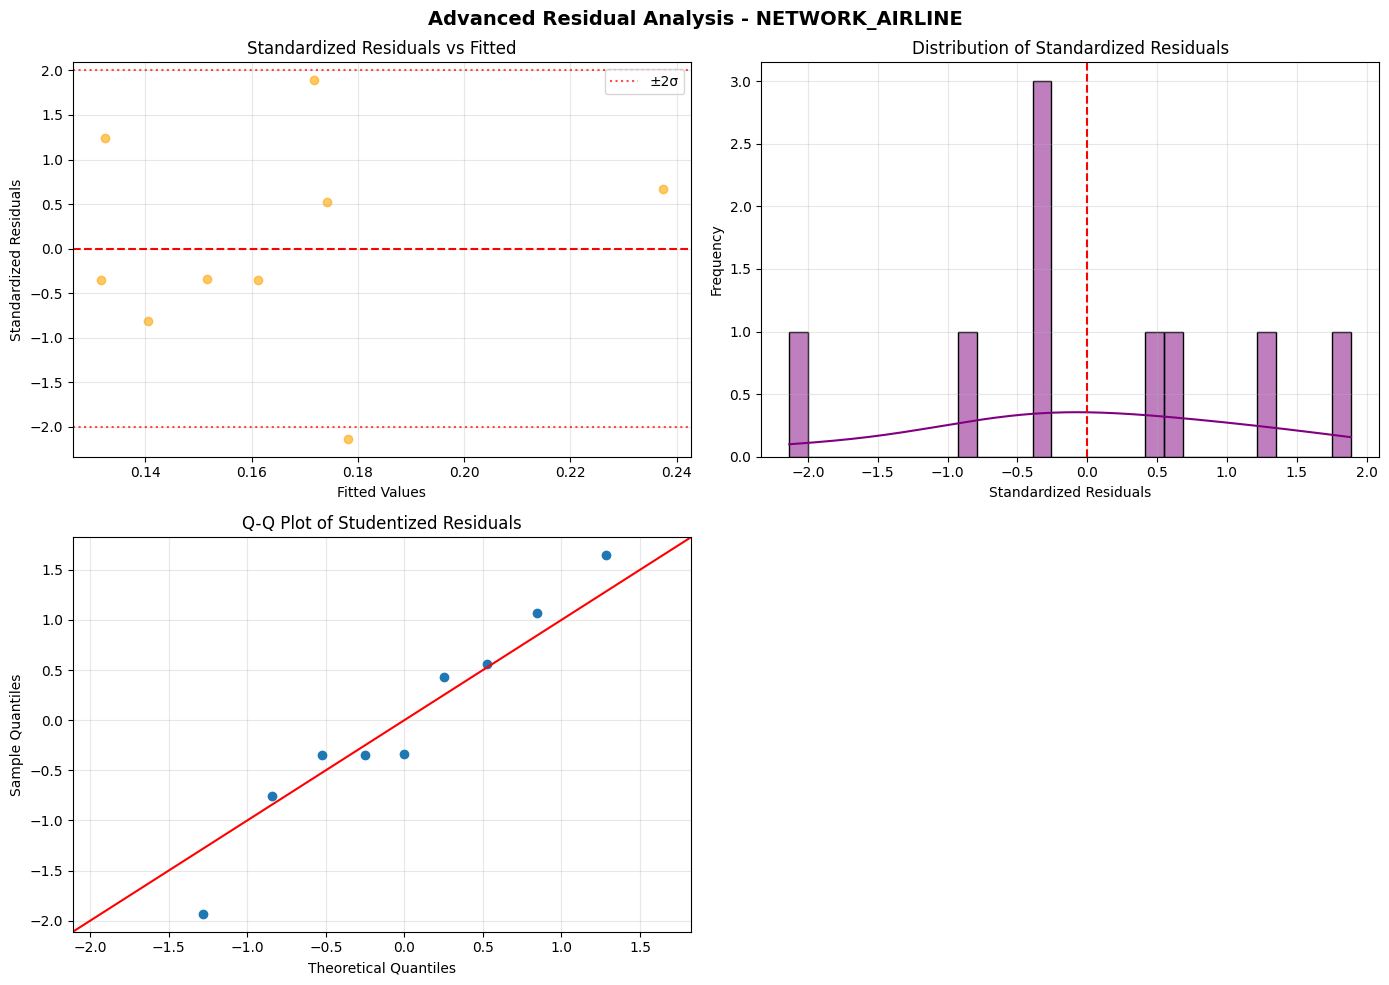


=== Diagnostic Plots (Test Set) ===


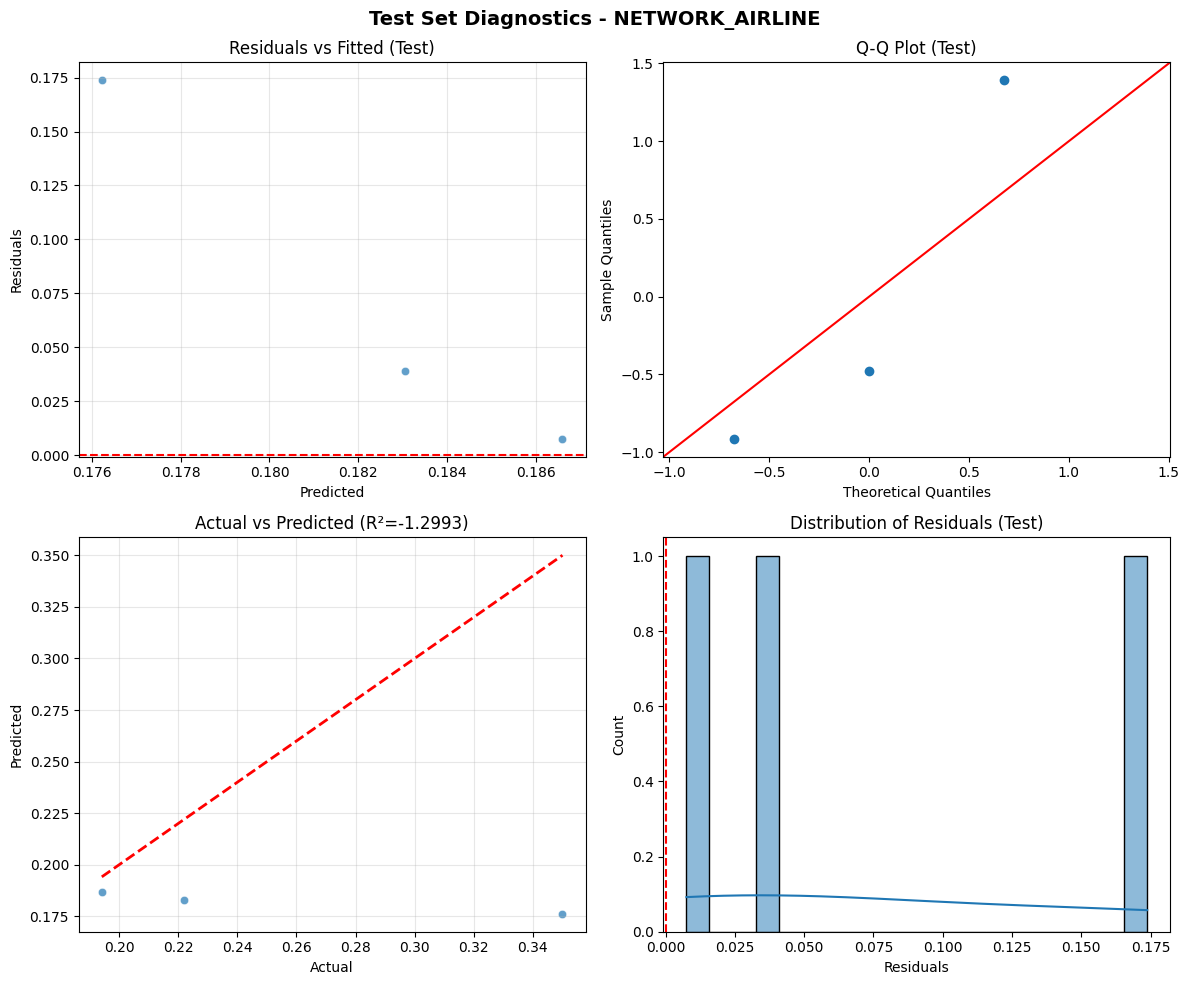


=== Coefficient Confidence Intervals ===


Feature  Coefficient  Std_Error  t_Value  p_Value  CI_Lower  CI_Upper  \
const   const       0.1687     0.0465   3.6277   0.0151    0.0492    0.2883   
PC1       PC1      -0.0054     0.0294  -0.1844   0.8610   -0.0811    0.0702   
PC2       PC2      -0.0112     0.0476  -0.2345   0.8239   -0.1335    0.1111   
PC3       PC3       0.0484     0.0823   0.5884   0.5818   -0.1632    0.2601   

       Significant  
const         True  
PC1          False  
PC2          False  
PC3          False

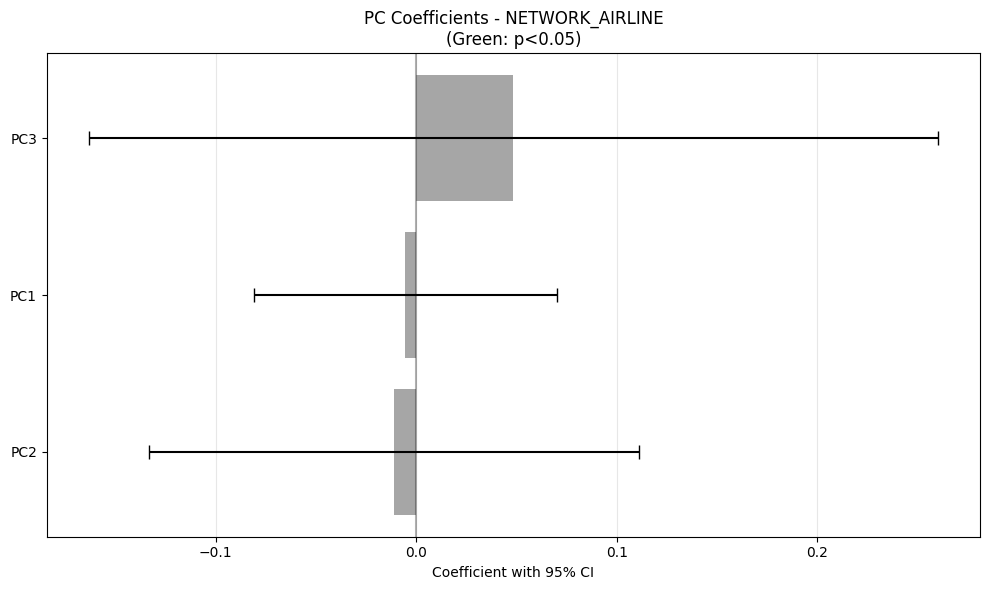


=== FINAL MODEL SUMMARY - NETWORK_AIRLINE ===


Model  R²_Test  R²_Train    RMSE     MAE     MAPE     AIC     BIC  \
0  PCA + OLS  -1.2993    0.0912  0.1029  0.0734  23.6955 -8.4616 -7.6728   

   N_Components  N_Train  N_Test  
0             3        9       3

In [ ]:
# @title
segment = 'network_airline'
linear_numerical_vars = ['fuel', 'material_cost', 'lease_charter', 'staff_cost']
linear_dependent_var = 'adjusted_ebit_marge'
segment_col = 'segment'

df_segment_filtered = df_segment[df_segment['period_type'] != 'covid_shock'].copy()
df_seg = df_segment_filtered[df_segment_filtered[segment_col] == segment].copy()


print(f"SEGMENT: {segment.upper()}")

X_lr_original = df_seg[linear_numerical_vars].copy()
y_lr = df_seg[linear_dependent_var]

print(f"\n Correlation Matrix")
plt.figure(figsize=(8, 6))
sns.heatmap(X_lr_original.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title(f"Correlation Matrix - {segment.upper()}")
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lr_original)

pca_full = PCA()
pca_full.fit_transform(X_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n PCA Analysis")
print("Explained Variance Ratio:", explained_variance.round(4))
print("Cumulative Variance:", cumulative_variance.round(4))

loadings_full = pd.DataFrame(
    pca_full.components_.T,
    columns=[f'PC{i+1}' for i in range(pca_full.n_components_)],
    index=X_lr_original.columns
)
print(f"\nLoadings Matrix:")
display(loadings_full.round(3))

plt.figure(figsize=(10, 6))
sns.heatmap(loadings_full, annot=True, cmap='RdBu_r', center=0, fmt='.3f',
            cbar_kws={'label': 'Loading Strength'})
plt.title(f'PCA Loadings Heatmap - {segment.upper()}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title(f'PCA Scree Plot - {segment.upper()}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

n_components = min(3, np.argmax(cumulative_variance >= 0.95) + 1)
if cumulative_variance[n_components-1] < 0.95 and n_components < len(linear_numerical_vars):
    n_components = min(3, len(linear_numerical_vars))

pca = PCA(n_components=n_components)
X_lr = pd.DataFrame(
    pca.fit_transform(X_scaled),
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X_lr_original.index
)

print(f"\n Correlation Matrix ")
plt.figure(figsize=(7, 5))
sns.heatmap(X_lr.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title(f"Correlation Matrix - {segment.upper()}")
plt.tight_layout()
plt.show()

test_size = max(0.2, 2/len(X_lr))
X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=test_size, random_state=42)
print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

X_train_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame({
    "Feature": X_train_vif.columns,
    "VIF": [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
})
print(f"\n Variance Inflation Factor (VIF)")
display(vif_data.round(4))

print(f"\n STATSMODELS")
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_sm)
results = model.fit()
print(results.summary())

y_pred = results.predict(X_test_sm)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
valid_mape_idx = y_test != 0
mape = np.mean(np.abs((y_test[valid_mape_idx] - y_pred[valid_mape_idx]) / y_test[valid_mape_idx])) * 100 if np.sum(valid_mape_idx) > 0 else np.nan

residuals_train = y_train - results.predict(X_train_sm)
shapiro_stat, shapiro_p = stats.shapiro(residuals_train) if len(residuals_train) >= 3 else (np.nan, np.nan)
bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals_train, X_train_sm)
dw_stat = durbin_watson(residuals_train)

gof_df = pd.DataFrame({
    "Statistic": ["R²", "Adjusted R²", "F-statistic", "F-statistic p-value", "AIC", "BIC",
                  "Durbin-Watson", "Shapiro-Wilk (normality)", "Shapiro-Wilk p-value",
                  "Breusch-Pagan (heteroscedasticity)", "Breusch-Pagan p-value"],
    "Value": [f"{results.rsquared:.4f}", f"{results.rsquared_adj:.4f}", f"{results.fvalue:.4f}",
              f"{results.f_pvalue:.4f}", f"{results.aic:.4f}", f"{results.bic:.4f}",
              f"{dw_stat:.4f}", f"{shapiro_stat:.4f}", f"{shapiro_p:.4f}",
              f"{bp_stat:.4f}", f"{bp_pvalue:.4f}"]
})
print(f"\n Goodness-of-Fit")
display(gof_df)

print(f"\n Advanced Residual Analysis ")
leverage = results.get_influence().hat_matrix_diag
resid_std = residuals_train / (results.resid.std() * np.sqrt(1 - leverage))
resid_student = OLSInfluence(results).resid_studentized

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Residual Analysis - {segment.upper()}', fontsize=14, fontweight='bold')

axes[0, 0].scatter(results.fittedvalues, resid_std, alpha=0.6, color='orange')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].axhline(y=2, color='red', linestyle=':', alpha=0.7, label='±2σ')
axes[0, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.7)
axes[0, 0].set_xlabel('Fitted Values'); axes[0, 0].set_ylabel('Standardized Residuals')
axes[0, 0].set_title('Standardized Residuals vs Fitted'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

sns.histplot(resid_std, bins=30, kde=True, ax=axes[0, 1], color='purple')
axes[0, 1].axvline(x=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Standardized Residuals'); axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Standardized Residuals'); axes[0, 1].grid(True, alpha=0.3)

sm.qqplot(resid_student, line='45', fit=True, ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Studentized Residuals'); axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_visible(False)
plt.tight_layout(); plt.show()

print(f"\n Diagnostic Plots for Test Set ")
residuals_test = y_test - y_pred

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'Test Set Diagnostics - {segment.upper()}', fontsize=14, fontweight='bold')

sns.scatterplot(x=y_pred, y=residuals_test, alpha=0.7, ax=axes[0, 0])
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Predicted'); axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted (Test)'); axes[0, 0].grid(True, alpha=0.3)

sm.qqplot(residuals_test, line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Test)')

sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, ax=axes[1, 0])
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Actual'); axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title(f'Actual vs Predicted (R²={r2_test:.4f})'); axes[1, 0].grid(True, alpha=0.3)

sns.histplot(residuals_test, kde=True, bins=20, ax=axes[1, 1])
axes[1, 1].axvline(x=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Residuals'); axes[1, 1].set_title('Distribution of Residuals (Test)')
plt.tight_layout(); plt.show()

print(f"\n Coefficient Confidence Intervals ")
conf_int = results.conf_int()
conf_int.columns = ['CI_Lower', 'CI_Upper']

coef_summary = pd.DataFrame({
    'Feature': results.params.index, 'Coefficient': results.params.values,
    'Std_Error': results.bse.values, 't_Value': results.tvalues.values,
    'p_Value': results.pvalues.values, 'CI_Lower': conf_int['CI_Lower'],
    'CI_Upper': conf_int['CI_Upper'], 'Significant': results.pvalues.values < 0.05
}).round(4)
display(coef_summary)

sig_coefs = coef_summary[coef_summary['Feature'] != 'const'].sort_values('Coefficient')
plt.figure(figsize=(10, 6))
colors = ['green' if sig else 'gray' for sig in sig_coefs['Significant']]
plt.barh(range(len(sig_coefs)), sig_coefs['Coefficient'],
         xerr=[sig_coefs['Coefficient'] - sig_coefs['CI_Lower'],
               sig_coefs['CI_Upper'] - sig_coefs['Coefficient']], color=colors, alpha=0.7, capsize=5)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.yticks(range(len(sig_coefs)), sig_coefs['Feature'])
plt.xlabel('Coefficient with 95% CI'); plt.title(f'PC Coefficients - {segment.upper()}\n(Green: p<0.05)')
plt.grid(axis='x', alpha=0.3); plt.tight_layout(); plt.show()

print(f"\n MODEL SUMMARY - {segment.upper()}")
summary = pd.DataFrame({
    'Model': ['PCA + OLS'], 'R²_Test': [r2_test], 'R²_Train': [results.rsquared],
    'RMSE': [rmse], 'MAE': [mae], 'MAPE': [mape], 'AIC': [results.aic], 'BIC': [results.bic],
    'N_Components': [n_components], 'N_Train': [len(X_train)], 'N_Test': [len(X_test)]
}).round(4)
display(summary)

Since there are no statistically significant PC, a valid prediction for Adjusted EBI margins for Network Airline cannot be made.

##Other

SEGMENT: OTHER
Number of observations: 12
Years covered: 2012 - 2025

=== Correlation Matrix ===


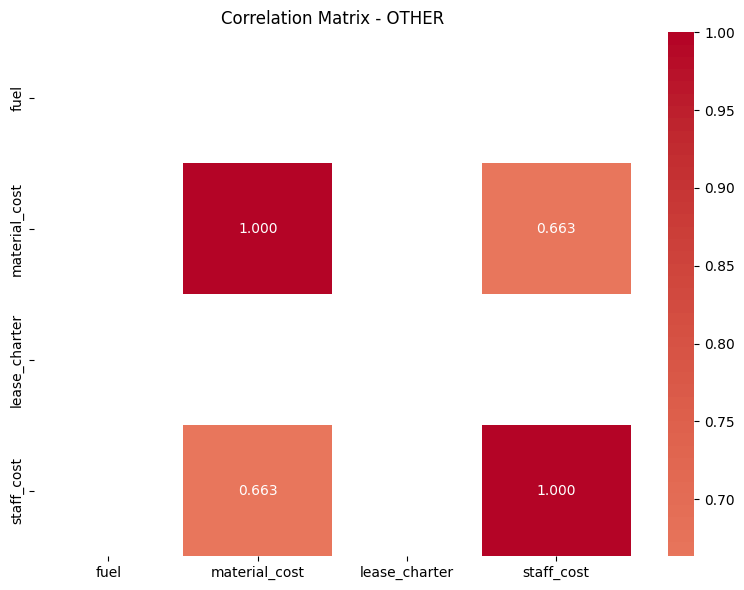


=== PCA Analysis ===
Explained Variance Ratio: [0.8317 0.1683 0.     0.    ]
Cumulative Variance: [0.8317 1.     1.     1.    ]

Loadings Matrix:


PC1    PC2  PC3  PC4
fuel          -0.000 -0.000  0.0  1.0
material_cost  0.707  0.707  0.0  0.0
lease_charter  0.000  0.000  1.0  0.0
staff_cost     0.707 -0.707  0.0  0.0

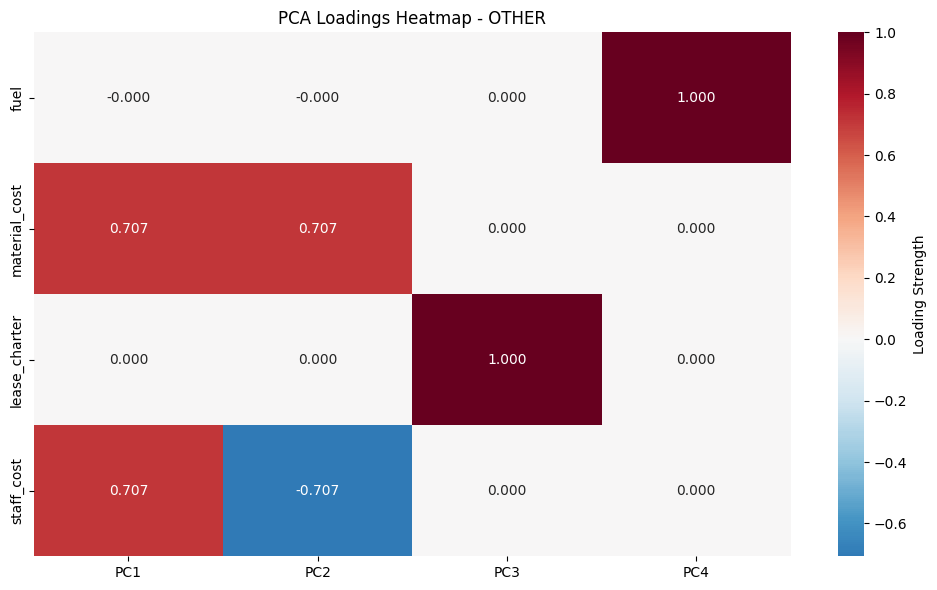

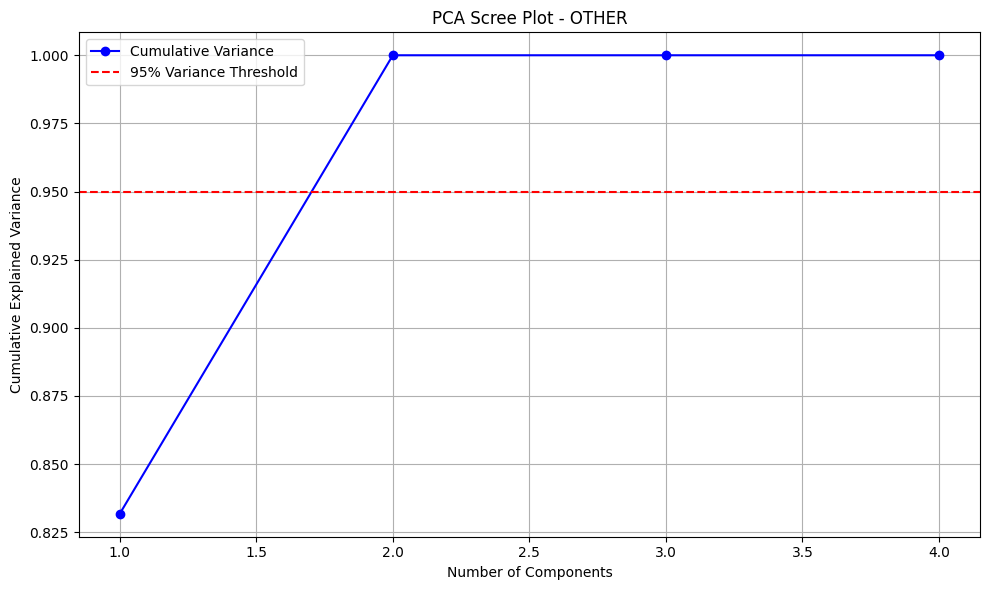


Variance retained with 2 components: 100.0%

=== Correlation Matrix (Principal Components) ===


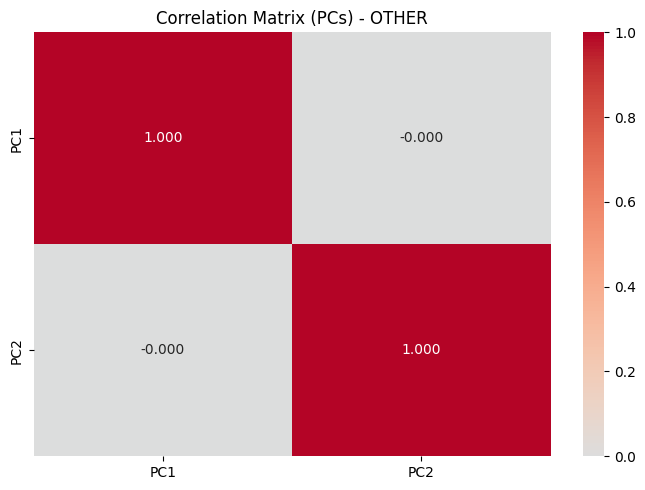


Training set: 9 samples
Test set: 3 samples

=== Variance Inflation Factor (VIF) ===


Feature     VIF
0   const  1.4928
1     PC1  1.5471
2     PC2  1.5471


=== STATSMODELS OLS REGRESSION ===
                             OLS Regression Results                            
Dep. Variable:     adjusted_ebit_marge   R-squared:                       0.164
Model:                             OLS   Adj. R-squared:                 -0.115
Method:                  Least Squares   F-statistic:                    0.5868
Date:                 Sat, 22 Nov 2025   Prob (F-statistic):              0.585
Time:                         23:49:54   Log-Likelihood:                0.98382
No. Observations:                    9   AIC:                             4.032
Df Residuals:                        6   BIC:                             4.624
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

Statistic    Value
0                                   R²   0.1636
1                          Adjusted R²  -0.1152
2                          F-statistic   0.5868
3                  F-statistic p-value   0.5851
4                                  AIC   4.0324
5                                  BIC   4.6240
6                        Durbin-Watson   1.2495
7             Shapiro-Wilk (normality)   0.9928
8                 Shapiro-Wilk p-value   0.9988
9   Breusch-Pagan (heteroscedasticity)   3.9190
10               Breusch-Pagan p-value   0.1409


=== Advanced Residual Analysis ===


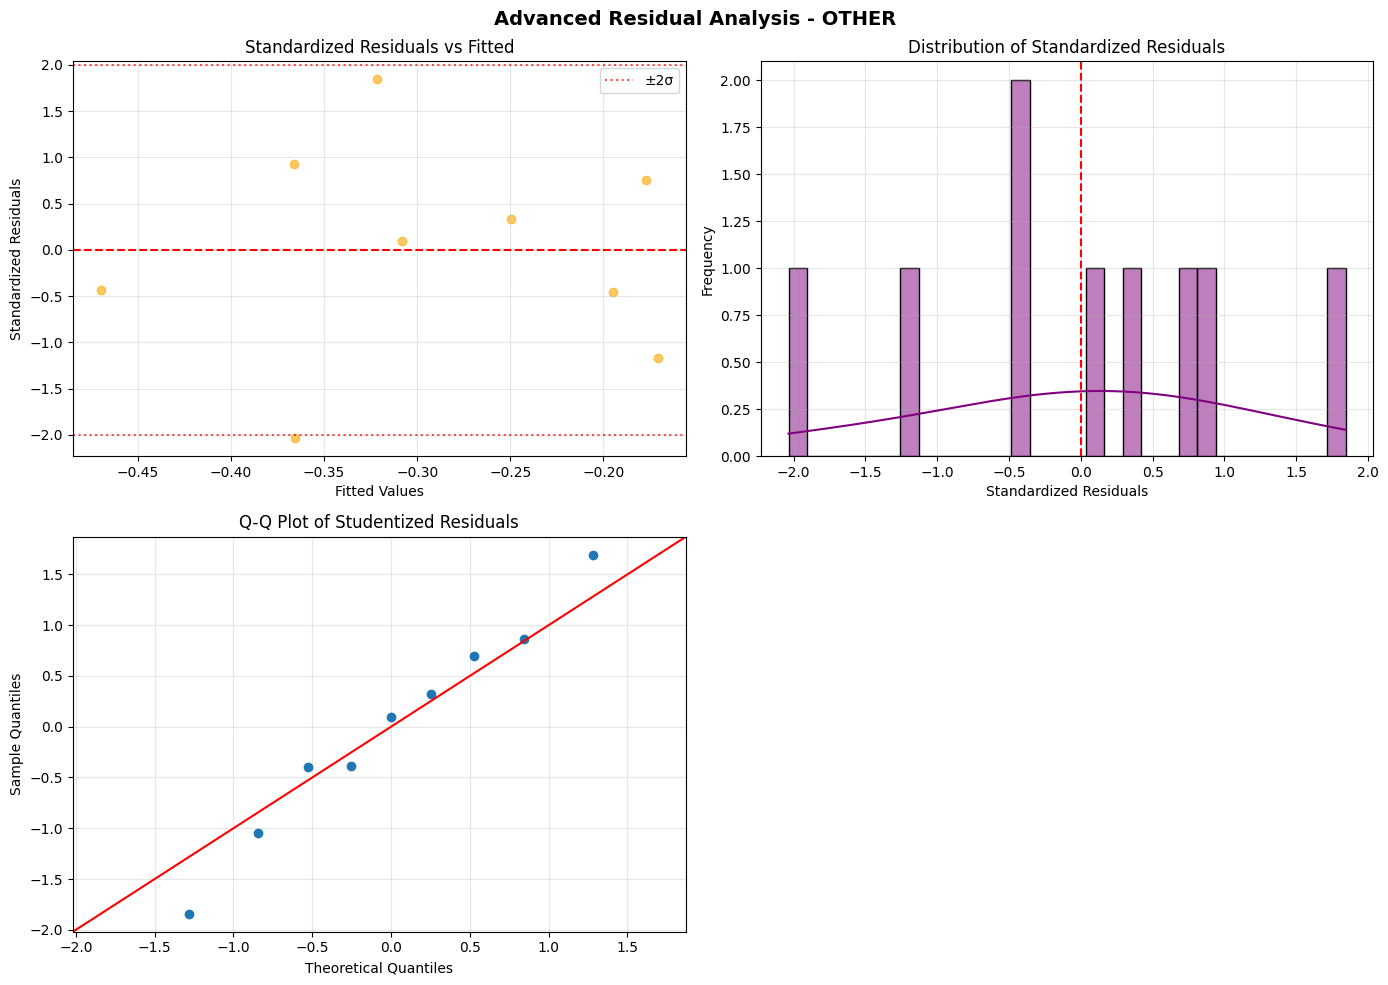


=== Diagnostic Plots (Test Set) ===


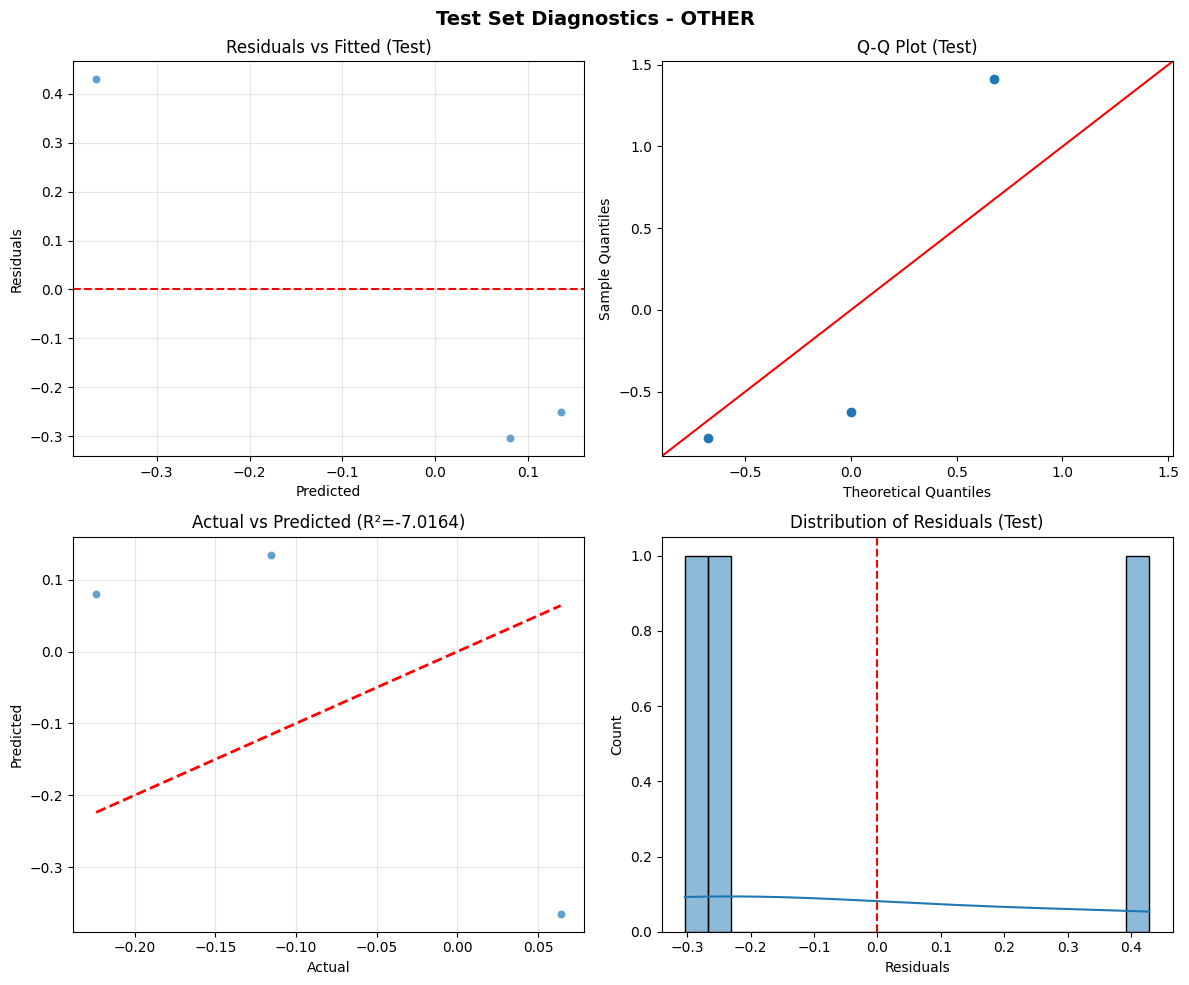


=== Coefficient Confidence Intervals ===


Feature  Coefficient  Std_Error  t_Value  p_Value  CI_Lower  CI_Upper  \
const   const      -0.2312     0.1082  -2.1364   0.0765   -0.4959    0.0336   
PC1       PC1      -0.1216     0.1122  -1.0833   0.3203   -0.3962    0.1530   
PC2       PC2      -0.1308     0.2004  -0.6530   0.5380   -0.6211    0.3594   

       Significant  
const        False  
PC1          False  
PC2          False

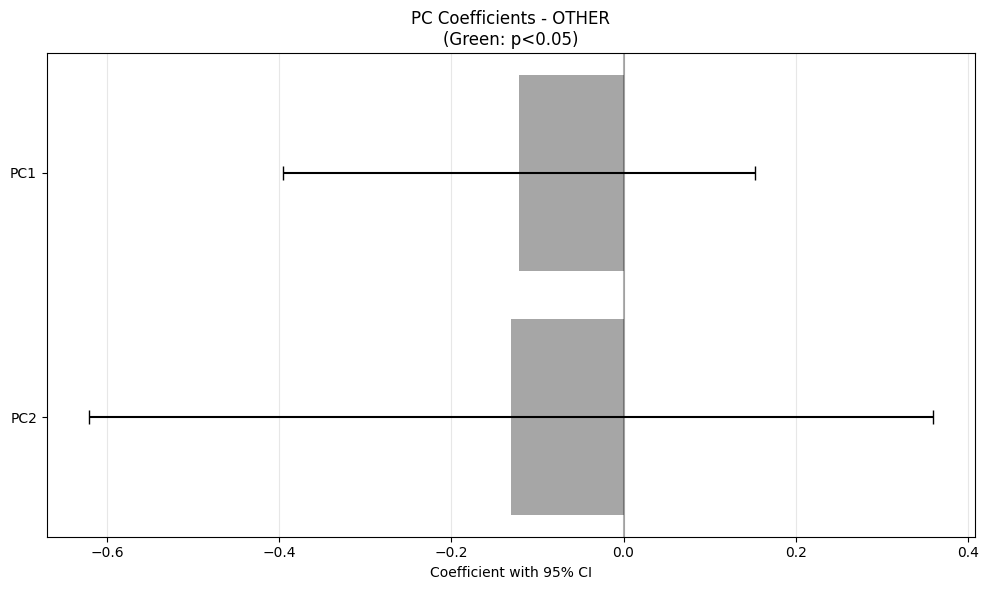


=== FINAL MODEL SUMMARY - OTHER ===


Model  R²_Test  R²_Train    RMSE     MAE      MAPE     AIC    BIC  \
0  PCA + OLS  -7.0164    0.1636  0.3362  0.3278  340.8165  4.0324  4.624   

   N_Components  N_Train  N_Test  
0             2        9       3

In [ ]:
# @title
segment = 'other'
linear_numerical_vars = ['fuel', 'material_cost', 'lease_charter', 'staff_cost']
linear_dependent_var = 'adjusted_ebit_marge'
segment_col = 'segment'

df_segment_filtered = df_segment[df_segment['period_type'] != 'covid_shock'].copy()
df_seg = df_segment_filtered[df_segment_filtered[segment_col] == segment].copy()


print(f"SEGMENT: {segment.upper()}")

X_lr_original = df_seg[linear_numerical_vars].copy()
y_lr = df_seg[linear_dependent_var]

print(f"\n Correlation Matrix")
plt.figure(figsize=(8, 6))
sns.heatmap(X_lr_original.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title(f"Correlation Matrix - {segment.upper()}")
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lr_original)

pca_full = PCA()
pca_full.fit_transform(X_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n PCA Analysis")
print("Explained Variance Ratio:", explained_variance.round(4))
print("Cumulative Variance:", cumulative_variance.round(4))

loadings_full = pd.DataFrame(
    pca_full.components_.T,
    columns=[f'PC{i+1}' for i in range(pca_full.n_components_)],
    index=X_lr_original.columns
)
print(f"\nLoadings Matrix:")
display(loadings_full.round(3))

plt.figure(figsize=(10, 6))
sns.heatmap(loadings_full, annot=True, cmap='RdBu_r', center=0, fmt='.3f',
            cbar_kws={'label': 'Loading Strength'})
plt.title(f'PCA Loadings Heatmap - {segment.upper()}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title(f'PCA Scree Plot - {segment.upper()}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

n_components = min(3, np.argmax(cumulative_variance >= 0.95) + 1)
if cumulative_variance[n_components-1] < 0.95 and n_components < len(linear_numerical_vars):
    n_components = min(3, len(linear_numerical_vars))

pca = PCA(n_components=n_components)
X_lr = pd.DataFrame(
    pca.fit_transform(X_scaled),
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X_lr_original.index
)

print(f"\n Correlation Matrix ")
plt.figure(figsize=(7, 5))
sns.heatmap(X_lr.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title(f"Correlation Matrix - {segment.upper()}")
plt.tight_layout()
plt.show()

test_size = max(0.2, 2/len(X_lr))
X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=test_size, random_state=42)
print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

X_train_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame({
    "Feature": X_train_vif.columns,
    "VIF": [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
})
print(f"\n Variance Inflation Factor (VIF)")
display(vif_data.round(4))

print(f"\n STATSMODELS")
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_sm)
results = model.fit()
print(results.summary())

y_pred = results.predict(X_test_sm)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
valid_mape_idx = y_test != 0
mape = np.mean(np.abs((y_test[valid_mape_idx] - y_pred[valid_mape_idx]) / y_test[valid_mape_idx])) * 100 if np.sum(valid_mape_idx) > 0 else np.nan

residuals_train = y_train - results.predict(X_train_sm)
shapiro_stat, shapiro_p = stats.shapiro(residuals_train) if len(residuals_train) >= 3 else (np.nan, np.nan)
bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals_train, X_train_sm)
dw_stat = durbin_watson(residuals_train)

gof_df = pd.DataFrame({
    "Statistic": ["R²", "Adjusted R²", "F-statistic", "F-statistic p-value", "AIC", "BIC",
                  "Durbin-Watson", "Shapiro-Wilk (normality)", "Shapiro-Wilk p-value",
                  "Breusch-Pagan (heteroscedasticity)", "Breusch-Pagan p-value"],
    "Value": [f"{results.rsquared:.4f}", f"{results.rsquared_adj:.4f}", f"{results.fvalue:.4f}",
              f"{results.f_pvalue:.4f}", f"{results.aic:.4f}", f"{results.bic:.4f}",
              f"{dw_stat:.4f}", f"{shapiro_stat:.4f}", f"{shapiro_p:.4f}",
              f"{bp_stat:.4f}", f"{bp_pvalue:.4f}"]
})
print(f"\n Goodness-of-Fit")
display(gof_df)

print(f"\n Advanced Residual Analysis ")
leverage = results.get_influence().hat_matrix_diag
resid_std = residuals_train / (results.resid.std() * np.sqrt(1 - leverage))
resid_student = OLSInfluence(results).resid_studentized

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Residual Analysis - {segment.upper()}', fontsize=14, fontweight='bold')

axes[0, 0].scatter(results.fittedvalues, resid_std, alpha=0.6, color='orange')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].axhline(y=2, color='red', linestyle=':', alpha=0.7, label='±2σ')
axes[0, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.7)
axes[0, 0].set_xlabel('Fitted Values'); axes[0, 0].set_ylabel('Standardized Residuals')
axes[0, 0].set_title('Standardized Residuals vs Fitted'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

sns.histplot(resid_std, bins=30, kde=True, ax=axes[0, 1], color='purple')
axes[0, 1].axvline(x=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Standardized Residuals'); axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Standardized Residuals'); axes[0, 1].grid(True, alpha=0.3)

sm.qqplot(resid_student, line='45', fit=True, ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Studentized Residuals'); axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_visible(False)
plt.tight_layout(); plt.show()

print(f"\n Diagnostic Plots for Test Set ")
residuals_test = y_test - y_pred

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'Test Set Diagnostics - {segment.upper()}', fontsize=14, fontweight='bold')

sns.scatterplot(x=y_pred, y=residuals_test, alpha=0.7, ax=axes[0, 0])
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Predicted'); axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted (Test)'); axes[0, 0].grid(True, alpha=0.3)

sm.qqplot(residuals_test, line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Test)')

sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, ax=axes[1, 0])
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Actual'); axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title(f'Actual vs Predicted (R²={r2_test:.4f})'); axes[1, 0].grid(True, alpha=0.3)

sns.histplot(residuals_test, kde=True, bins=20, ax=axes[1, 1])
axes[1, 1].axvline(x=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Residuals'); axes[1, 1].set_title('Distribution of Residuals (Test)')
plt.tight_layout(); plt.show()

print(f"\n Coefficient Confidence Intervals ")
conf_int = results.conf_int()
conf_int.columns = ['CI_Lower', 'CI_Upper']

coef_summary = pd.DataFrame({
    'Feature': results.params.index, 'Coefficient': results.params.values,
    'Std_Error': results.bse.values, 't_Value': results.tvalues.values,
    'p_Value': results.pvalues.values, 'CI_Lower': conf_int['CI_Lower'],
    'CI_Upper': conf_int['CI_Upper'], 'Significant': results.pvalues.values < 0.05
}).round(4)
display(coef_summary)

sig_coefs = coef_summary[coef_summary['Feature'] != 'const'].sort_values('Coefficient')
plt.figure(figsize=(10, 6))
colors = ['green' if sig else 'gray' for sig in sig_coefs['Significant']]
plt.barh(range(len(sig_coefs)), sig_coefs['Coefficient'],
         xerr=[sig_coefs['Coefficient'] - sig_coefs['CI_Lower'],
               sig_coefs['CI_Upper'] - sig_coefs['Coefficient']], color=colors, alpha=0.7, capsize=5)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.yticks(range(len(sig_coefs)), sig_coefs['Feature'])
plt.xlabel('Coefficient with 95% CI'); plt.title(f'PC Coefficients - {segment.upper()}\n(Green: p<0.05)')
plt.grid(axis='x', alpha=0.3); plt.tight_layout(); plt.show()

print(f"\n MODEL SUMMARY - {segment.upper()}")
summary = pd.DataFrame({
    'Model': ['PCA + OLS'], 'R²_Test': [r2_test], 'R²_Train': [results.rsquared],
    'RMSE': [rmse], 'MAE': [mae], 'MAPE': [mape], 'AIC': [results.aic], 'BIC': [results.bic],
    'N_Components': [n_components], 'N_Train': [len(X_train)], 'N_Test': [len(X_test)]
}).round(4)
display(summary)

Since PC1 an PC2 are not statistically significant, they cannot be used to make valid predictions about Adjusted EBIT margins

##Eurowings

SEGMENT: EUROWINGS
Number of observations: 8
Years covered: 2016 - 2025

=== Correlation Matrix ===


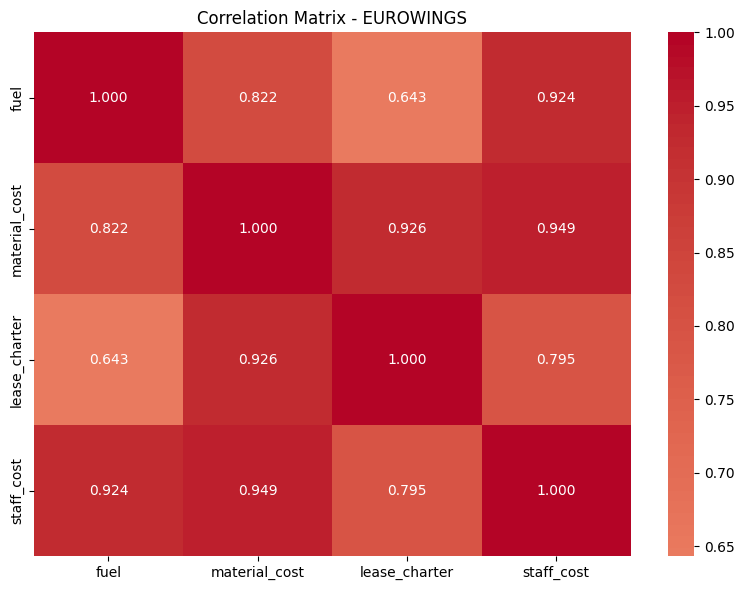


=== PCA Analysis ===
Explained Variance Ratio: [0.8842 0.0992 0.0141 0.0025]
Cumulative Variance: [0.8842 0.9833 0.9975 1.    ]

Loadings Matrix:


PC1    PC2    PC3    PC4
fuel           0.479 -0.651  0.573  0.135
material_cost  0.523  0.212 -0.371  0.737
lease_charter  0.476  0.688  0.456 -0.306
staff_cost     0.520 -0.242 -0.571 -0.588

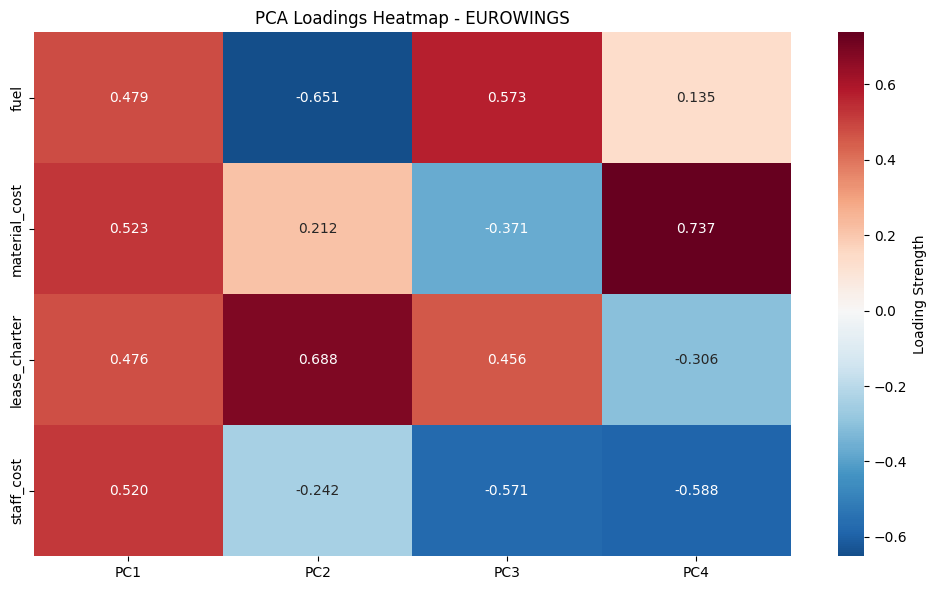

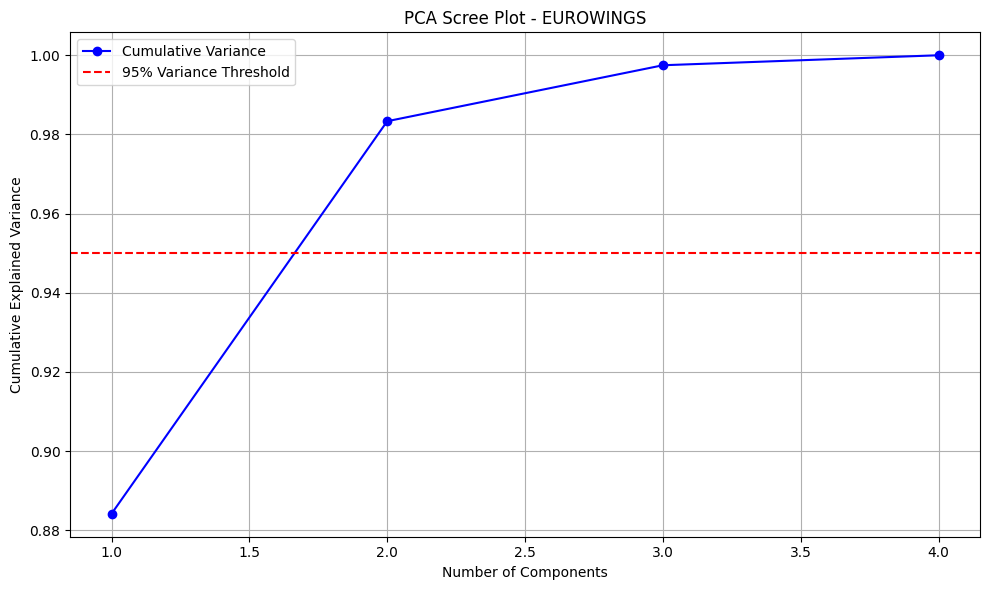


Variance retained with 2 components: 98.3%

=== Correlation Matrix (Principal Components) ===


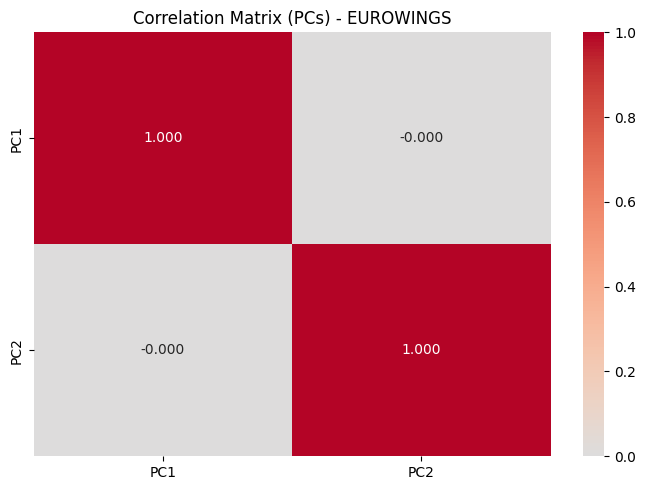


Training set: 6 samples
Test set: 2 samples

=== Variance Inflation Factor (VIF) ===


Feature     VIF
0   const  1.2642
1     PC1  1.6187
2     PC2  1.6187


=== STATSMODELS OLS REGRESSION ===
                             OLS Regression Results                            
Dep. Variable:     adjusted_ebit_marge   R-squared:                       0.016
Model:                             OLS   Adj. R-squared:                 -0.640
Method:                  Least Squares   F-statistic:                   0.02469
Date:                 Sat, 22 Nov 2025   Prob (F-statistic):              0.976
Time:                         23:51:05   Log-Likelihood:                 8.6698
No. Observations:                    6   AIC:                            -11.34
Df Residuals:                        3   BIC:                            -11.96
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Statistic     Value
0                                   R²    0.0162
1                          Adjusted R²   -0.6397
2                          F-statistic    0.0247
3                  F-statistic p-value    0.9758
4                                  AIC  -11.3396
5                                  BIC  -11.9643
6                        Durbin-Watson    1.5038
7             Shapiro-Wilk (normality)    0.9639
8                 Shapiro-Wilk p-value    0.8491
9   Breusch-Pagan (heteroscedasticity)    2.7756
10               Breusch-Pagan p-value    0.2496


=== Advanced Residual Analysis ===


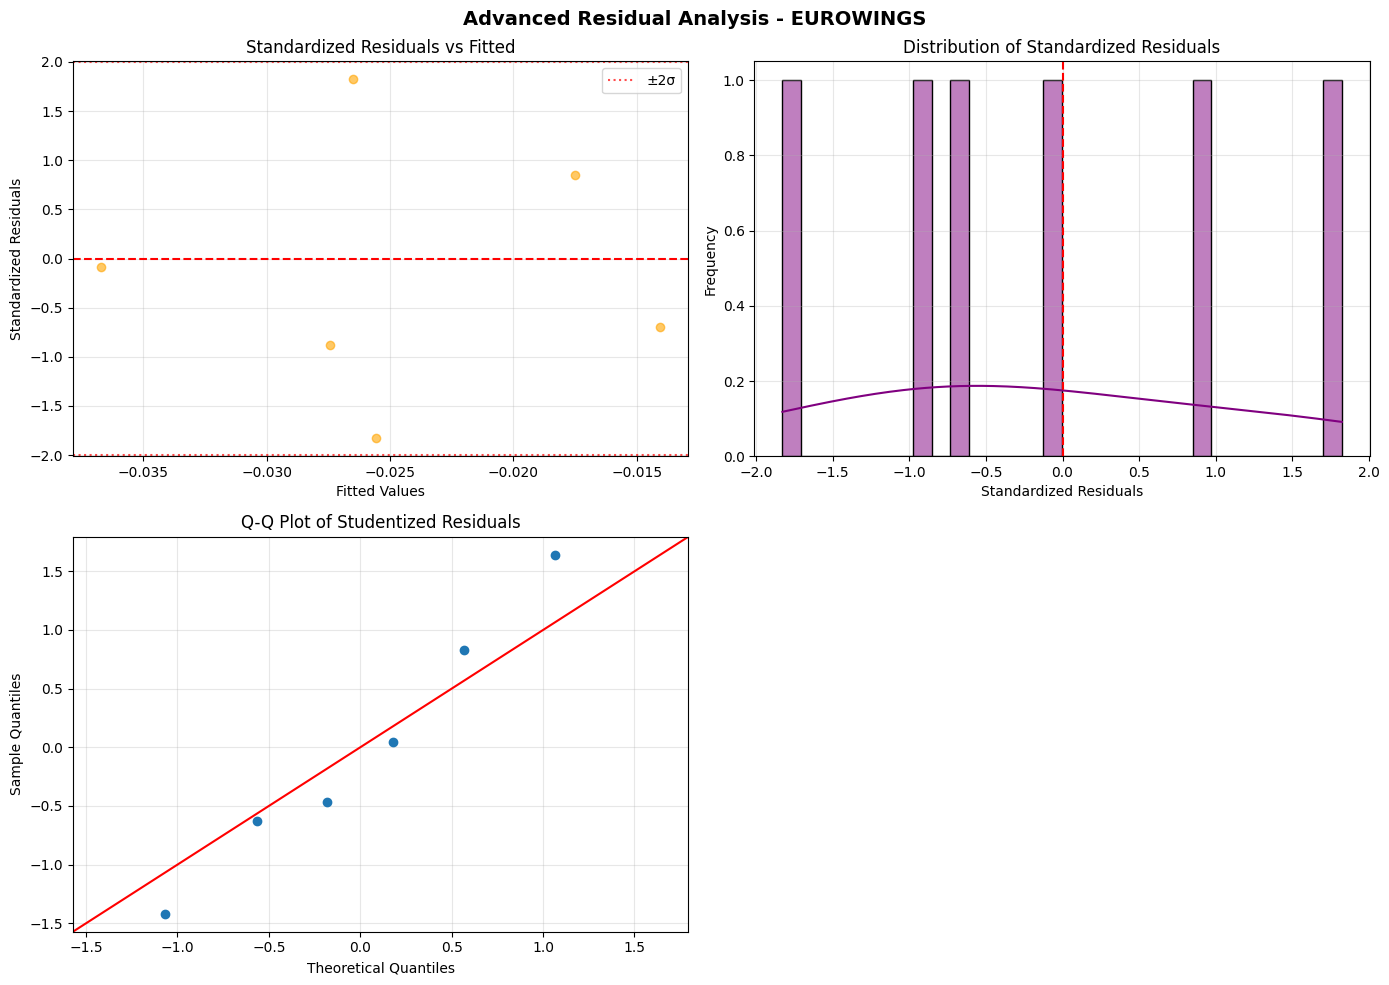


=== Diagnostic Plots (Test Set) ===


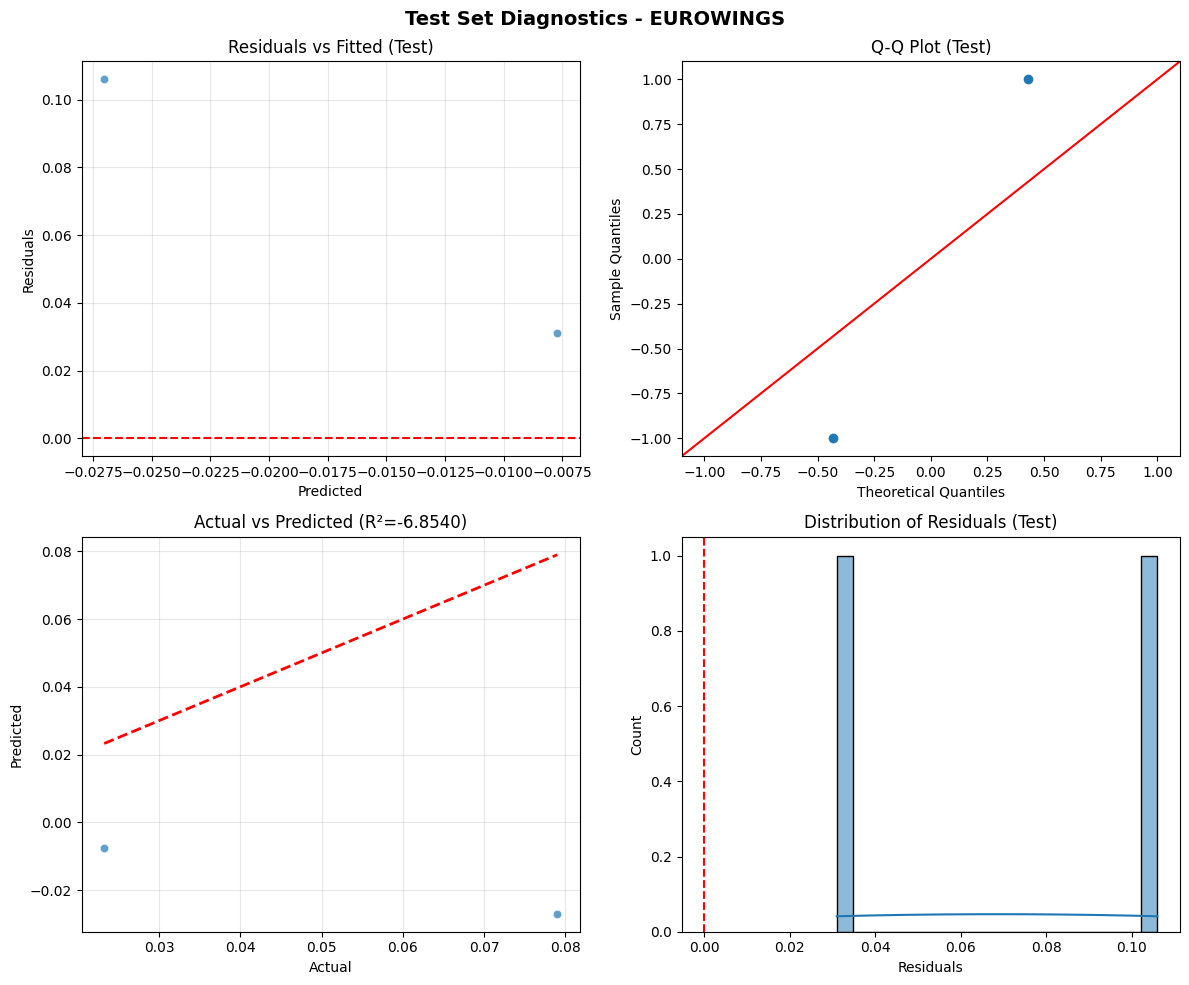


=== Coefficient Confidence Intervals ===


Feature  Coefficient  Std_Error  t_Value  p_Value  CI_Lower  CI_Upper  \
const   const      -0.0228     0.0370  -0.6161   0.5814   -0.1407    0.0950   
PC1       PC1       0.0012     0.0213   0.0562   0.9587   -0.0664    0.0688   
PC2       PC2      -0.0131     0.0977  -0.1342   0.9017   -0.3242    0.2980   

       Significant  
const        False  
PC1          False  
PC2          False

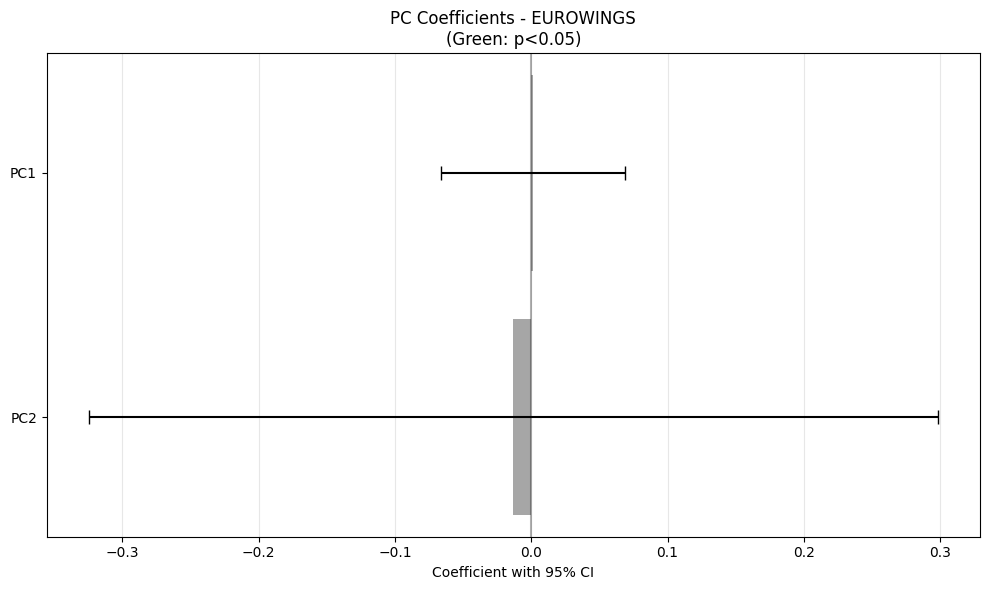


=== FINAL MODEL SUMMARY - EUROWINGS ===


Model  R²_Test  R²_Train    RMSE     MAE      MAPE      AIC      BIC  \
0  PCA + OLS   -6.854    0.0162  0.0781  0.0685  133.7011 -11.3396 -11.9643   

   N_Components  N_Train  N_Test  
0             2        6       2

In [ ]:
# @title
segment = 'eurowings'
linear_numerical_vars = ['fuel', 'material_cost', 'lease_charter', 'staff_cost']
linear_dependent_var = 'adjusted_ebit_marge'
segment_col = 'segment'

df_segment_filtered = df_segment[df_segment['period_type'] != 'covid_shock'].copy()
df_seg = df_segment_filtered[df_segment_filtered[segment_col] == segment].copy()


print(f"SEGMENT: {segment.upper()}")

X_lr_original = df_seg[linear_numerical_vars].copy()
y_lr = df_seg[linear_dependent_var]

print(f"\n Correlation Matrix")
plt.figure(figsize=(8, 6))
sns.heatmap(X_lr_original.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title(f"Correlation Matrix - {segment.upper()}")
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lr_original)

pca_full = PCA()
pca_full.fit_transform(X_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n PCA Analysis")
print("Explained Variance Ratio:", explained_variance.round(4))
print("Cumulative Variance:", cumulative_variance.round(4))

loadings_full = pd.DataFrame(
    pca_full.components_.T,
    columns=[f'PC{i+1}' for i in range(pca_full.n_components_)],
    index=X_lr_original.columns
)
print(f"\nLoadings Matrix:")
display(loadings_full.round(3))

plt.figure(figsize=(10, 6))
sns.heatmap(loadings_full, annot=True, cmap='RdBu_r', center=0, fmt='.3f',
            cbar_kws={'label': 'Loading Strength'})
plt.title(f'PCA Loadings Heatmap - {segment.upper()}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title(f'PCA Scree Plot - {segment.upper()}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

n_components = min(3, np.argmax(cumulative_variance >= 0.95) + 1)
if cumulative_variance[n_components-1] < 0.95 and n_components < len(linear_numerical_vars):
    n_components = min(3, len(linear_numerical_vars))

pca = PCA(n_components=n_components)
X_lr = pd.DataFrame(
    pca.fit_transform(X_scaled),
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=X_lr_original.index
)

print(f"\n Correlation Matrix ")
plt.figure(figsize=(7, 5))
sns.heatmap(X_lr.corr(), annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title(f"Correlation Matrix - {segment.upper()}")
plt.tight_layout()
plt.show()

test_size = max(0.2, 2/len(X_lr))
X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=test_size, random_state=42)
print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

X_train_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame({
    "Feature": X_train_vif.columns,
    "VIF": [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
})
print(f"\n Variance Inflation Factor (VIF)")
display(vif_data.round(4))

print(f"\n STATSMODELS")
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_sm)
results = model.fit()
print(results.summary())

y_pred = results.predict(X_test_sm)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
valid_mape_idx = y_test != 0
mape = np.mean(np.abs((y_test[valid_mape_idx] - y_pred[valid_mape_idx]) / y_test[valid_mape_idx])) * 100 if np.sum(valid_mape_idx) > 0 else np.nan

residuals_train = y_train - results.predict(X_train_sm)
shapiro_stat, shapiro_p = stats.shapiro(residuals_train) if len(residuals_train) >= 3 else (np.nan, np.nan)
bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals_train, X_train_sm)
dw_stat = durbin_watson(residuals_train)

gof_df = pd.DataFrame({
    "Statistic": ["R²", "Adjusted R²", "F-statistic", "F-statistic p-value", "AIC", "BIC",
                  "Durbin-Watson", "Shapiro-Wilk (normality)", "Shapiro-Wilk p-value",
                  "Breusch-Pagan (heteroscedasticity)", "Breusch-Pagan p-value"],
    "Value": [f"{results.rsquared:.4f}", f"{results.rsquared_adj:.4f}", f"{results.fvalue:.4f}",
              f"{results.f_pvalue:.4f}", f"{results.aic:.4f}", f"{results.bic:.4f}",
              f"{dw_stat:.4f}", f"{shapiro_stat:.4f}", f"{shapiro_p:.4f}",
              f"{bp_stat:.4f}", f"{bp_pvalue:.4f}"]
})
print(f"\n Goodness-of-Fit")
display(gof_df)

print(f"\n Advanced Residual Analysis ")
leverage = results.get_influence().hat_matrix_diag
resid_std = residuals_train / (results.resid.std() * np.sqrt(1 - leverage))
resid_student = OLSInfluence(results).resid_studentized

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Residual Analysis - {segment.upper()}', fontsize=14, fontweight='bold')

axes[0, 0].scatter(results.fittedvalues, resid_std, alpha=0.6, color='orange')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].axhline(y=2, color='red', linestyle=':', alpha=0.7, label='±2σ')
axes[0, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.7)
axes[0, 0].set_xlabel('Fitted Values'); axes[0, 0].set_ylabel('Standardized Residuals')
axes[0, 0].set_title('Standardized Residuals vs Fitted'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

sns.histplot(resid_std, bins=30, kde=True, ax=axes[0, 1], color='purple')
axes[0, 1].axvline(x=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Standardized Residuals'); axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Standardized Residuals'); axes[0, 1].grid(True, alpha=0.3)

sm.qqplot(resid_student, line='45', fit=True, ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Studentized Residuals'); axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_visible(False)
plt.tight_layout(); plt.show()

print(f"\n Diagnostic Plots for Test Set ")
residuals_test = y_test - y_pred

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'Test Set Diagnostics - {segment.upper()}', fontsize=14, fontweight='bold')

sns.scatterplot(x=y_pred, y=residuals_test, alpha=0.7, ax=axes[0, 0])
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Predicted'); axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted (Test)'); axes[0, 0].grid(True, alpha=0.3)

sm.qqplot(residuals_test, line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Test)')

sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, ax=axes[1, 0])
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Actual'); axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title(f'Actual vs Predicted (R²={r2_test:.4f})'); axes[1, 0].grid(True, alpha=0.3)

sns.histplot(residuals_test, kde=True, bins=20, ax=axes[1, 1])
axes[1, 1].axvline(x=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Residuals'); axes[1, 1].set_title('Distribution of Residuals (Test)')
plt.tight_layout(); plt.show()

print(f"\n Coefficient Confidence Intervals ")
conf_int = results.conf_int()
conf_int.columns = ['CI_Lower', 'CI_Upper']

coef_summary = pd.DataFrame({
    'Feature': results.params.index, 'Coefficient': results.params.values,
    'Std_Error': results.bse.values, 't_Value': results.tvalues.values,
    'p_Value': results.pvalues.values, 'CI_Lower': conf_int['CI_Lower'],
    'CI_Upper': conf_int['CI_Upper'], 'Significant': results.pvalues.values < 0.05
}).round(4)
display(coef_summary)

sig_coefs = coef_summary[coef_summary['Feature'] != 'const'].sort_values('Coefficient')
plt.figure(figsize=(10, 6))
colors = ['green' if sig else 'gray' for sig in sig_coefs['Significant']]
plt.barh(range(len(sig_coefs)), sig_coefs['Coefficient'],
         xerr=[sig_coefs['Coefficient'] - sig_coefs['CI_Lower'],
               sig_coefs['CI_Upper'] - sig_coefs['Coefficient']], color=colors, alpha=0.7, capsize=5)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.yticks(range(len(sig_coefs)), sig_coefs['Feature'])
plt.xlabel('Coefficient with 95% CI'); plt.title(f'PC Coefficients - {segment.upper()}\n(Green: p<0.05)')
plt.grid(axis='x', alpha=0.3); plt.tight_layout(); plt.show()

print(f"\n MODEL SUMMARY - {segment.upper()}")
summary = pd.DataFrame({
    'Model': ['PCA + OLS'], 'R²_Test': [r2_test], 'R²_Train': [results.rsquared],
    'RMSE': [rmse], 'MAE': [mae], 'MAPE': [mape], 'AIC': [results.aic], 'BIC': [results.bic],
    'N_Components': [n_components], 'N_Train': [len(X_train)], 'N_Test': [len(X_test)]
}).round(4)
display(summary)

Since there are no statistically significant PC, a valid prediction for Adjusted EBI margins for Eurowings cannot be made.